In [4]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import tensorflow as tf
from tensorflow import keras

import pandas as pd
from pandas import read_csv

from sklearn.decomposition import PCA
import umap

import datetime

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers, initializers, regularizers, models
import tensorflow.keras.backend as K

# fix CUDNN_STATUS_INTERNAL_ERROR
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [5]:
#path for virgil
virgil_path = '/home/alon/Projects/project/'
laptop_path = '/home/alon/school/c247a/datasets/project_data/project/'

# Convert from 64 to 32 bit floats
X_test = np.load(virgil_path + "X_test.npy").astype(np.float32)
y_test = np.load(virgil_path + "y_test.npy").astype(np.float32)
person_train_valid = np.load(virgil_path + "person_train_valid.npy").astype(np.float32)
X_train_valid = np.load(virgil_path + "X_train_valid.npy").astype(np.float32)
y_train_valid = np.load(virgil_path + "y_train_valid.npy").astype(np.float32)
person_test = np.load(virgil_path + "person_test.npy").astype(np.float32)

# adjust labels 
y_train_valid -= 769
y_test -= 769

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))
print('y_train_valid', y_train_valid[:10])

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)
y_train_valid [2. 3. 0. 0. 0. 0. 2. 1. 3. 3.]


In [6]:
def ksquare(x):
    return tf.pow(x, 2)

def klog(x):
    return tf.math.log(x)

In [7]:
def convert_to_one_hot(in_arr):
    in_arr = in_arr.reshape((in_arr.shape[0],))
    in_arr = in_arr.astype(int)
    in_arr_1h = np.zeros((in_arr.size, in_arr.max()+1))
    in_arr_1h[np.arange(in_arr.size),in_arr] = 1
    return in_arr_1h

In [8]:
#convert all vectors to one-hot
y_train_valid_1h = convert_to_one_hot(y_train_valid)
y_test_1h = convert_to_one_hot(y_test)

person_train_valid_1h = convert_to_one_hot(person_train_valid)
person_test_1h = convert_to_one_hot(person_test)

In [9]:
#normalizing and then adding noise to every single training input

X_train_valid_norm = np.zeros_like(X_train_valid)

for eeg_ix in range(X_train_valid.shape[0]):
    for i in range(22):
        #normalize the data
        y = X_train_valid[eeg_ix,i,:]
        mean = np.mean(y)
        std = np.std(y)
        z = (y-mean)/std
        X_train_valid_norm[eeg_ix,i,:] = z
        

#don't want to actually use the one with noise        
# mu, sigma = 0, 0.10
# s = np.random.normal(mu, sigma, X_train_valid_norm.shape)
# print("Noise shape: {}".format(s.shape))
# X_train_valid_norm_noised = X_train_valid_norm + s

In [10]:
#normalizing and then adding noise to every single test input

X_test_norm = np.zeros_like(X_test)

for eeg_ix in range(X_test.shape[0]):
    for i in range(22):
        #normalize the data
        y = X_test[eeg_ix,i,:]
        mean = np.mean(y)
        std = np.std(y)
        z = (y-mean)/std
        X_test_norm[eeg_ix,i,:] = z
        
# mu, sigma = 0, 0.10
# s = np.random.normal(mu, sigma, X_test_norm.shape)
# print("Noise shape: {}".format(s.shape))
# X_test_norm_noised = X_test_norm + s

In [11]:
#Crop for 12

X_train_valid_norm_cropped = X_train_valid_norm[:,:,:500]
X_test_norm_cropped = X_test_norm[:,:,:500]

## This is the preprocessing setup for the current best network done: standardized inputs and cropped.

## Now let's try dimensionality reduction, first using PCA, and then UMAP

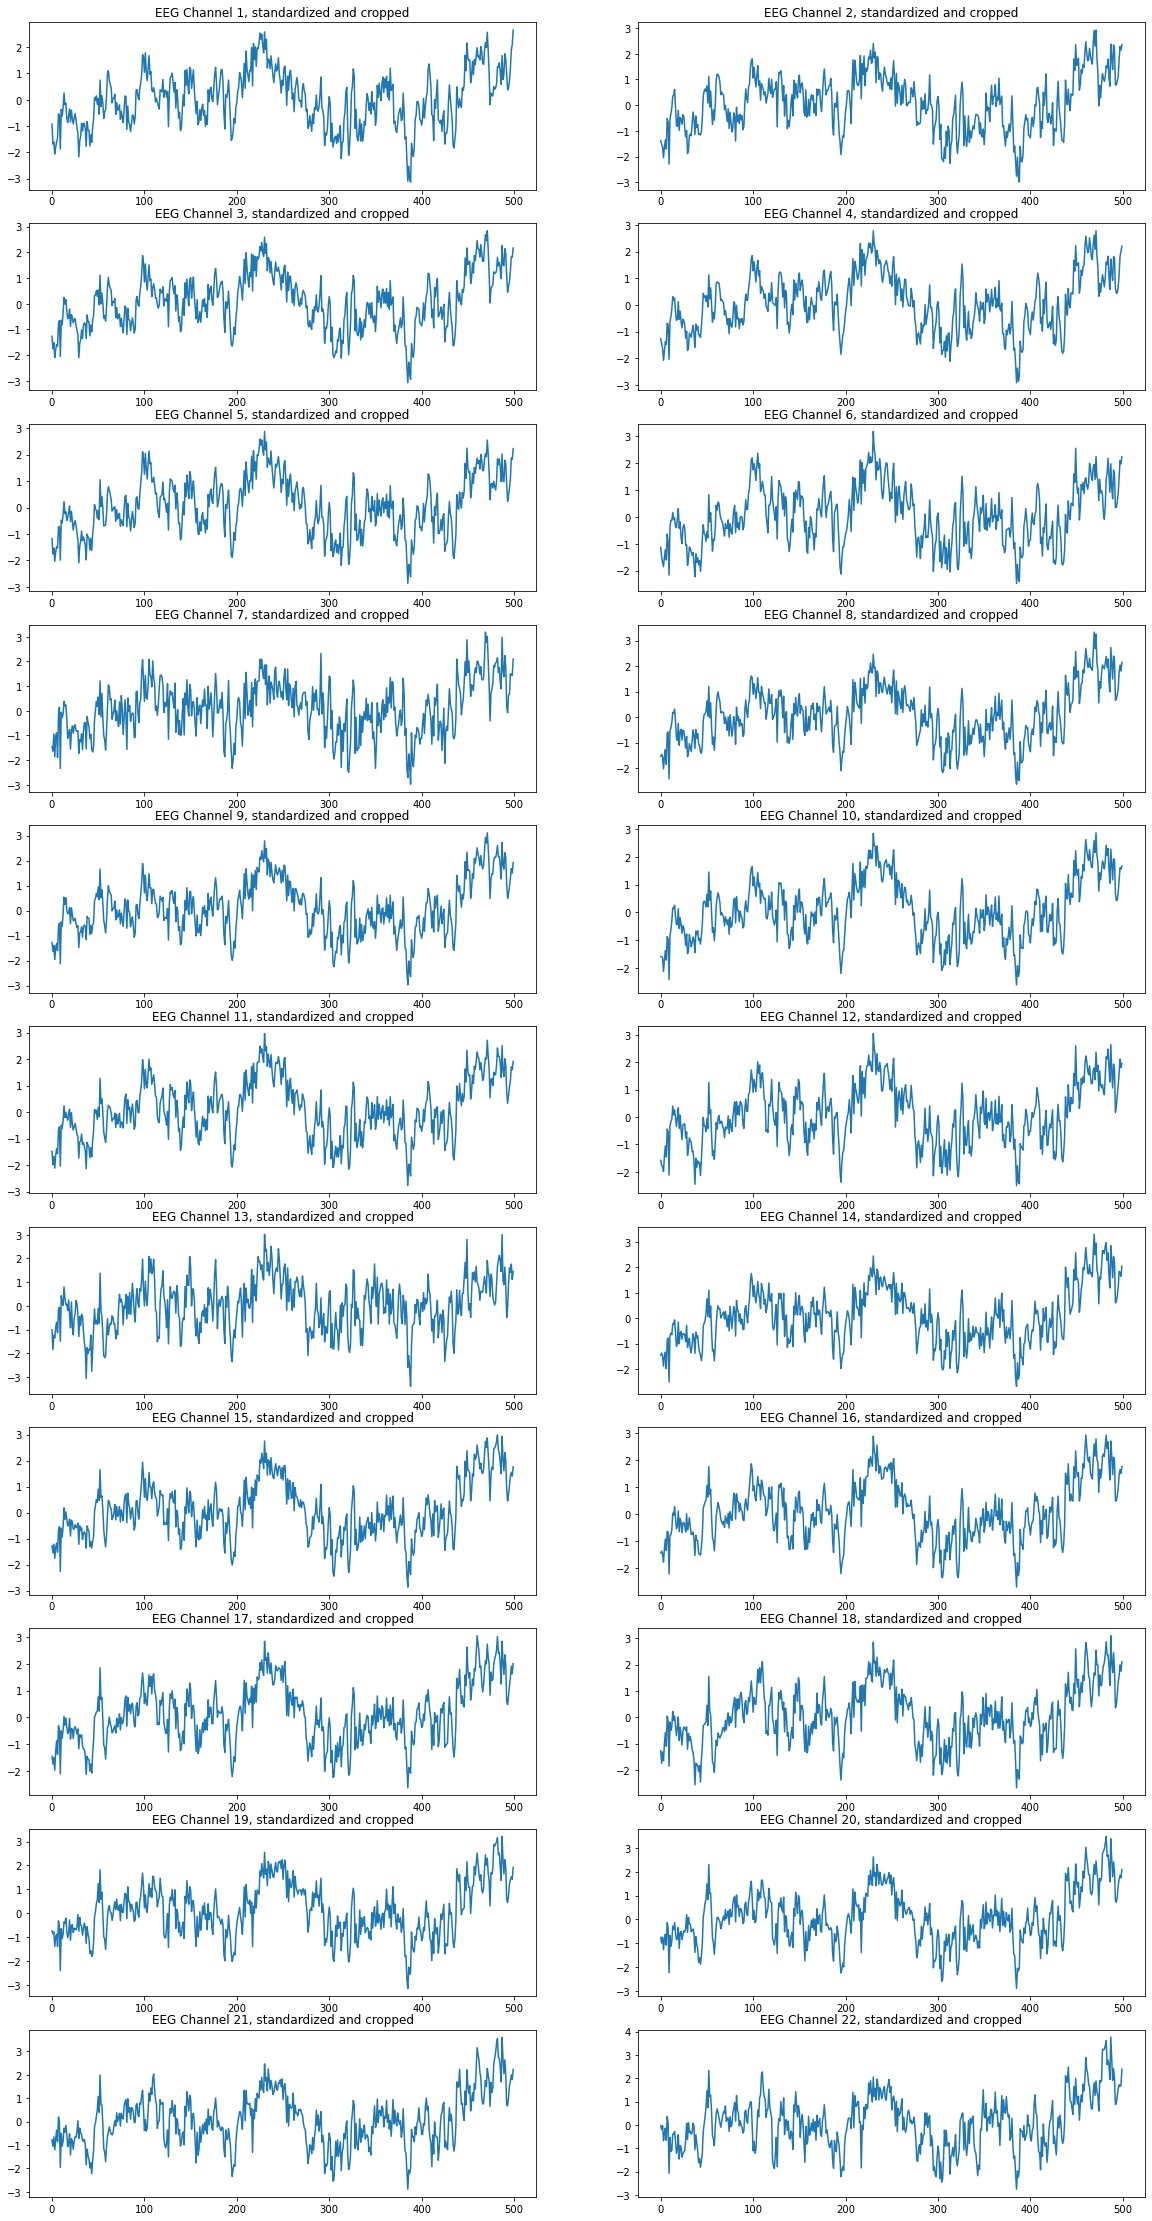

In [12]:
#Take a look at some random capture

fig, axs = plt.subplots(11,2,figsize=(20,40))

count = 0

eeg_ix = 10

for i in range(22):
    y = X_train_valid_norm_cropped[eeg_ix,i,:]
    
    axs[int(i/2),count].plot(y)
    axs[int(i/2),count].set_title('EEG Channel {}, standardized and cropped'.format(i+1))
    
    count += 1
    if (count>1):
        count=0

In [13]:
#need to flip the tensor so that it's (examples, timesteps, channels)
X_train_valid_flipped = np.transpose(X_train_valid_norm_cropped, (0,2,1))
print(X_train_valid_flipped.shape)

(2115, 500, 22)


In [14]:
n_comp=16   #This is the number of channels we want to reduce to


X_train_valid_reshaped = X_train_valid_flipped.reshape((X_train_valid_norm_cropped.shape[0]*X_train_valid_norm_cropped.shape[2], 22)) 
print(X_train_valid_reshaped.shape)
X_test_flipped = np.transpose(X_test_norm_cropped, (0,2,1))
X_test_reshaped = X_test_flipped.reshape((X_test_norm_cropped.shape[0]*X_test_norm_cropped.shape[2], 22)) 


#try a PCA on the data
#reshaped_data = X_train_valid_flipped.reshape((X_train_valid_cropped.shape[1]*X_train_valid_cropped.shape[2], 22))    # create one big data panel with 20 series and 300.000 datapoints
                                      #choose the number of features to have after dimensionality reduction
pca = PCA(n_components=n_comp)                  #create the pca object       
pca.fit(X_train_valid_reshaped)                               #fit it to your transformed data
X_train_valid_transformed=np.empty([X_train_valid_norm_cropped.shape[0],X_train_valid_norm_cropped.shape[2],n_comp])
for i in range(len(X_train_valid_flipped)):
    #print(X_train_valid_flipped[i].shape)
    X_train_valid_transformed[i]=pca.transform(X_train_valid_flipped[i])           #iteratively apply the transformation to each instance of the original dataset

        
print(X_train_valid_transformed.shape)    #we end up with examples*timesteps*channels
#now transpose back to examples*channels*timesteps
X_train_valid_transformed = np.transpose(X_train_valid_transformed, (0,2,1))

#n_comp=4                                      #choose the number of features to have after dimensionality reduction
pca = PCA(n_components=n_comp)                  #create the pca object       
pca.fit(X_test_reshaped)                               #fit it to your transformed data
X_test_transformed=np.empty([X_test_norm_cropped.shape[0],X_test_norm_cropped.shape[2],n_comp])
#print(X_test_transformed.shape)
for i in range(len(X_test_flipped)):
    #print(X_test_flipped[i].shape)
    X_test_transformed[i]=pca.transform(X_test_flipped[i])           #iteratively apply the transformation to each instance of the original dataset

print(X_test_transformed.shape)    #we end up with examples*timesteps*channels
#now transpose back to examples*channels*timesteps
X_test_transformed = np.transpose(X_test_transformed, (0,2,1))

(1057500, 22)
(2115, 500, 16)
(443, 500, 16)


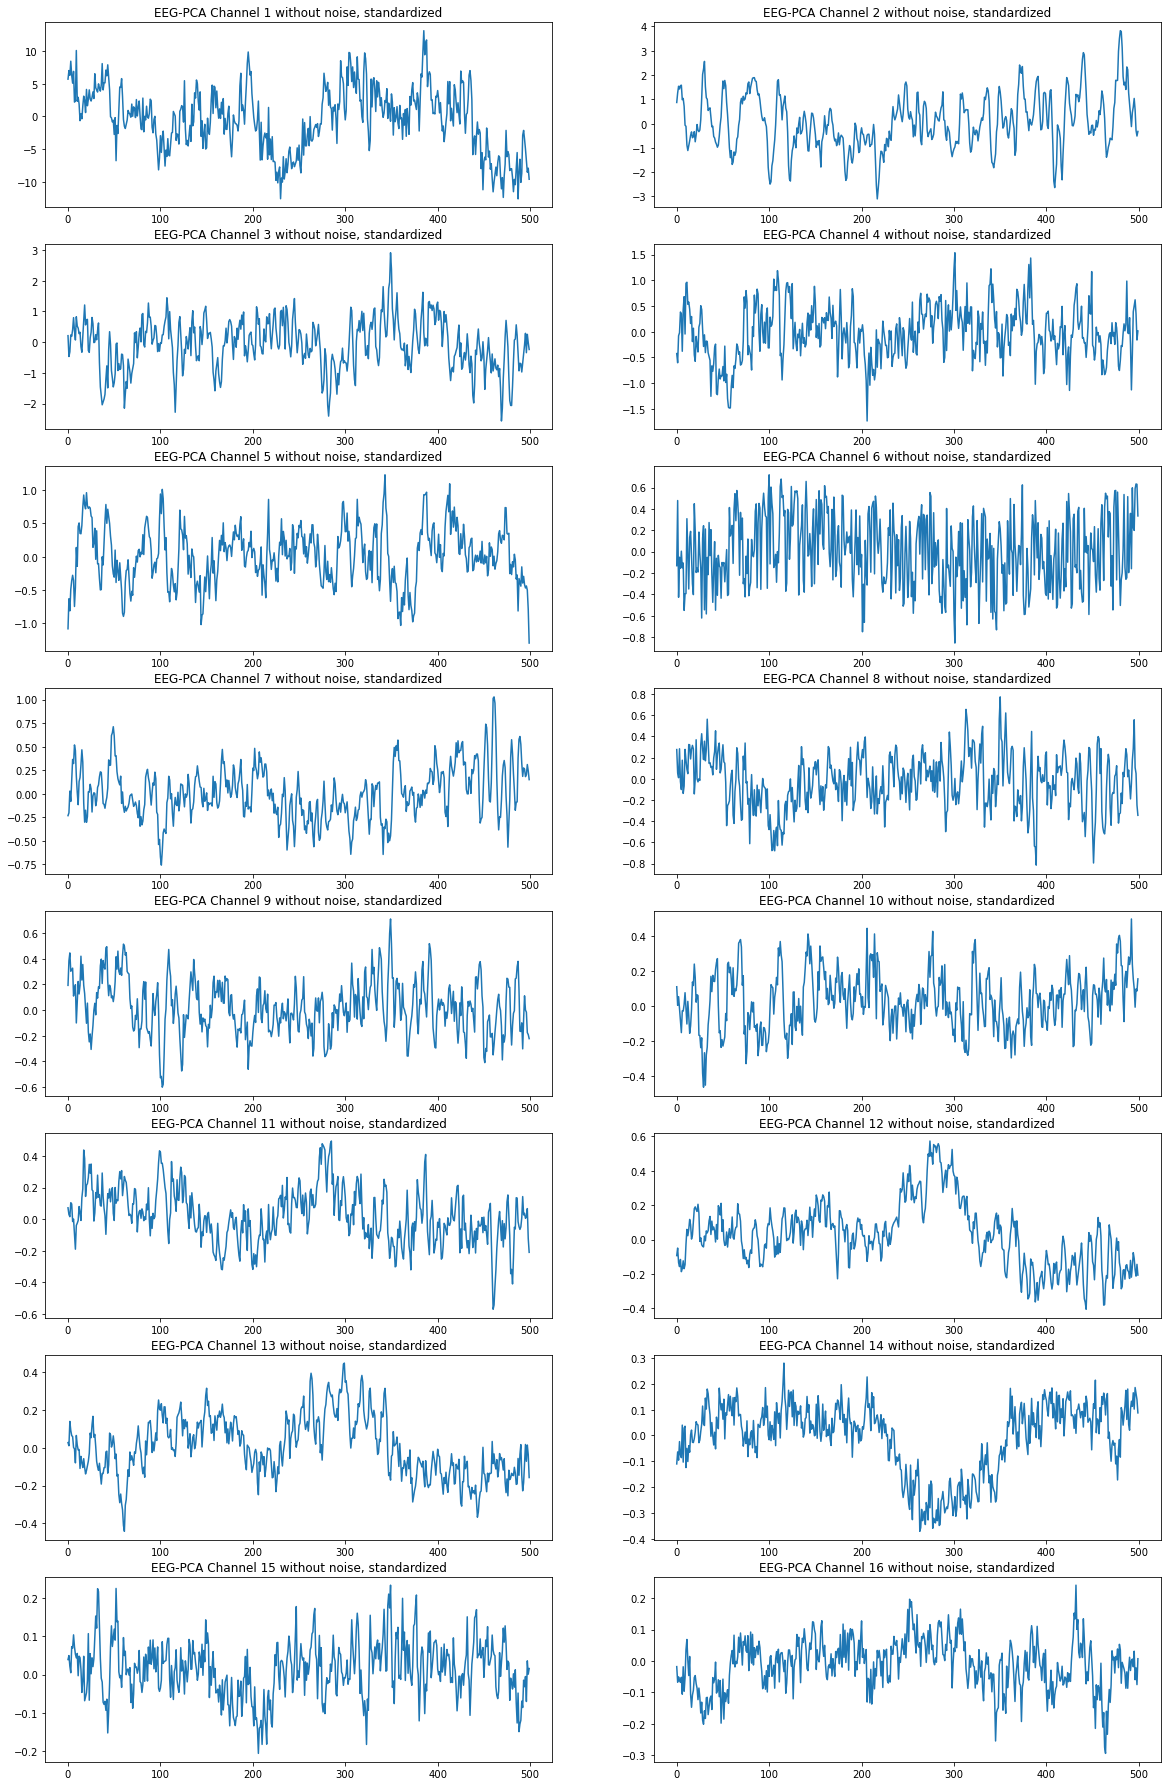

In [15]:
#This is to plot the new channels after PCA

fig, axs = plt.subplots(int(n_comp/2),2,figsize=(20,n_comp*2))

count = 0

eeg_ix = 10

for i in range(n_comp):
    y = X_train_valid_transformed[eeg_ix,i,:]
    
    axs[int(i/2),count].plot(y)
    axs[int(i/2),count].set_title('EEG-PCA Channel {} without noise, standardized'.format(i+1))
    
    count += 1
    if (count>1):
        count=0

Testing PCA Network for n_dims = 10
Model: "shallow_convnet_one_hot"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 500)]         0         
_________________________________________________________________
reshape (Reshape)            (None, 10, 500, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 10, 476, 40)       1040      
_________________________________________________________________
permute (Permute)            (None, 476, 10, 40)       0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 476, 400)          0         
_________________________________________________________________
dense (Dense)                (None, 476, 40)           16040     
_________________________________________________________________
activat

53/53 [==============================] - 0s 4ms/step - loss: 0.6426 - acc: 0.7707 - val_loss: 0.8235 - val_acc: 0.6761
Epoch 49/75
53/53 [==============================] - 0s 4ms/step - loss: 0.6691 - acc: 0.7665 - val_loss: 0.8313 - val_acc: 0.6832
Epoch 50/75
53/53 [==============================] - 0s 4ms/step - loss: 0.6702 - acc: 0.7642 - val_loss: 0.8131 - val_acc: 0.6998
Epoch 51/75
53/53 [==============================] - 0s 4ms/step - loss: 0.6593 - acc: 0.7695 - val_loss: 0.8202 - val_acc: 0.6927
Epoch 52/75
53/53 [==============================] - 0s 4ms/step - loss: 0.6652 - acc: 0.7683 - val_loss: 0.8170 - val_acc: 0.6998
Epoch 53/75
53/53 [==============================] - 0s 4ms/step - loss: 0.6650 - acc: 0.7695 - val_loss: 0.8040 - val_acc: 0.7187
Epoch 54/75
53/53 [==============================] - 0s 4ms/step - loss: 0.6576 - acc: 0.7701 - val_loss: 0.7942 - val_acc: 0.7210
Epoch 55/75
53/53 [==============================] - 0s 4ms/step - loss: 0.6616 - acc: 0.7790 -

53/53 [==============================] - 0s 4ms/step - loss: 0.7829 - acc: 0.6974 - val_loss: 0.7999 - val_acc: 0.7116
Epoch 21/75
53/53 [==============================] - 0s 4ms/step - loss: 0.8122 - acc: 0.7033 - val_loss: 0.7962 - val_acc: 0.7187
Epoch 22/75
53/53 [==============================] - 0s 4ms/step - loss: 0.7913 - acc: 0.7080 - val_loss: 0.7766 - val_acc: 0.7281
Epoch 23/75
53/53 [==============================] - 0s 4ms/step - loss: 0.7682 - acc: 0.7181 - val_loss: 0.8096 - val_acc: 0.6974
Epoch 24/75
53/53 [==============================] - 0s 4ms/step - loss: 0.7777 - acc: 0.7104 - val_loss: 0.8016 - val_acc: 0.7234
Epoch 25/75
53/53 [==============================] - 0s 4ms/step - loss: 0.7500 - acc: 0.7352 - val_loss: 0.7940 - val_acc: 0.7092
Epoch 26/75
53/53 [==============================] - 0s 4ms/step - loss: 0.7624 - acc: 0.7074 - val_loss: 0.7846 - val_acc: 0.7258
Epoch 27/75
53/53 [==============================] - 0s 4ms/step - loss: 0.7631 - acc: 0.7181 -

53/53 [==============================] - 0s 7ms/step - loss: 1.8594 - acc: 0.2417 - val_loss: 1.3629 - val_acc: 0.3641
Epoch 2/75
53/53 [==============================] - 0s 5ms/step - loss: 1.3961 - acc: 0.3463 - val_loss: 1.3062 - val_acc: 0.4113
Epoch 3/75
53/53 [==============================] - 0s 5ms/step - loss: 1.3107 - acc: 0.4078 - val_loss: 1.2336 - val_acc: 0.4704
Epoch 4/75
53/53 [==============================] - 0s 4ms/step - loss: 1.2193 - acc: 0.4787 - val_loss: 1.1401 - val_acc: 0.5012
Epoch 5/75
53/53 [==============================] - 0s 5ms/step - loss: 1.1824 - acc: 0.5130 - val_loss: 1.0997 - val_acc: 0.5248
Epoch 6/75
53/53 [==============================] - 0s 5ms/step - loss: 1.0792 - acc: 0.5697 - val_loss: 1.0682 - val_acc: 0.5390
Epoch 7/75
53/53 [==============================] - 0s 5ms/step - loss: 1.0339 - acc: 0.5762 - val_loss: 1.0426 - val_acc: 0.5816
Epoch 8/75
53/53 [==============================] - 0s 4ms/step - loss: 1.0247 - acc: 0.5816 - val_lo

Epoch 64/75
53/53 [==============================] - 0s 5ms/step - loss: 0.5727 - acc: 0.8115 - val_loss: 0.8533 - val_acc: 0.6998
Epoch 65/75
53/53 [==============================] - 0s 8ms/step - loss: 0.5671 - acc: 0.8168 - val_loss: 0.8818 - val_acc: 0.6738
Epoch 66/75
53/53 [==============================] - 0s 5ms/step - loss: 0.5713 - acc: 0.8121 - val_loss: 0.8566 - val_acc: 0.7021
Epoch 67/75
53/53 [==============================] - 0s 5ms/step - loss: 0.5548 - acc: 0.8268 - val_loss: 0.8858 - val_acc: 0.6950
Epoch 68/75
53/53 [==============================] - 0s 5ms/step - loss: 0.5678 - acc: 0.8115 - val_loss: 0.8577 - val_acc: 0.6974
Epoch 69/75
53/53 [==============================] - 0s 4ms/step - loss: 0.5758 - acc: 0.8079 - val_loss: 0.8650 - val_acc: 0.7021
Epoch 70/75
53/53 [==============================] - 0s 5ms/step - loss: 0.5680 - acc: 0.8203 - val_loss: 0.8589 - val_acc: 0.6950
Epoch 71/75
53/53 [==============================] - 0s 5ms/step - loss: 0.5683 - a

53/53 [==============================] - 0s 5ms/step - loss: 0.6893 - acc: 0.7530 - val_loss: 0.8030 - val_acc: 0.6998
Epoch 37/75
53/53 [==============================] - 0s 5ms/step - loss: 0.6649 - acc: 0.7630 - val_loss: 0.7837 - val_acc: 0.7045
Epoch 38/75
53/53 [==============================] - 0s 5ms/step - loss: 0.6935 - acc: 0.7470 - val_loss: 0.7702 - val_acc: 0.7210
Epoch 39/75
53/53 [==============================] - 0s 5ms/step - loss: 0.6797 - acc: 0.7565 - val_loss: 0.7879 - val_acc: 0.6974
Epoch 40/75
53/53 [==============================] - 0s 5ms/step - loss: 0.6829 - acc: 0.7612 - val_loss: 0.7904 - val_acc: 0.7092
Epoch 41/75
53/53 [==============================] - 0s 5ms/step - loss: 0.6540 - acc: 0.7606 - val_loss: 0.7950 - val_acc: 0.6974
Epoch 42/75
53/53 [==============================] - 0s 5ms/step - loss: 0.6604 - acc: 0.7754 - val_loss: 0.7805 - val_acc: 0.7187
Epoch 43/75
53/53 [==============================] - 0s 5ms/step - loss: 0.6518 - acc: 0.7760 -

53/53 [==============================] - 0s 5ms/step - loss: 0.9939 - acc: 0.6105 - val_loss: 0.9780 - val_acc: 0.6241
Epoch 9/75
53/53 [==============================] - 0s 5ms/step - loss: 0.9473 - acc: 0.6259 - val_loss: 0.9292 - val_acc: 0.6170
Epoch 10/75
53/53 [==============================] - 0s 5ms/step - loss: 0.9175 - acc: 0.6413 - val_loss: 0.8985 - val_acc: 0.6619
Epoch 11/75
53/53 [==============================] - 0s 5ms/step - loss: 0.9025 - acc: 0.6602 - val_loss: 0.8748 - val_acc: 0.6572
Epoch 12/75
53/53 [==============================] - 0s 6ms/step - loss: 0.9167 - acc: 0.6407 - val_loss: 0.8691 - val_acc: 0.6548
Epoch 13/75
53/53 [==============================] - 0s 5ms/step - loss: 0.8685 - acc: 0.6791 - val_loss: 0.8723 - val_acc: 0.6572
Epoch 14/75
53/53 [==============================] - 0s 5ms/step - loss: 0.8630 - acc: 0.6844 - val_loss: 0.8456 - val_acc: 0.6619
Epoch 15/75
53/53 [==============================] - 0s 5ms/step - loss: 0.8289 - acc: 0.6903 - 

53/53 [==============================] - 0s 5ms/step - loss: 0.5356 - acc: 0.8197 - val_loss: 0.8029 - val_acc: 0.7045
Epoch 71/75
53/53 [==============================] - 0s 5ms/step - loss: 0.5450 - acc: 0.8209 - val_loss: 0.8237 - val_acc: 0.7116
Epoch 72/75
53/53 [==============================] - 0s 5ms/step - loss: 0.5340 - acc: 0.8251 - val_loss: 0.8453 - val_acc: 0.6927
Epoch 73/75
53/53 [==============================] - 0s 5ms/step - loss: 0.5262 - acc: 0.8197 - val_loss: 0.8462 - val_acc: 0.6998
Epoch 74/75
53/53 [==============================] - 0s 5ms/step - loss: 0.5138 - acc: 0.8304 - val_loss: 0.8290 - val_acc: 0.7092
Epoch 75/75
53/53 [==============================] - 0s 5ms/step - loss: 0.5293 - acc: 0.8257 - val_loss: 0.8141 - val_acc: 0.7187
Testing PCA Network for n_dims = 15
Model: "shallow_convnet_one_hot"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)     

53/53 [==============================] - 0s 5ms/step - loss: 0.5974 - acc: 0.7890 - val_loss: 0.7818 - val_acc: 0.7281
Epoch 43/75
53/53 [==============================] - 0s 5ms/step - loss: 0.6023 - acc: 0.7896 - val_loss: 0.7760 - val_acc: 0.7163
Epoch 44/75
53/53 [==============================] - 0s 5ms/step - loss: 0.6213 - acc: 0.7807 - val_loss: 0.7846 - val_acc: 0.7258
Epoch 45/75
53/53 [==============================] - 0s 5ms/step - loss: 0.6045 - acc: 0.7961 - val_loss: 0.7988 - val_acc: 0.7187
Epoch 46/75
53/53 [==============================] - 0s 5ms/step - loss: 0.6136 - acc: 0.7878 - val_loss: 0.8042 - val_acc: 0.7069
Epoch 47/75
53/53 [==============================] - 0s 5ms/step - loss: 0.5849 - acc: 0.8032 - val_loss: 0.8168 - val_acc: 0.7069
Epoch 48/75
53/53 [==============================] - 0s 5ms/step - loss: 0.6101 - acc: 0.7872 - val_loss: 0.7742 - val_acc: 0.7470
Epoch 49/75
53/53 [==============================] - 0s 5ms/step - loss: 0.5738 - acc: 0.8050 -

53/53 [==============================] - 0s 5ms/step - loss: 0.8666 - acc: 0.6673 - val_loss: 0.8588 - val_acc: 0.6832
Epoch 15/75
53/53 [==============================] - 0s 5ms/step - loss: 0.8447 - acc: 0.6933 - val_loss: 0.8502 - val_acc: 0.6667
Epoch 16/75
53/53 [==============================] - 0s 5ms/step - loss: 0.8278 - acc: 0.6903 - val_loss: 0.8411 - val_acc: 0.6667
Epoch 17/75
53/53 [==============================] - 0s 5ms/step - loss: 0.7789 - acc: 0.7086 - val_loss: 0.8312 - val_acc: 0.6832
Epoch 18/75
53/53 [==============================] - 0s 5ms/step - loss: 0.8055 - acc: 0.6939 - val_loss: 0.8446 - val_acc: 0.6832
Epoch 19/75
53/53 [==============================] - 0s 5ms/step - loss: 0.7965 - acc: 0.6986 - val_loss: 0.8080 - val_acc: 0.6761
Epoch 20/75
53/53 [==============================] - 0s 5ms/step - loss: 0.8021 - acc: 0.6956 - val_loss: 0.7959 - val_acc: 0.6879
Epoch 21/75
53/53 [==============================] - 0s 5ms/step - loss: 0.7720 - acc: 0.7151 -

Epoch 1/75
53/53 [==============================] - 0s 8ms/step - loss: 1.9532 - acc: 0.2606 - val_loss: 1.3598 - val_acc: 0.3830
Epoch 2/75
53/53 [==============================] - 0s 5ms/step - loss: 1.4379 - acc: 0.3375 - val_loss: 1.3098 - val_acc: 0.3948
Epoch 3/75
53/53 [==============================] - 0s 5ms/step - loss: 1.3041 - acc: 0.4131 - val_loss: 1.2385 - val_acc: 0.4657
Epoch 4/75
53/53 [==============================] - 0s 5ms/step - loss: 1.2075 - acc: 0.4900 - val_loss: 1.1567 - val_acc: 0.5083
Epoch 5/75
53/53 [==============================] - 0s 5ms/step - loss: 1.1107 - acc: 0.5538 - val_loss: 1.0928 - val_acc: 0.5485
Epoch 6/75
53/53 [==============================] - 0s 5ms/step - loss: 1.0608 - acc: 0.5745 - val_loss: 1.0559 - val_acc: 0.5603
Epoch 7/75
53/53 [==============================] - 0s 5ms/step - loss: 1.0277 - acc: 0.5999 - val_loss: 1.0001 - val_acc: 0.5957
Epoch 8/75
53/53 [==============================] - 0s 5ms/step - loss: 0.9704 - acc: 0.63

53/53 [==============================] - 0s 5ms/step - loss: 0.5304 - acc: 0.8322 - val_loss: 0.8806 - val_acc: 0.6879
Epoch 64/75
53/53 [==============================] - 0s 5ms/step - loss: 0.4985 - acc: 0.8463 - val_loss: 0.8543 - val_acc: 0.6879
Epoch 65/75
53/53 [==============================] - 0s 5ms/step - loss: 0.4932 - acc: 0.8528 - val_loss: 0.8441 - val_acc: 0.7045
Epoch 66/75
53/53 [==============================] - 0s 5ms/step - loss: 0.4980 - acc: 0.8322 - val_loss: 0.8544 - val_acc: 0.6950
Epoch 67/75
53/53 [==============================] - 0s 5ms/step - loss: 0.5077 - acc: 0.8363 - val_loss: 0.8572 - val_acc: 0.6974
Epoch 68/75
53/53 [==============================] - 0s 5ms/step - loss: 0.4943 - acc: 0.8410 - val_loss: 0.8632 - val_acc: 0.6974
Epoch 69/75
53/53 [==============================] - 0s 5ms/step - loss: 0.5145 - acc: 0.8268 - val_loss: 0.8564 - val_acc: 0.6809
Epoch 70/75
53/53 [==============================] - 0s 5ms/step - loss: 0.5124 - acc: 0.8375 -

53/53 [==============================] - 0s 6ms/step - loss: 0.6682 - acc: 0.7636 - val_loss: 0.8469 - val_acc: 0.7092
Epoch 36/75
53/53 [==============================] - 0s 5ms/step - loss: 0.6312 - acc: 0.7837 - val_loss: 0.8570 - val_acc: 0.6879
Epoch 37/75
53/53 [==============================] - 0s 6ms/step - loss: 0.6019 - acc: 0.7819 - val_loss: 0.8328 - val_acc: 0.7116
Epoch 38/75
53/53 [==============================] - 0s 5ms/step - loss: 0.6489 - acc: 0.7813 - val_loss: 0.8549 - val_acc: 0.7187
Epoch 39/75
53/53 [==============================] - 0s 5ms/step - loss: 0.5822 - acc: 0.7920 - val_loss: 0.8341 - val_acc: 0.7281
Epoch 40/75
53/53 [==============================] - 0s 5ms/step - loss: 0.6118 - acc: 0.7908 - val_loss: 0.8463 - val_acc: 0.7069
Epoch 41/75
53/53 [==============================] - 0s 5ms/step - loss: 0.5913 - acc: 0.7973 - val_loss: 0.8394 - val_acc: 0.7234
Epoch 42/75
53/53 [==============================] - 0s 6ms/step - loss: 0.5967 - acc: 0.7979 -

53/53 [==============================] - 0s 6ms/step - loss: 1.0354 - acc: 0.6082 - val_loss: 1.0207 - val_acc: 0.5650
Epoch 8/75
53/53 [==============================] - 0s 6ms/step - loss: 1.0065 - acc: 0.5969 - val_loss: 1.0162 - val_acc: 0.5816
Epoch 9/75
53/53 [==============================] - 0s 6ms/step - loss: 0.9627 - acc: 0.6217 - val_loss: 0.9665 - val_acc: 0.5887
Epoch 10/75
53/53 [==============================] - 0s 6ms/step - loss: 0.9389 - acc: 0.6336 - val_loss: 0.9587 - val_acc: 0.6217
Epoch 11/75
53/53 [==============================] - 0s 6ms/step - loss: 0.9110 - acc: 0.6489 - val_loss: 0.9496 - val_acc: 0.6099
Epoch 12/75
53/53 [==============================] - 0s 6ms/step - loss: 0.8916 - acc: 0.6513 - val_loss: 0.9237 - val_acc: 0.6288
Epoch 13/75
53/53 [==============================] - 0s 6ms/step - loss: 0.8715 - acc: 0.6531 - val_loss: 0.9099 - val_acc: 0.6383
Epoch 14/75
53/53 [==============================] - 0s 6ms/step - loss: 0.8477 - acc: 0.6868 - v

53/53 [==============================] - 0s 6ms/step - loss: 0.5005 - acc: 0.8404 - val_loss: 0.8634 - val_acc: 0.7187
Epoch 70/75
53/53 [==============================] - 0s 6ms/step - loss: 0.4702 - acc: 0.8540 - val_loss: 0.9001 - val_acc: 0.7258
Epoch 71/75
53/53 [==============================] - 0s 6ms/step - loss: 0.5160 - acc: 0.8327 - val_loss: 0.8682 - val_acc: 0.7234
Epoch 72/75
53/53 [==============================] - 0s 6ms/step - loss: 0.4878 - acc: 0.8452 - val_loss: 0.8751 - val_acc: 0.7139
Epoch 73/75
53/53 [==============================] - 0s 6ms/step - loss: 0.4761 - acc: 0.8398 - val_loss: 0.8722 - val_acc: 0.7163
Epoch 74/75
53/53 [==============================] - 0s 6ms/step - loss: 0.4581 - acc: 0.8534 - val_loss: 0.9055 - val_acc: 0.7116
Epoch 75/75
53/53 [==============================] - 0s 6ms/step - loss: 0.4804 - acc: 0.8587 - val_loss: 0.8876 - val_acc: 0.7139
Testing PCA Network for n_dims = 20
Model: "shallow_convnet_one_hot"
__________________________

53/53 [==============================] - 0s 6ms/step - loss: 0.5862 - acc: 0.8032 - val_loss: 0.7945 - val_acc: 0.7187
Epoch 42/75
53/53 [==============================] - 0s 6ms/step - loss: 0.5666 - acc: 0.8097 - val_loss: 0.7966 - val_acc: 0.7187
Epoch 43/75
53/53 [==============================] - 0s 6ms/step - loss: 0.5783 - acc: 0.8056 - val_loss: 0.8099 - val_acc: 0.7163
Epoch 44/75
53/53 [==============================] - 0s 6ms/step - loss: 0.5604 - acc: 0.8126 - val_loss: 0.8282 - val_acc: 0.7069
Epoch 45/75
53/53 [==============================] - 0s 6ms/step - loss: 0.5576 - acc: 0.8197 - val_loss: 0.8050 - val_acc: 0.7329
Epoch 46/75
53/53 [==============================] - 0s 6ms/step - loss: 0.5750 - acc: 0.8050 - val_loss: 0.8150 - val_acc: 0.7092
Epoch 47/75
53/53 [==============================] - 0s 6ms/step - loss: 0.5463 - acc: 0.8186 - val_loss: 0.8090 - val_acc: 0.7234
Epoch 48/75
53/53 [==============================] - 0s 6ms/step - loss: 0.5614 - acc: 0.8079 -

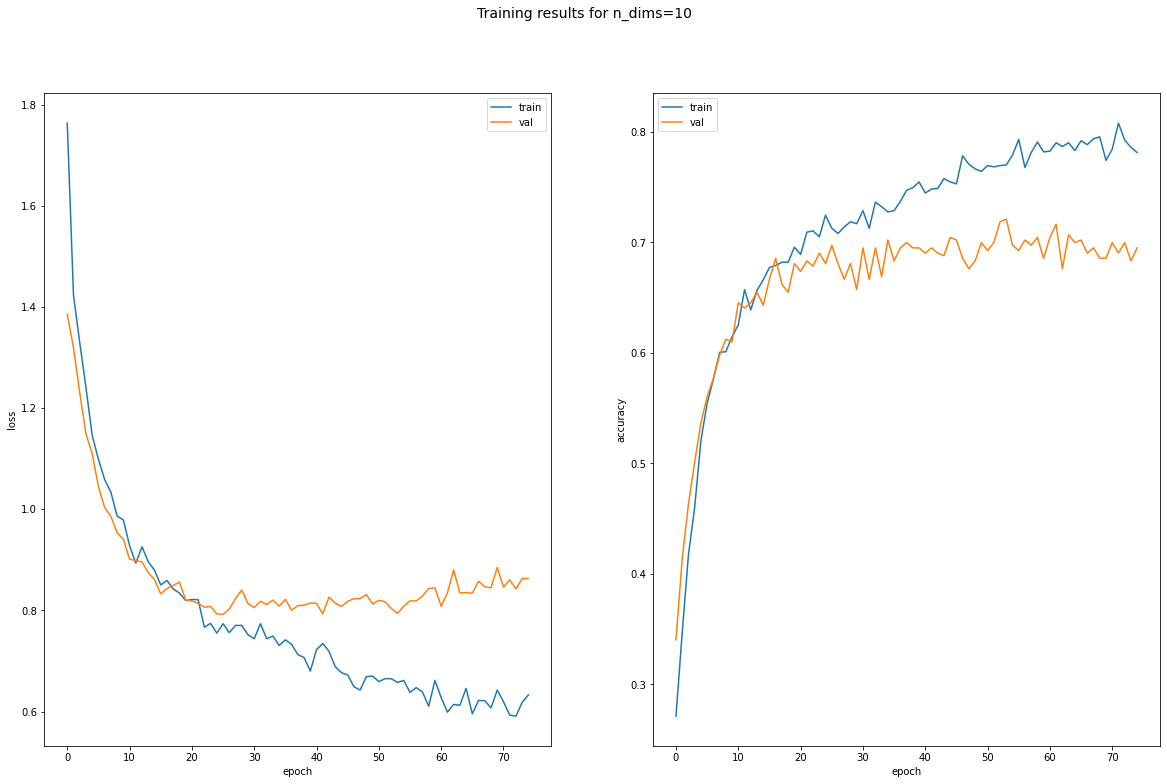

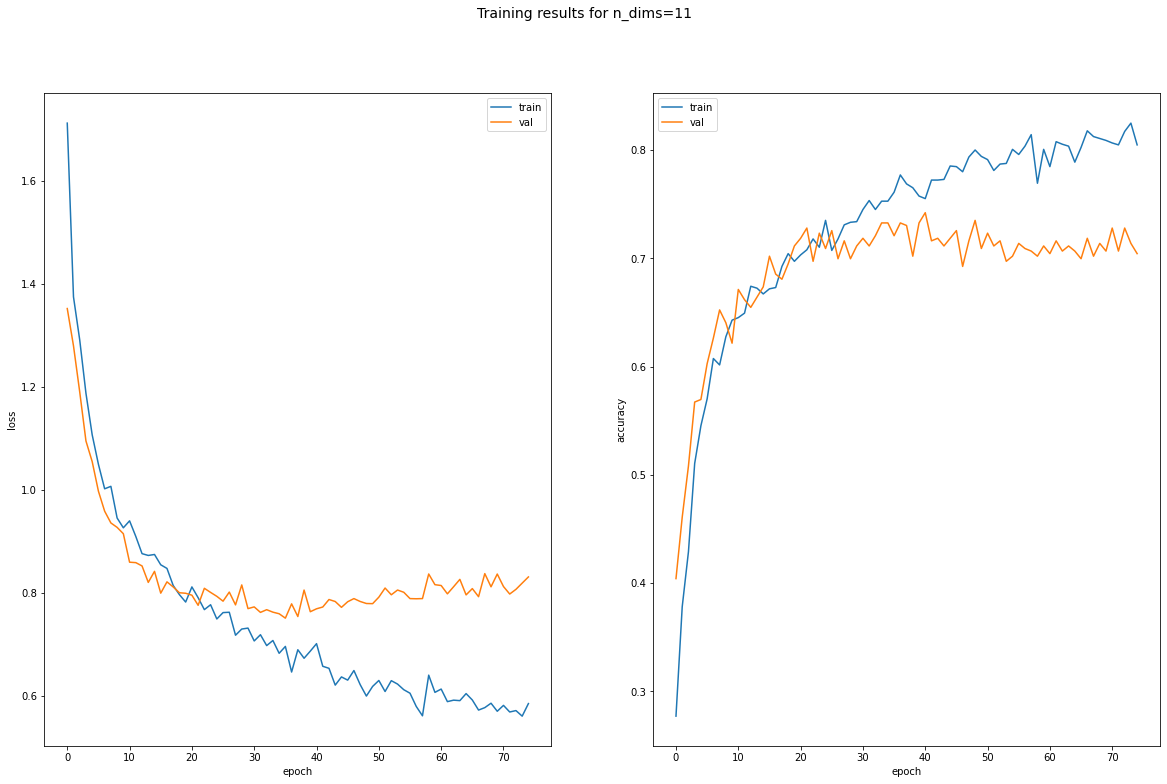

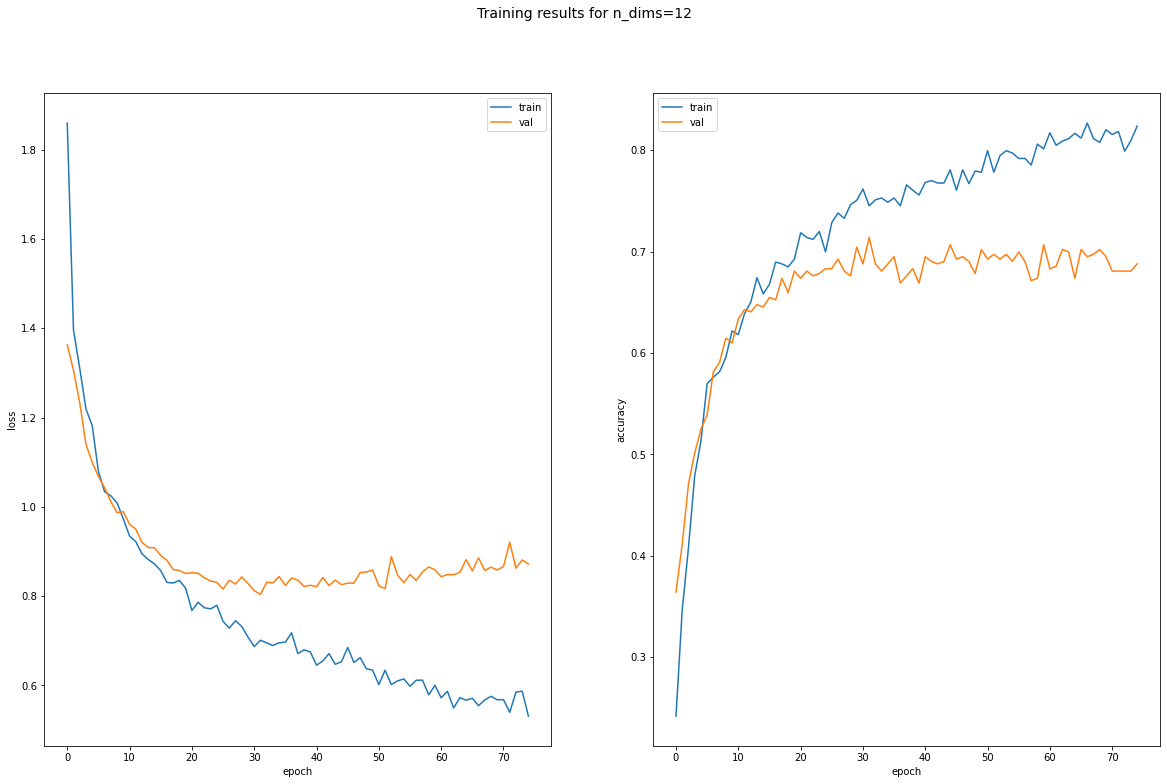

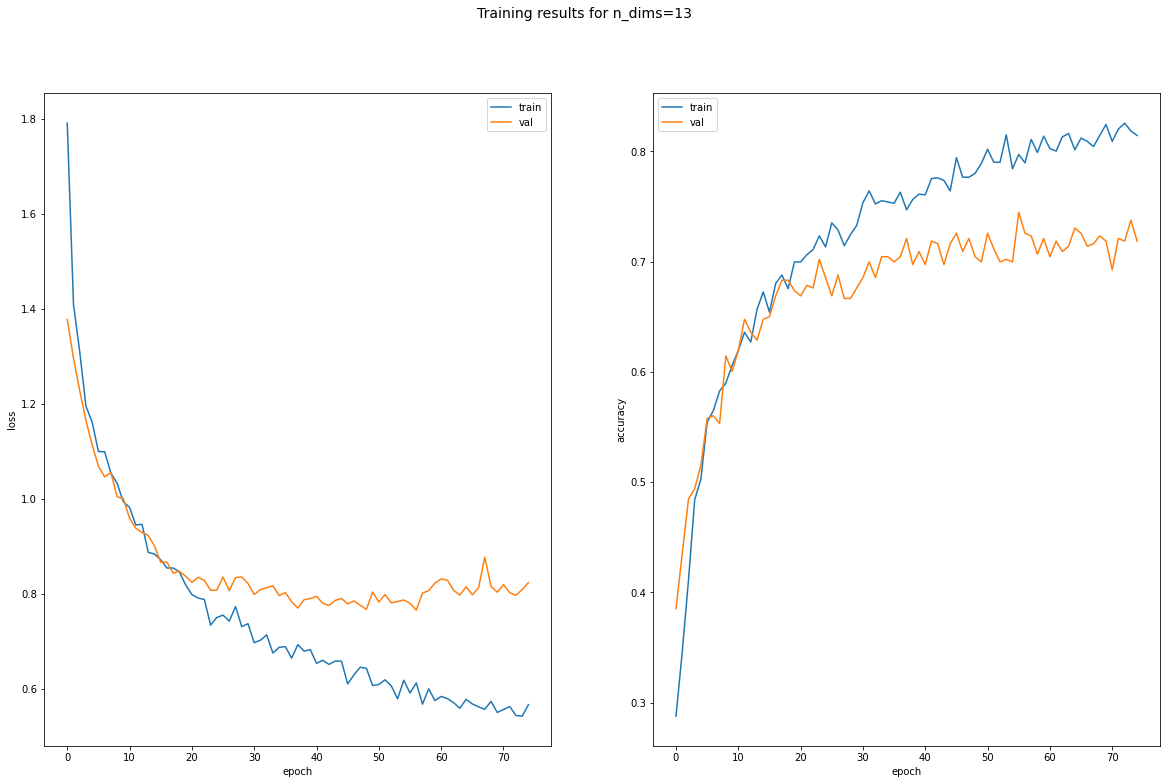

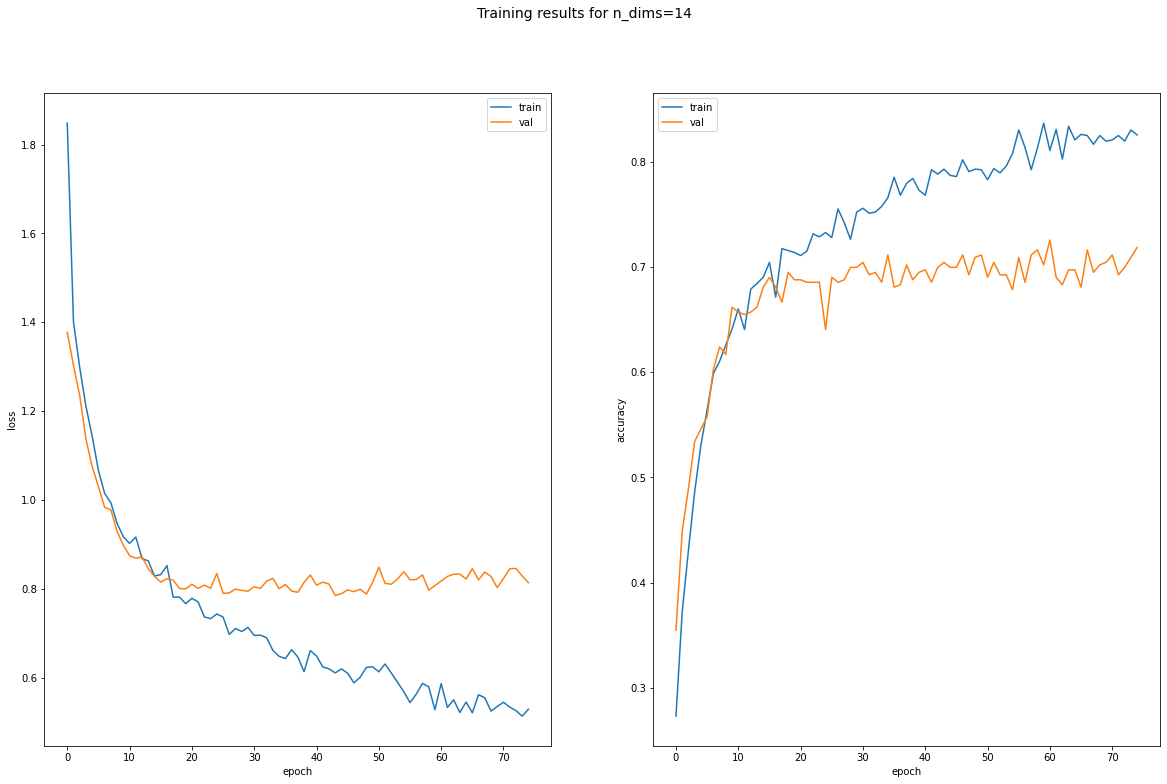

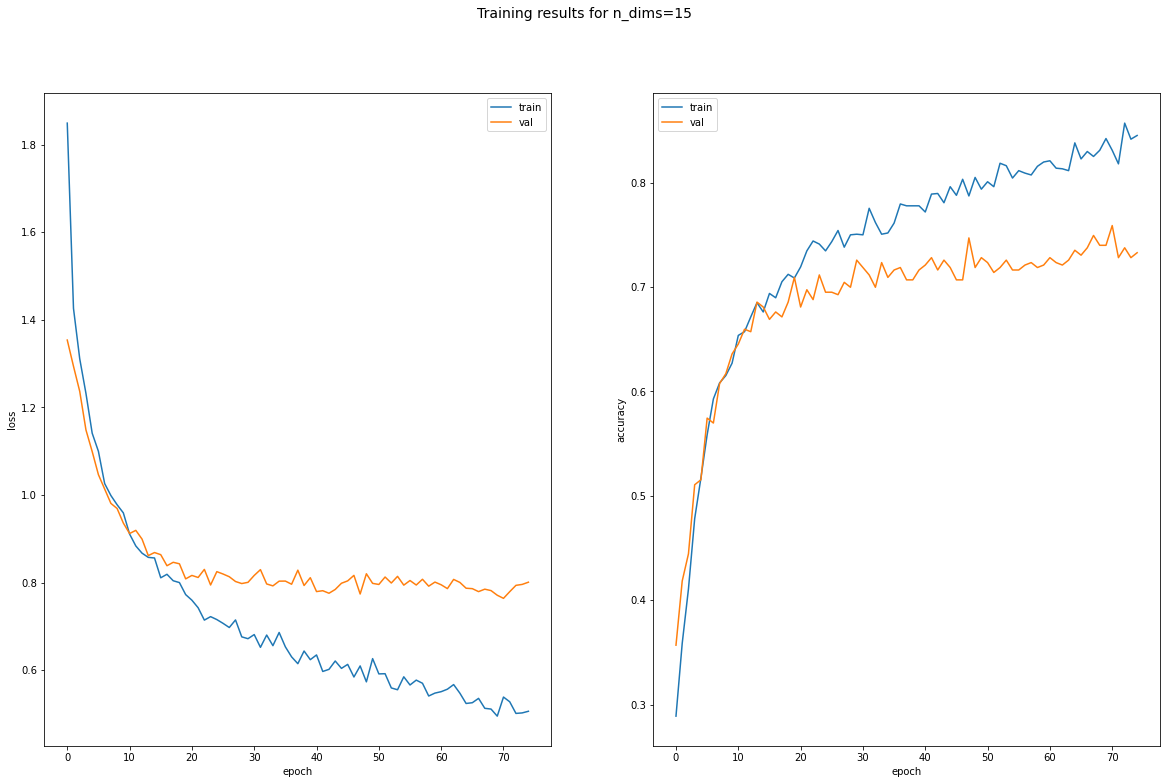

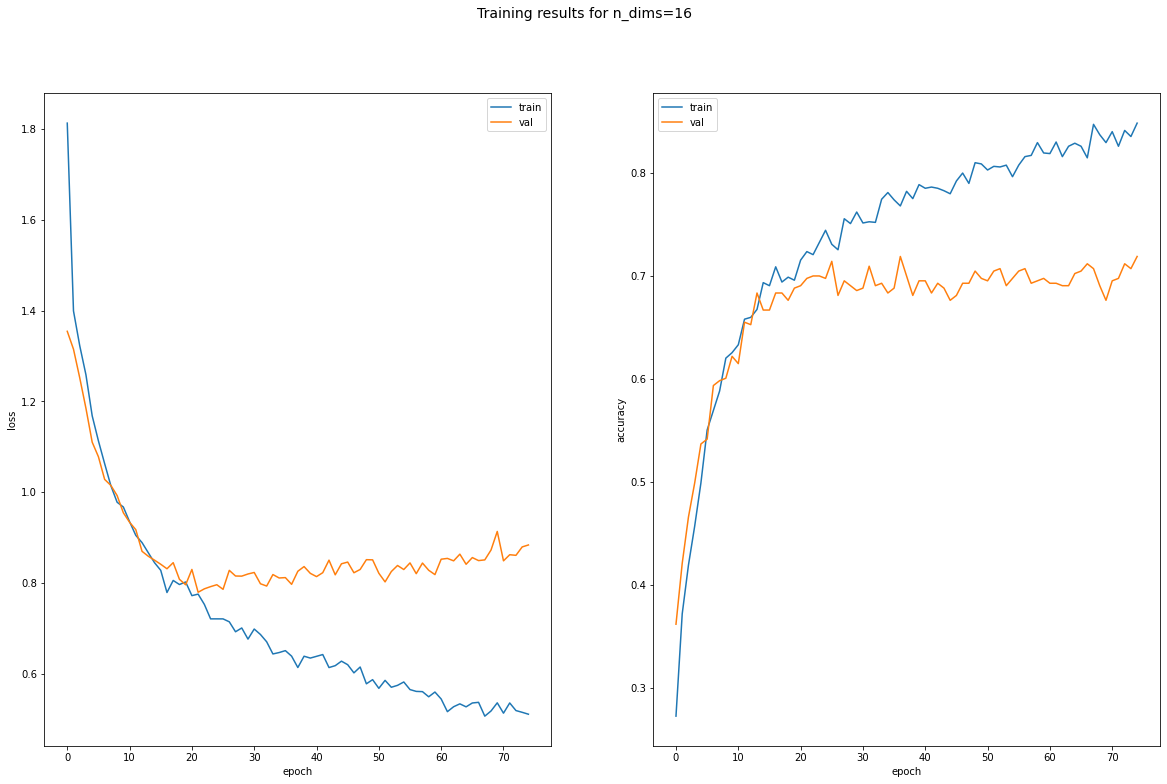

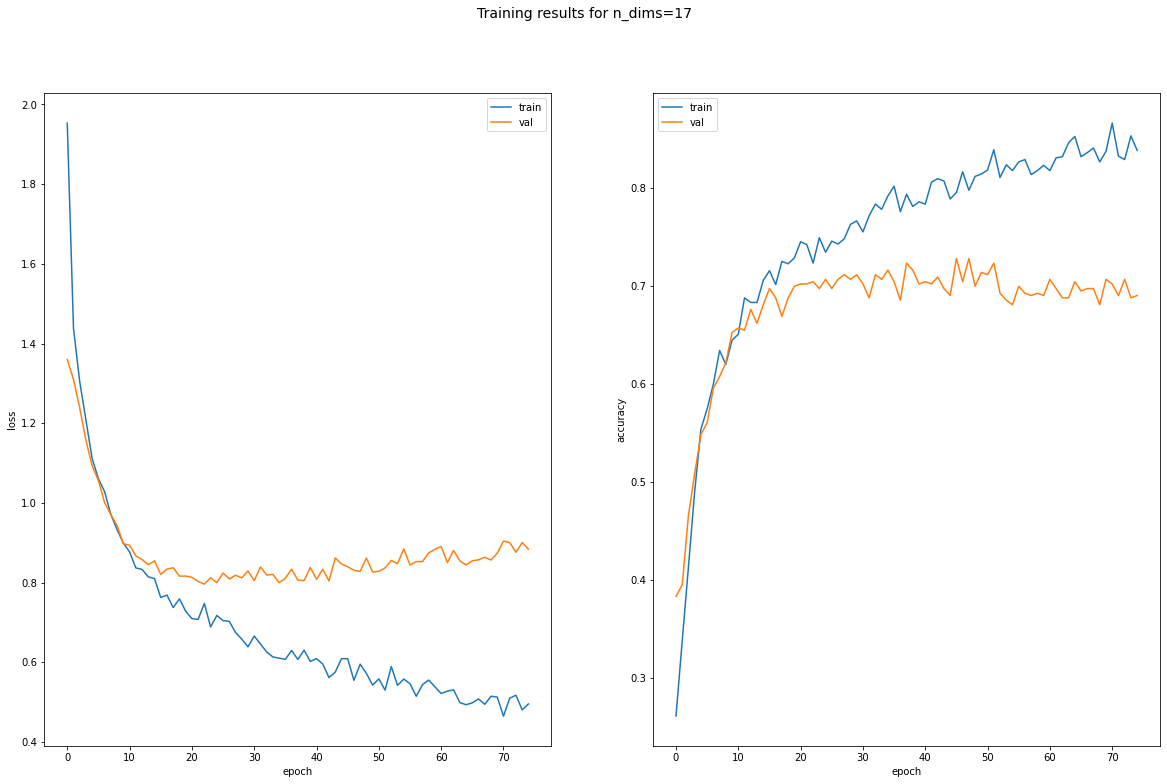

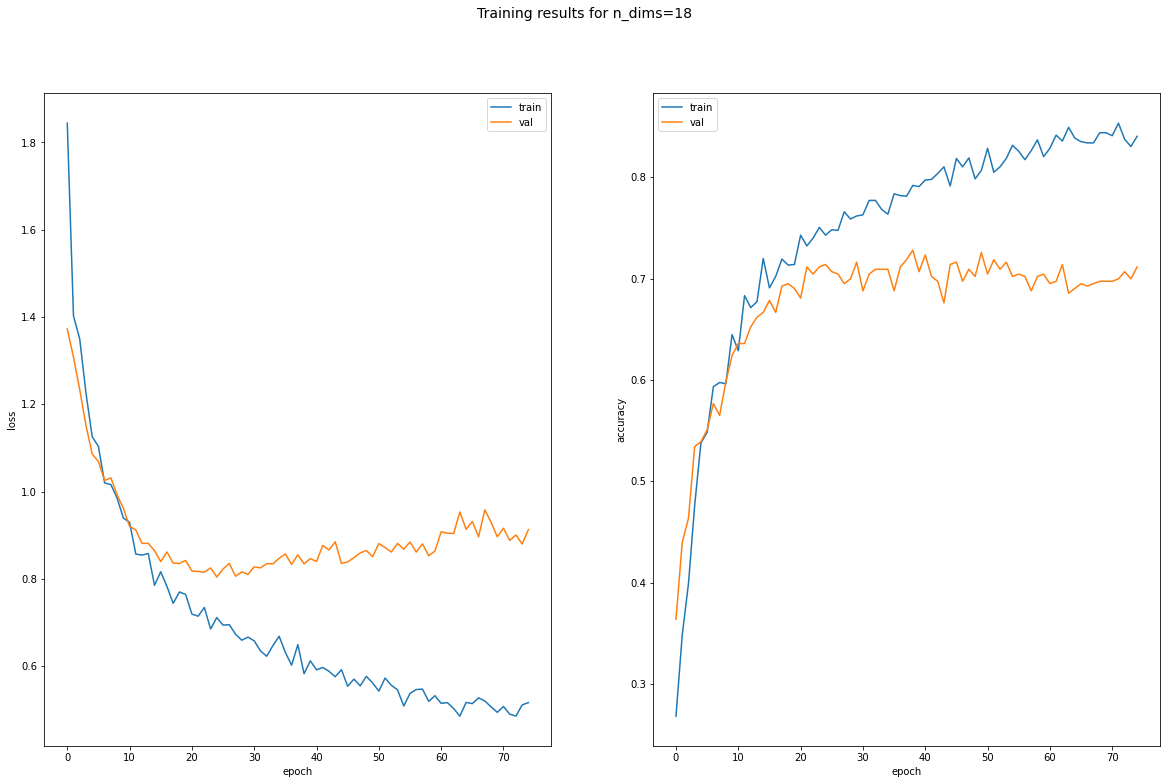

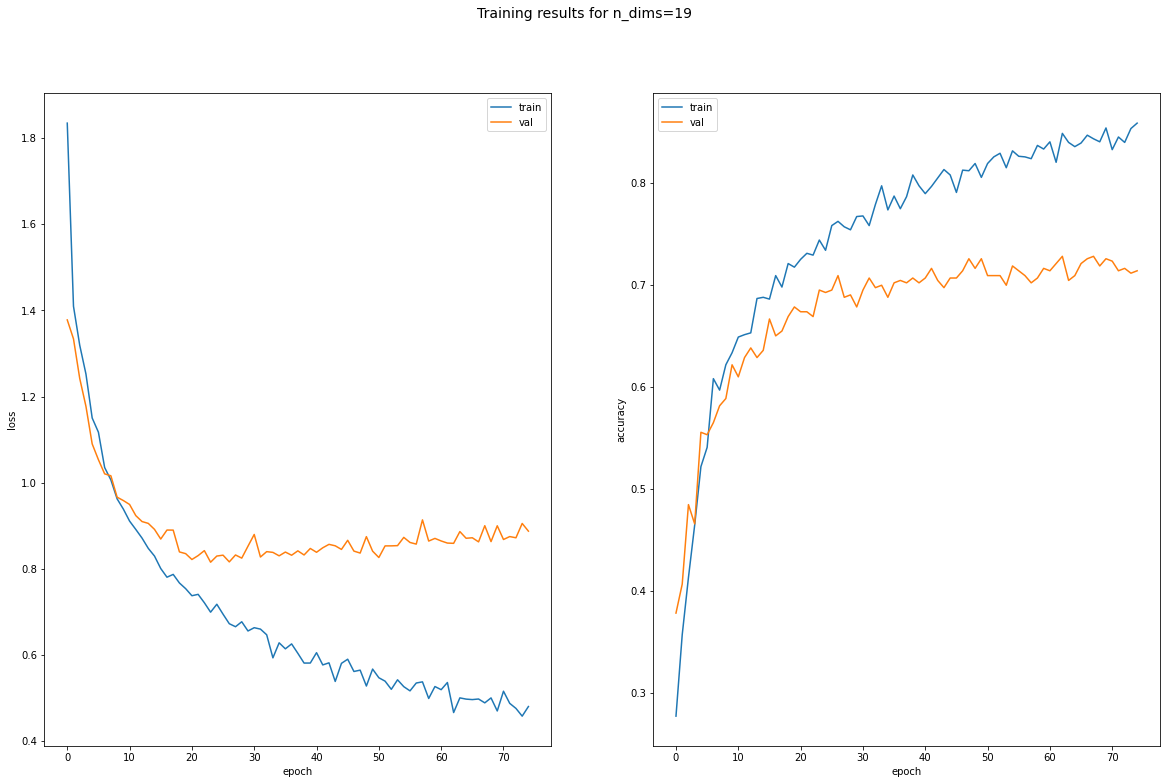

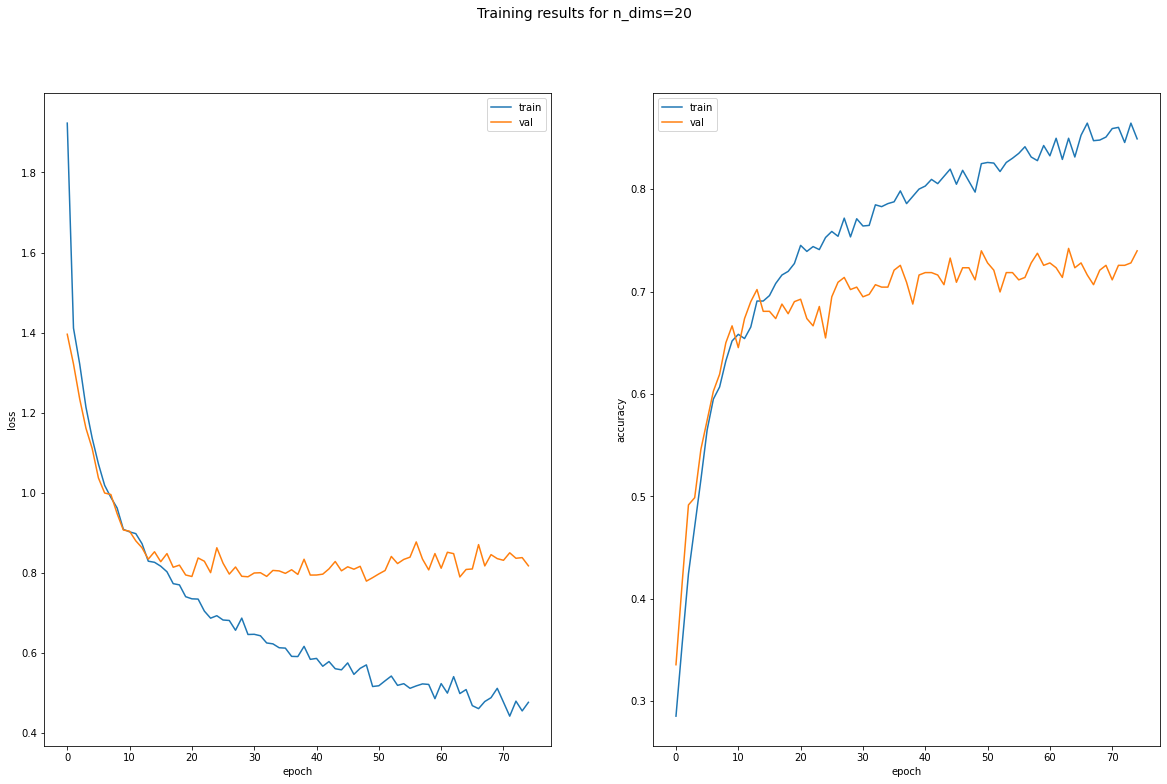

In [16]:
for n_comp in range(10, 21):
    print("Testing PCA Network for n_dims = {}".format(n_comp))
    
    X_train_valid_reshaped = X_train_valid_flipped.reshape((X_train_valid_norm_cropped.shape[0]*X_train_valid_norm_cropped.shape[2], 22)) 
    #print(X_train_valid_reshaped.shape)
    X_test_flipped = np.transpose(X_test_norm_cropped, (0,2,1))
    X_test_reshaped = X_test_flipped.reshape((X_test_norm_cropped.shape[0]*X_test_norm_cropped.shape[2], 22)) 


    #try a PCA on the data
    #reshaped_data = X_train_valid_flipped.reshape((X_train_valid_cropped.shape[1]*X_train_valid_cropped.shape[2], 22))    # create one big data panel with 20 series and 300.000 datapoints
                                          #choose the number of features to have after dimensionality reduction
    pca = PCA(n_components=n_comp)                  #create the pca object       
    pca.fit(X_train_valid_reshaped)                               #fit it to your transformed data
    X_train_valid_transformed=np.empty([X_train_valid_norm_cropped.shape[0],X_train_valid_norm_cropped.shape[2],n_comp])
    for i in range(len(X_train_valid_flipped)):
        #print(X_train_valid_flipped[i].shape)
        X_train_valid_transformed[i]=pca.transform(X_train_valid_flipped[i])           #iteratively apply the transformation to each instance of the original dataset


    #print(X_train_valid_transformed.shape)    #we end up with examples*timesteps*channels
    #now transpose back to examples*channels*timesteps
    X_train_valid_transformed = np.transpose(X_train_valid_transformed, (0,2,1))

    #n_comp=4                                      #choose the number of features to have after dimensionality reduction
    pca = PCA(n_components=n_comp)                  #create the pca object       
    pca.fit(X_test_reshaped)                               #fit it to your transformed data
    X_test_transformed=np.empty([X_test_norm_cropped.shape[0],X_test_norm_cropped.shape[2],n_comp])
    #print(X_test_transformed.shape)
    for i in range(len(X_test_flipped)):
        #print(X_test_flipped[i].shape)
        X_test_transformed[i]=pca.transform(X_test_flipped[i])           #iteratively apply the transformation to each instance of the original dataset

    #print(X_test_transformed.shape)    #we end up with examples*timesteps*channels
    #now transpose back to examples*channels*timesteps
    X_test_transformed = np.transpose(X_test_transformed, (0,2,1))
    
    input_ = layers.Input(shape=(n_comp, 500))
    r1 = layers.Reshape(target_shape=(n_comp, 500, 1))(input_)
    c1 = layers.Conv2D(filters=40, kernel_size=(1,25), data_format='channels_last',
                       activation='elu', kernel_regularizer='l2')(r1)
    p1 = layers.Permute(dims=(2,1,3))(c1)
    r2 = layers.Reshape((476, n_comp*40))(p1)
    d1 = layers.Dense(40, activation='elu')(r2)
    sq1 = layers.Activation(ksquare)(d1)
    ap1 = layers.AveragePooling1D(75, strides=15)(sq1)
    log1 = layers.Activation(klog)(ap1)
    f1 = layers.Flatten()(log1)
    d2 = layers.Dropout(0.80)(f1)
    output_ = layers.Dense(4, activation='softmax', kernel_regularizer='l2', kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01))(d2)
    
    model = models.Model(inputs=input_, outputs=output_, name='shallow_convnet_one_hot')
    #opt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    model.summary()
    
    loss_hist = model.fit(X_train_valid_transformed, y_train_valid_1h, 
                      validation_split=0.2, epochs=75,
                      verbose=True)

    hist = loss_hist.history

    fig, axs = plt.subplots(1,2, figsize=(20, 12))

    fig.suptitle("Training results for n_dims={}".format(n_comp), fontsize=14)

    axs[0].plot(hist['loss'])
    axs[0].plot(hist['val_loss'])
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'])

    axs[1].plot(hist['acc'])
    axs[1].plot(hist['val_acc'])
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'])
    
    

Testing PCA Network for n_dims = 8
Model: "shallow_convnet_one_hot"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 8, 500)]          0         
_________________________________________________________________
reshape_22 (Reshape)         (None, 8, 500, 1)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 476, 40)        1040      
_________________________________________________________________
permute_11 (Permute)         (None, 476, 8, 40)        0         
_________________________________________________________________
reshape_23 (Reshape)         (None, 476, 320)          0         
_________________________________________________________________
dense_22 (Dense)             (None, 476, 40)           12840     
_________________________________________________________________
activati

53/53 [==============================] - 0s 4ms/step - loss: 0.7835 - acc: 0.7264 - val_loss: 0.8804 - val_acc: 0.6667
Epoch 49/100
53/53 [==============================] - 0s 4ms/step - loss: 0.7718 - acc: 0.7281 - val_loss: 0.8693 - val_acc: 0.6809
Epoch 50/100
53/53 [==============================] - 0s 4ms/step - loss: 0.7373 - acc: 0.7435 - val_loss: 0.8873 - val_acc: 0.6761
Epoch 51/100
53/53 [==============================] - 0s 4ms/step - loss: 0.7503 - acc: 0.7264 - val_loss: 0.8770 - val_acc: 0.6809
Epoch 52/100
53/53 [==============================] - 0s 4ms/step - loss: 0.7234 - acc: 0.7429 - val_loss: 0.8970 - val_acc: 0.6643
Epoch 53/100
53/53 [==============================] - 0s 4ms/step - loss: 0.7730 - acc: 0.7169 - val_loss: 0.8953 - val_acc: 0.6809
Epoch 54/100
53/53 [==============================] - 0s 4ms/step - loss: 0.7395 - acc: 0.7352 - val_loss: 0.8921 - val_acc: 0.6832
Epoch 55/100
53/53 [==============================] - 0s 4ms/step - loss: 0.7557 - acc: 0

53/53 [==============================] - 0s 6ms/step - loss: 1.7167 - acc: 0.2707 - val_loss: 1.3689 - val_acc: 0.3546
Epoch 2/100
53/53 [==============================] - 0s 4ms/step - loss: 1.3860 - acc: 0.3623 - val_loss: 1.3049 - val_acc: 0.4208
Epoch 3/100
53/53 [==============================] - 0s 4ms/step - loss: 1.3240 - acc: 0.4125 - val_loss: 1.2335 - val_acc: 0.4870
Epoch 4/100
53/53 [==============================] - 0s 4ms/step - loss: 1.2508 - acc: 0.4604 - val_loss: 1.1759 - val_acc: 0.4965
Epoch 5/100
53/53 [==============================] - 0s 4ms/step - loss: 1.1760 - acc: 0.5089 - val_loss: 1.1416 - val_acc: 0.5201
Epoch 6/100
53/53 [==============================] - 0s 4ms/step - loss: 1.1405 - acc: 0.5201 - val_loss: 1.1079 - val_acc: 0.5225
Epoch 7/100
53/53 [==============================] - 0s 4ms/step - loss: 1.1010 - acc: 0.5573 - val_loss: 1.0848 - val_acc: 0.5650
Epoch 8/100
53/53 [==============================] - 0s 4ms/step - loss: 1.0707 - acc: 0.5833 -

53/53 [==============================] - 0s 4ms/step - loss: 0.6695 - acc: 0.7630 - val_loss: 0.8603 - val_acc: 0.6667
Epoch 64/100
53/53 [==============================] - 0s 4ms/step - loss: 0.6777 - acc: 0.7677 - val_loss: 0.8525 - val_acc: 0.6761
Epoch 65/100
53/53 [==============================] - 0s 4ms/step - loss: 0.6683 - acc: 0.7748 - val_loss: 0.8624 - val_acc: 0.6761
Epoch 66/100
53/53 [==============================] - 0s 4ms/step - loss: 0.6872 - acc: 0.7553 - val_loss: 0.8684 - val_acc: 0.6714
Epoch 67/100
53/53 [==============================] - 0s 4ms/step - loss: 0.6779 - acc: 0.7577 - val_loss: 0.8624 - val_acc: 0.6596
Epoch 68/100
53/53 [==============================] - 0s 4ms/step - loss: 0.6722 - acc: 0.7595 - val_loss: 0.8491 - val_acc: 0.6927
Epoch 69/100
53/53 [==============================] - 0s 4ms/step - loss: 0.6568 - acc: 0.7766 - val_loss: 0.8546 - val_acc: 0.6738
Epoch 70/100
53/53 [==============================] - 0s 4ms/step - loss: 0.6413 - acc: 0

53/53 [==============================] - 0s 4ms/step - loss: 0.9537 - acc: 0.6229 - val_loss: 0.9247 - val_acc: 0.6407
Epoch 11/100
53/53 [==============================] - 0s 4ms/step - loss: 0.9212 - acc: 0.6472 - val_loss: 0.8921 - val_acc: 0.6525
Epoch 12/100
53/53 [==============================] - 0s 4ms/step - loss: 0.9181 - acc: 0.6413 - val_loss: 0.8684 - val_acc: 0.6596
Epoch 13/100
53/53 [==============================] - 0s 4ms/step - loss: 0.9079 - acc: 0.6596 - val_loss: 0.8803 - val_acc: 0.6596
Epoch 14/100
53/53 [==============================] - 0s 4ms/step - loss: 0.8912 - acc: 0.6649 - val_loss: 0.8809 - val_acc: 0.6525
Epoch 15/100
53/53 [==============================] - 0s 4ms/step - loss: 0.8671 - acc: 0.6596 - val_loss: 0.8273 - val_acc: 0.6998
Epoch 16/100
53/53 [==============================] - 0s 4ms/step - loss: 0.8741 - acc: 0.6732 - val_loss: 0.8263 - val_acc: 0.6785
Epoch 17/100
53/53 [==============================] - 0s 4ms/step - loss: 0.8455 - acc: 0

53/53 [==============================] - 0s 4ms/step - loss: 0.6154 - acc: 0.7937 - val_loss: 0.8674 - val_acc: 0.6667
Epoch 73/100
53/53 [==============================] - 0s 4ms/step - loss: 0.6240 - acc: 0.7890 - val_loss: 0.8588 - val_acc: 0.6832
Epoch 74/100
53/53 [==============================] - 0s 4ms/step - loss: 0.6032 - acc: 0.7961 - val_loss: 0.8740 - val_acc: 0.6903
Epoch 75/100
53/53 [==============================] - 0s 4ms/step - loss: 0.6043 - acc: 0.8008 - val_loss: 0.8778 - val_acc: 0.6690
Epoch 76/100
53/53 [==============================] - 0s 4ms/step - loss: 0.5683 - acc: 0.7996 - val_loss: 0.8640 - val_acc: 0.6856
Epoch 77/100
53/53 [==============================] - 0s 4ms/step - loss: 0.5857 - acc: 0.8067 - val_loss: 0.8598 - val_acc: 0.6714
Epoch 78/100
53/53 [==============================] - 0s 4ms/step - loss: 0.6084 - acc: 0.8038 - val_loss: 0.8734 - val_acc: 0.6714
Epoch 79/100
53/53 [==============================] - 0s 4ms/step - loss: 0.5766 - acc: 0

53/53 [==============================] - 0s 4ms/step - loss: 0.8125 - acc: 0.6868 - val_loss: 0.8469 - val_acc: 0.6596
Epoch 20/100
53/53 [==============================] - 0s 4ms/step - loss: 0.7963 - acc: 0.7009 - val_loss: 0.8535 - val_acc: 0.6785
Epoch 21/100
53/53 [==============================] - 0s 4ms/step - loss: 0.8003 - acc: 0.7139 - val_loss: 0.8489 - val_acc: 0.6738
Epoch 22/100
53/53 [==============================] - 0s 5ms/step - loss: 0.7810 - acc: 0.7098 - val_loss: 0.8371 - val_acc: 0.6856
Epoch 23/100
53/53 [==============================] - 0s 4ms/step - loss: 0.7845 - acc: 0.7015 - val_loss: 0.8467 - val_acc: 0.6785
Epoch 24/100
53/53 [==============================] - 0s 4ms/step - loss: 0.7437 - acc: 0.7264 - val_loss: 0.8407 - val_acc: 0.6903
Epoch 25/100
53/53 [==============================] - 0s 4ms/step - loss: 0.7687 - acc: 0.7222 - val_loss: 0.8432 - val_acc: 0.6785
Epoch 26/100
53/53 [==============================] - 0s 4ms/step - loss: 0.7265 - acc: 0

53/53 [==============================] - 0s 4ms/step - loss: 0.5244 - acc: 0.8387 - val_loss: 0.8647 - val_acc: 0.7163
Epoch 82/100
53/53 [==============================] - 0s 4ms/step - loss: 0.5670 - acc: 0.8126 - val_loss: 0.8496 - val_acc: 0.7258
Epoch 83/100
53/53 [==============================] - 0s 4ms/step - loss: 0.5600 - acc: 0.8233 - val_loss: 0.8330 - val_acc: 0.7163
Epoch 84/100
53/53 [==============================] - 0s 4ms/step - loss: 0.5640 - acc: 0.8186 - val_loss: 0.8397 - val_acc: 0.7139
Epoch 85/100
53/53 [==============================] - 0s 4ms/step - loss: 0.5572 - acc: 0.8168 - val_loss: 0.8513 - val_acc: 0.7116
Epoch 86/100
53/53 [==============================] - 0s 4ms/step - loss: 0.5505 - acc: 0.8209 - val_loss: 0.8478 - val_acc: 0.7116
Epoch 87/100
53/53 [==============================] - 0s 4ms/step - loss: 0.5343 - acc: 0.8215 - val_loss: 0.8839 - val_acc: 0.7139
Epoch 88/100
53/53 [==============================] - 0s 4ms/step - loss: 0.5102 - acc: 0

53/53 [==============================] - 0s 4ms/step - loss: 0.7433 - acc: 0.7317 - val_loss: 0.8060 - val_acc: 0.7045
Epoch 29/100
53/53 [==============================] - 0s 5ms/step - loss: 0.7402 - acc: 0.7264 - val_loss: 0.8317 - val_acc: 0.6903
Epoch 30/100
53/53 [==============================] - 0s 5ms/step - loss: 0.7256 - acc: 0.7405 - val_loss: 0.8116 - val_acc: 0.7139
Epoch 31/100
53/53 [==============================] - 0s 5ms/step - loss: 0.7057 - acc: 0.7405 - val_loss: 0.8256 - val_acc: 0.6998
Epoch 32/100
53/53 [==============================] - 0s 5ms/step - loss: 0.6680 - acc: 0.7518 - val_loss: 0.8220 - val_acc: 0.7045
Epoch 33/100
53/53 [==============================] - 0s 5ms/step - loss: 0.7159 - acc: 0.7453 - val_loss: 0.8224 - val_acc: 0.7021
Epoch 34/100
53/53 [==============================] - 0s 5ms/step - loss: 0.6733 - acc: 0.7725 - val_loss: 0.8196 - val_acc: 0.7069
Epoch 35/100
53/53 [==============================] - 0s 4ms/step - loss: 0.6928 - acc: 0

53/53 [==============================] - 0s 4ms/step - loss: 0.5232 - acc: 0.8387 - val_loss: 0.8515 - val_acc: 0.6950
Epoch 91/100
53/53 [==============================] - 0s 4ms/step - loss: 0.5077 - acc: 0.8363 - val_loss: 0.8704 - val_acc: 0.7045
Epoch 92/100
53/53 [==============================] - 0s 4ms/step - loss: 0.5050 - acc: 0.8392 - val_loss: 0.8950 - val_acc: 0.7021
Epoch 93/100
53/53 [==============================] - 0s 4ms/step - loss: 0.5033 - acc: 0.8517 - val_loss: 0.8836 - val_acc: 0.7069
Epoch 94/100
53/53 [==============================] - 0s 5ms/step - loss: 0.5091 - acc: 0.8333 - val_loss: 0.8864 - val_acc: 0.6974
Epoch 95/100
53/53 [==============================] - 0s 5ms/step - loss: 0.5279 - acc: 0.8351 - val_loss: 0.8909 - val_acc: 0.6903
Epoch 96/100
53/53 [==============================] - 0s 4ms/step - loss: 0.5071 - acc: 0.8440 - val_loss: 0.9145 - val_acc: 0.6714
Epoch 97/100
53/53 [==============================] - 0s 4ms/step - loss: 0.5201 - acc: 0

53/53 [==============================] - 0s 5ms/step - loss: 0.6617 - acc: 0.7630 - val_loss: 0.8230 - val_acc: 0.7021
Epoch 38/100
53/53 [==============================] - 0s 5ms/step - loss: 0.6810 - acc: 0.7476 - val_loss: 0.8069 - val_acc: 0.6950
Epoch 39/100
53/53 [==============================] - 0s 5ms/step - loss: 0.6403 - acc: 0.7884 - val_loss: 0.8256 - val_acc: 0.7069
Epoch 40/100
53/53 [==============================] - 0s 4ms/step - loss: 0.6606 - acc: 0.7701 - val_loss: 0.8192 - val_acc: 0.7092
Epoch 41/100
53/53 [==============================] - 0s 5ms/step - loss: 0.6648 - acc: 0.7624 - val_loss: 0.8392 - val_acc: 0.7045
Epoch 42/100
53/53 [==============================] - 0s 4ms/step - loss: 0.6507 - acc: 0.7707 - val_loss: 0.8138 - val_acc: 0.7210
Epoch 43/100
53/53 [==============================] - 0s 5ms/step - loss: 0.5898 - acc: 0.7979 - val_loss: 0.7954 - val_acc: 0.7163
Epoch 44/100
53/53 [==============================] - 0s 5ms/step - loss: 0.6331 - acc: 0

53/53 [==============================] - 0s 5ms/step - loss: 0.5084 - acc: 0.8333 - val_loss: 0.8629 - val_acc: 0.7210
Epoch 100/100
53/53 [==============================] - 0s 5ms/step - loss: 0.5086 - acc: 0.8452 - val_loss: 0.8682 - val_acc: 0.7139
Testing PCA Network for n_dims = 14
Model: "shallow_convnet_one_hot"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 14, 500)]         0         
_________________________________________________________________
reshape_34 (Reshape)         (None, 14, 500, 1)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 476, 40)       1040      
_________________________________________________________________
permute_17 (Permute)         (None, 476, 14, 40)       0         
_________________________________________________________________
reshape_35 (Reshape

53/53 [==============================] - 0s 5ms/step - loss: 0.5872 - acc: 0.8168 - val_loss: 0.8187 - val_acc: 0.7092
Epoch 47/100
53/53 [==============================] - 0s 5ms/step - loss: 0.6132 - acc: 0.7926 - val_loss: 0.7871 - val_acc: 0.7187
Epoch 48/100
53/53 [==============================] - 0s 5ms/step - loss: 0.5931 - acc: 0.7996 - val_loss: 0.8023 - val_acc: 0.7045
Epoch 49/100
53/53 [==============================] - 0s 5ms/step - loss: 0.5723 - acc: 0.8008 - val_loss: 0.8130 - val_acc: 0.6974
Epoch 50/100
53/53 [==============================] - 0s 5ms/step - loss: 0.5876 - acc: 0.7878 - val_loss: 0.8008 - val_acc: 0.6974
Epoch 51/100
53/53 [==============================] - 0s 5ms/step - loss: 0.5856 - acc: 0.8050 - val_loss: 0.7981 - val_acc: 0.7139
Epoch 52/100
53/53 [==============================] - 0s 5ms/step - loss: 0.5818 - acc: 0.8126 - val_loss: 0.8218 - val_acc: 0.7258
Epoch 53/100
53/53 [==============================] - 0s 5ms/step - loss: 0.5576 - acc: 0

Epoch 1/100
53/53 [==============================] - 0s 7ms/step - loss: 1.8363 - acc: 0.2654 - val_loss: 1.3629 - val_acc: 0.3522
Epoch 2/100
53/53 [==============================] - 0s 5ms/step - loss: 1.3951 - acc: 0.3522 - val_loss: 1.2940 - val_acc: 0.4444
Epoch 3/100
53/53 [==============================] - 0s 5ms/step - loss: 1.2945 - acc: 0.4415 - val_loss: 1.2164 - val_acc: 0.4846
Epoch 4/100
53/53 [==============================] - 0s 5ms/step - loss: 1.2174 - acc: 0.4793 - val_loss: 1.1468 - val_acc: 0.4965
Epoch 5/100
53/53 [==============================] - 0s 5ms/step - loss: 1.1503 - acc: 0.5148 - val_loss: 1.0993 - val_acc: 0.5319
Epoch 6/100
53/53 [==============================] - 1s 9ms/step - loss: 1.0882 - acc: 0.5431 - val_loss: 1.0542 - val_acc: 0.5532
Epoch 7/100
53/53 [==============================] - 0s 5ms/step - loss: 1.0386 - acc: 0.5845 - val_loss: 1.0164 - val_acc: 0.5816
Epoch 8/100
53/53 [==============================] - 0s 5ms/step - loss: 0.9884 - a

53/53 [==============================] - 0s 5ms/step - loss: 0.5544 - acc: 0.8245 - val_loss: 0.8021 - val_acc: 0.7045
Epoch 64/100
53/53 [==============================] - 0s 5ms/step - loss: 0.5520 - acc: 0.8156 - val_loss: 0.8222 - val_acc: 0.6974
Epoch 65/100
53/53 [==============================] - 0s 5ms/step - loss: 0.5311 - acc: 0.8233 - val_loss: 0.8152 - val_acc: 0.7021
Epoch 66/100
53/53 [==============================] - 0s 5ms/step - loss: 0.5294 - acc: 0.8239 - val_loss: 0.8206 - val_acc: 0.7139
Epoch 67/100
53/53 [==============================] - 0s 5ms/step - loss: 0.5419 - acc: 0.8209 - val_loss: 0.8309 - val_acc: 0.7021
Epoch 68/100
53/53 [==============================] - 0s 5ms/step - loss: 0.5415 - acc: 0.8274 - val_loss: 0.8252 - val_acc: 0.7092
Epoch 69/100
53/53 [==============================] - 0s 5ms/step - loss: 0.5215 - acc: 0.8298 - val_loss: 0.8414 - val_acc: 0.7021
Epoch 70/100
53/53 [==============================] - 0s 5ms/step - loss: 0.5417 - acc: 0

53/53 [==============================] - 0s 5ms/step - loss: 0.8982 - acc: 0.6560 - val_loss: 0.8863 - val_acc: 0.6596
Epoch 11/100
53/53 [==============================] - 0s 5ms/step - loss: 0.8799 - acc: 0.6543 - val_loss: 0.8893 - val_acc: 0.6430
Epoch 12/100
53/53 [==============================] - 0s 5ms/step - loss: 0.8350 - acc: 0.6755 - val_loss: 0.8668 - val_acc: 0.6548
Epoch 13/100
53/53 [==============================] - 0s 5ms/step - loss: 0.8483 - acc: 0.6767 - val_loss: 0.8542 - val_acc: 0.6714
Epoch 14/100
53/53 [==============================] - 0s 5ms/step - loss: 0.8099 - acc: 0.6956 - val_loss: 0.8381 - val_acc: 0.6809
Epoch 15/100
53/53 [==============================] - 0s 5ms/step - loss: 0.8171 - acc: 0.6791 - val_loss: 0.8082 - val_acc: 0.6761
Epoch 16/100
53/53 [==============================] - 0s 5ms/step - loss: 0.8124 - acc: 0.7015 - val_loss: 0.8197 - val_acc: 0.6832
Epoch 17/100
53/53 [==============================] - 0s 5ms/step - loss: 0.8000 - acc: 0

53/53 [==============================] - 0s 6ms/step - loss: 0.5119 - acc: 0.8333 - val_loss: 0.8359 - val_acc: 0.7116
Epoch 73/100
53/53 [==============================] - 0s 5ms/step - loss: 0.5142 - acc: 0.8298 - val_loss: 0.8238 - val_acc: 0.7187
Epoch 74/100
53/53 [==============================] - 0s 5ms/step - loss: 0.4998 - acc: 0.8404 - val_loss: 0.8266 - val_acc: 0.7116
Epoch 75/100
53/53 [==============================] - 0s 6ms/step - loss: 0.5060 - acc: 0.8387 - val_loss: 0.8416 - val_acc: 0.7045
Epoch 76/100
53/53 [==============================] - 0s 5ms/step - loss: 0.5065 - acc: 0.8446 - val_loss: 0.8693 - val_acc: 0.7092
Epoch 77/100
53/53 [==============================] - 0s 5ms/step - loss: 0.5027 - acc: 0.8475 - val_loss: 0.8079 - val_acc: 0.7258
Epoch 78/100
53/53 [==============================] - 0s 6ms/step - loss: 0.4744 - acc: 0.8641 - val_loss: 0.8282 - val_acc: 0.7234
Epoch 79/100
53/53 [==============================] - 0s 6ms/step - loss: 0.5065 - acc: 0

53/53 [==============================] - 0s 6ms/step - loss: 0.7744 - acc: 0.7021 - val_loss: 0.8150 - val_acc: 0.6832
Epoch 20/100
53/53 [==============================] - 0s 5ms/step - loss: 0.7526 - acc: 0.7116 - val_loss: 0.8241 - val_acc: 0.6785
Epoch 21/100
53/53 [==============================] - 0s 5ms/step - loss: 0.7492 - acc: 0.7335 - val_loss: 0.8329 - val_acc: 0.6761
Epoch 22/100
53/53 [==============================] - 0s 6ms/step - loss: 0.7318 - acc: 0.7275 - val_loss: 0.8213 - val_acc: 0.6809
Epoch 23/100
53/53 [==============================] - 0s 6ms/step - loss: 0.7190 - acc: 0.7494 - val_loss: 0.8192 - val_acc: 0.6832
Epoch 24/100
53/53 [==============================] - 0s 5ms/step - loss: 0.7087 - acc: 0.7447 - val_loss: 0.8145 - val_acc: 0.6832
Epoch 25/100
53/53 [==============================] - 0s 5ms/step - loss: 0.7092 - acc: 0.7435 - val_loss: 0.8163 - val_acc: 0.6809
Epoch 26/100
53/53 [==============================] - 0s 5ms/step - loss: 0.7026 - acc: 0

53/53 [==============================] - 0s 5ms/step - loss: 0.4978 - acc: 0.8440 - val_loss: 0.8895 - val_acc: 0.6856
Epoch 82/100
53/53 [==============================] - 0s 6ms/step - loss: 0.5175 - acc: 0.8357 - val_loss: 0.8741 - val_acc: 0.6950
Epoch 83/100
53/53 [==============================] - 0s 5ms/step - loss: 0.4682 - acc: 0.8481 - val_loss: 0.8662 - val_acc: 0.6998
Epoch 84/100
53/53 [==============================] - 0s 5ms/step - loss: 0.5225 - acc: 0.8392 - val_loss: 0.8698 - val_acc: 0.6974
Epoch 85/100
53/53 [==============================] - 0s 5ms/step - loss: 0.4764 - acc: 0.8505 - val_loss: 0.8673 - val_acc: 0.6903
Epoch 86/100
53/53 [==============================] - 0s 5ms/step - loss: 0.4577 - acc: 0.8611 - val_loss: 0.9009 - val_acc: 0.6785
Epoch 87/100
53/53 [==============================] - 0s 5ms/step - loss: 0.4788 - acc: 0.8511 - val_loss: 0.9091 - val_acc: 0.6974
Epoch 88/100
53/53 [==============================] - 0s 5ms/step - loss: 0.5160 - acc: 0

53/53 [==============================] - 0s 6ms/step - loss: 0.6934 - acc: 0.7476 - val_loss: 0.7928 - val_acc: 0.6785
Epoch 29/100
53/53 [==============================] - 0s 6ms/step - loss: 0.6537 - acc: 0.7719 - val_loss: 0.8050 - val_acc: 0.6809
Epoch 30/100
53/53 [==============================] - 0s 6ms/step - loss: 0.6730 - acc: 0.7618 - val_loss: 0.7969 - val_acc: 0.6714
Epoch 31/100
53/53 [==============================] - 0s 6ms/step - loss: 0.6835 - acc: 0.7583 - val_loss: 0.8027 - val_acc: 0.6738
Epoch 32/100
53/53 [==============================] - 0s 6ms/step - loss: 0.6618 - acc: 0.7642 - val_loss: 0.8040 - val_acc: 0.6785
Epoch 33/100
53/53 [==============================] - 0s 6ms/step - loss: 0.6500 - acc: 0.7701 - val_loss: 0.8195 - val_acc: 0.6856
Epoch 34/100
53/53 [==============================] - 0s 6ms/step - loss: 0.6383 - acc: 0.7778 - val_loss: 0.8003 - val_acc: 0.6950
Epoch 35/100
53/53 [==============================] - 0s 6ms/step - loss: 0.6301 - acc: 0

53/53 [==============================] - 0s 6ms/step - loss: 0.4370 - acc: 0.8788 - val_loss: 0.8830 - val_acc: 0.6950
Epoch 91/100
53/53 [==============================] - 0s 6ms/step - loss: 0.4616 - acc: 0.8676 - val_loss: 0.8672 - val_acc: 0.6974
Epoch 92/100
53/53 [==============================] - 0s 6ms/step - loss: 0.4637 - acc: 0.8605 - val_loss: 0.8717 - val_acc: 0.7021
Epoch 93/100
53/53 [==============================] - 0s 6ms/step - loss: 0.4371 - acc: 0.8706 - val_loss: 0.8366 - val_acc: 0.7187
Epoch 94/100
53/53 [==============================] - 0s 6ms/step - loss: 0.4425 - acc: 0.8765 - val_loss: 0.8757 - val_acc: 0.6927
Epoch 95/100
53/53 [==============================] - 0s 6ms/step - loss: 0.4616 - acc: 0.8729 - val_loss: 0.8584 - val_acc: 0.7069
Epoch 96/100
53/53 [==============================] - 0s 6ms/step - loss: 0.4322 - acc: 0.8765 - val_loss: 0.8989 - val_acc: 0.7116
Epoch 97/100
53/53 [==============================] - 0s 6ms/step - loss: 0.4479 - acc: 0

53/53 [==============================] - 0s 6ms/step - loss: 0.6117 - acc: 0.7707 - val_loss: 0.8026 - val_acc: 0.7045
Epoch 38/100
53/53 [==============================] - 0s 6ms/step - loss: 0.5854 - acc: 0.7955 - val_loss: 0.8195 - val_acc: 0.6903
Epoch 39/100
53/53 [==============================] - 0s 6ms/step - loss: 0.6235 - acc: 0.7884 - val_loss: 0.8008 - val_acc: 0.7163
Epoch 40/100
53/53 [==============================] - 0s 6ms/step - loss: 0.6061 - acc: 0.7866 - val_loss: 0.8203 - val_acc: 0.7069
Epoch 41/100
53/53 [==============================] - 0s 6ms/step - loss: 0.5916 - acc: 0.7949 - val_loss: 0.8352 - val_acc: 0.6903
Epoch 42/100
53/53 [==============================] - 1s 10ms/step - loss: 0.5844 - acc: 0.7902 - val_loss: 0.8386 - val_acc: 0.7069
Epoch 43/100
53/53 [==============================] - 0s 6ms/step - loss: 0.5957 - acc: 0.8002 - val_loss: 0.8278 - val_acc: 0.7069
Epoch 44/100
53/53 [==============================] - 0s 6ms/step - loss: 0.5893 - acc: 

53/53 [==============================] - 0s 6ms/step - loss: 0.4654 - acc: 0.8599 - val_loss: 0.9377 - val_acc: 0.6927
Epoch 100/100
53/53 [==============================] - 0s 6ms/step - loss: 0.4362 - acc: 0.8877 - val_loss: 0.9077 - val_acc: 0.6927
Testing PCA Network for n_dims = 20
Model: "shallow_convnet_one_hot"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 20, 500)]         0         
_________________________________________________________________
reshape_46 (Reshape)         (None, 20, 500, 1)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 20, 476, 40)       1040      
_________________________________________________________________
permute_23 (Permute)         (None, 476, 20, 40)       0         
_________________________________________________________________
reshape_47 (Reshape

53/53 [==============================] - 0s 6ms/step - loss: 0.5592 - acc: 0.8050 - val_loss: 0.8299 - val_acc: 0.6809
Epoch 47/100
53/53 [==============================] - 0s 6ms/step - loss: 0.5649 - acc: 0.7996 - val_loss: 0.8194 - val_acc: 0.6879
Epoch 48/100
53/53 [==============================] - 0s 6ms/step - loss: 0.5570 - acc: 0.8091 - val_loss: 0.8096 - val_acc: 0.7021
Epoch 49/100
53/53 [==============================] - 0s 6ms/step - loss: 0.5538 - acc: 0.8038 - val_loss: 0.8155 - val_acc: 0.7045
Epoch 50/100
53/53 [==============================] - 0s 6ms/step - loss: 0.5569 - acc: 0.8162 - val_loss: 0.8414 - val_acc: 0.6974
Epoch 51/100
53/53 [==============================] - 0s 6ms/step - loss: 0.5417 - acc: 0.8268 - val_loss: 0.8441 - val_acc: 0.6950
Epoch 52/100
53/53 [==============================] - 0s 6ms/step - loss: 0.5343 - acc: 0.8174 - val_loss: 0.8424 - val_acc: 0.6785
Epoch 53/100
53/53 [==============================] - 0s 7ms/step - loss: 0.5100 - acc: 0

Epoch 1/100
53/53 [==============================] - 0s 8ms/step - loss: 1.8749 - acc: 0.2725 - val_loss: 1.3702 - val_acc: 0.3357
Epoch 2/100
53/53 [==============================] - 0s 6ms/step - loss: 1.4119 - acc: 0.3410 - val_loss: 1.3266 - val_acc: 0.4043
Epoch 3/100
53/53 [==============================] - 0s 6ms/step - loss: 1.3355 - acc: 0.3913 - val_loss: 1.2621 - val_acc: 0.4492
Epoch 4/100
53/53 [==============================] - 0s 6ms/step - loss: 1.2551 - acc: 0.4574 - val_loss: 1.1747 - val_acc: 0.5177
Epoch 5/100
53/53 [==============================] - 0s 6ms/step - loss: 1.1752 - acc: 0.5083 - val_loss: 1.0948 - val_acc: 0.5579
Epoch 6/100
53/53 [==============================] - 0s 6ms/step - loss: 1.0904 - acc: 0.5603 - val_loss: 1.0414 - val_acc: 0.5957
Epoch 7/100
53/53 [==============================] - 0s 6ms/step - loss: 1.0464 - acc: 0.5892 - val_loss: 1.0320 - val_acc: 0.5910
Epoch 8/100
53/53 [==============================] - 0s 6ms/step - loss: 0.9831 - a

53/53 [==============================] - 0s 6ms/step - loss: 0.4878 - acc: 0.8392 - val_loss: 0.8519 - val_acc: 0.7187
Epoch 64/100
53/53 [==============================] - 0s 6ms/step - loss: 0.4957 - acc: 0.8351 - val_loss: 0.8187 - val_acc: 0.7400
Epoch 65/100
53/53 [==============================] - 0s 6ms/step - loss: 0.4700 - acc: 0.8582 - val_loss: 0.7999 - val_acc: 0.7352
Epoch 66/100
53/53 [==============================] - 0s 6ms/step - loss: 0.4765 - acc: 0.8493 - val_loss: 0.7987 - val_acc: 0.7329
Epoch 67/100
53/53 [==============================] - 0s 6ms/step - loss: 0.5013 - acc: 0.8357 - val_loss: 0.8146 - val_acc: 0.7116
Epoch 68/100
53/53 [==============================] - 0s 6ms/step - loss: 0.4988 - acc: 0.8422 - val_loss: 0.7899 - val_acc: 0.7258
Epoch 69/100
53/53 [==============================] - 0s 6ms/step - loss: 0.4814 - acc: 0.8440 - val_loss: 0.7969 - val_acc: 0.7281
Epoch 70/100
53/53 [==============================] - 0s 6ms/step - loss: 0.4626 - acc: 0

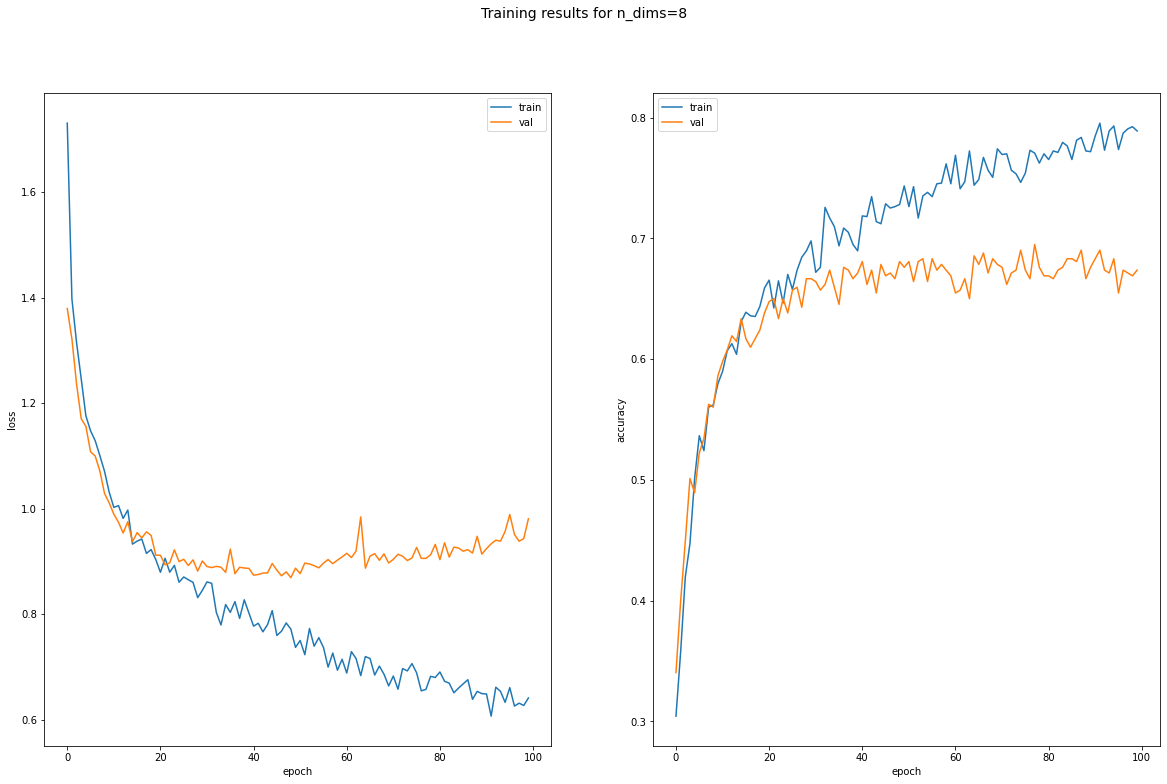

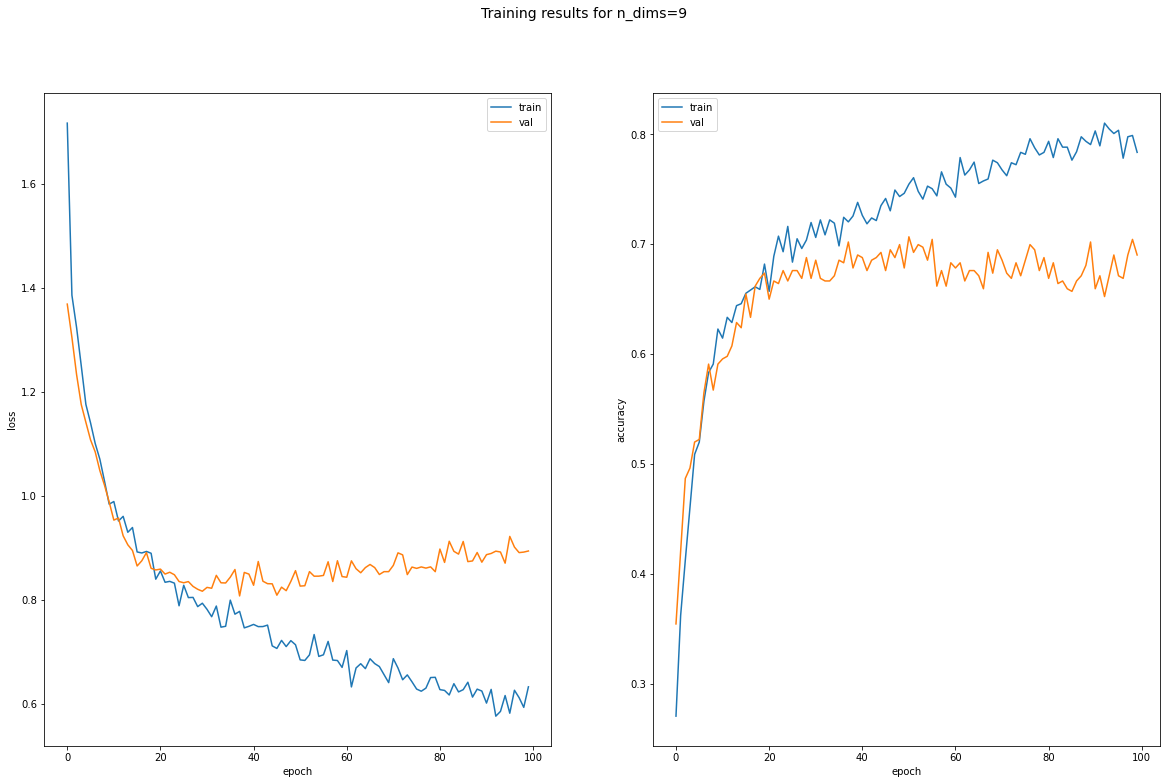

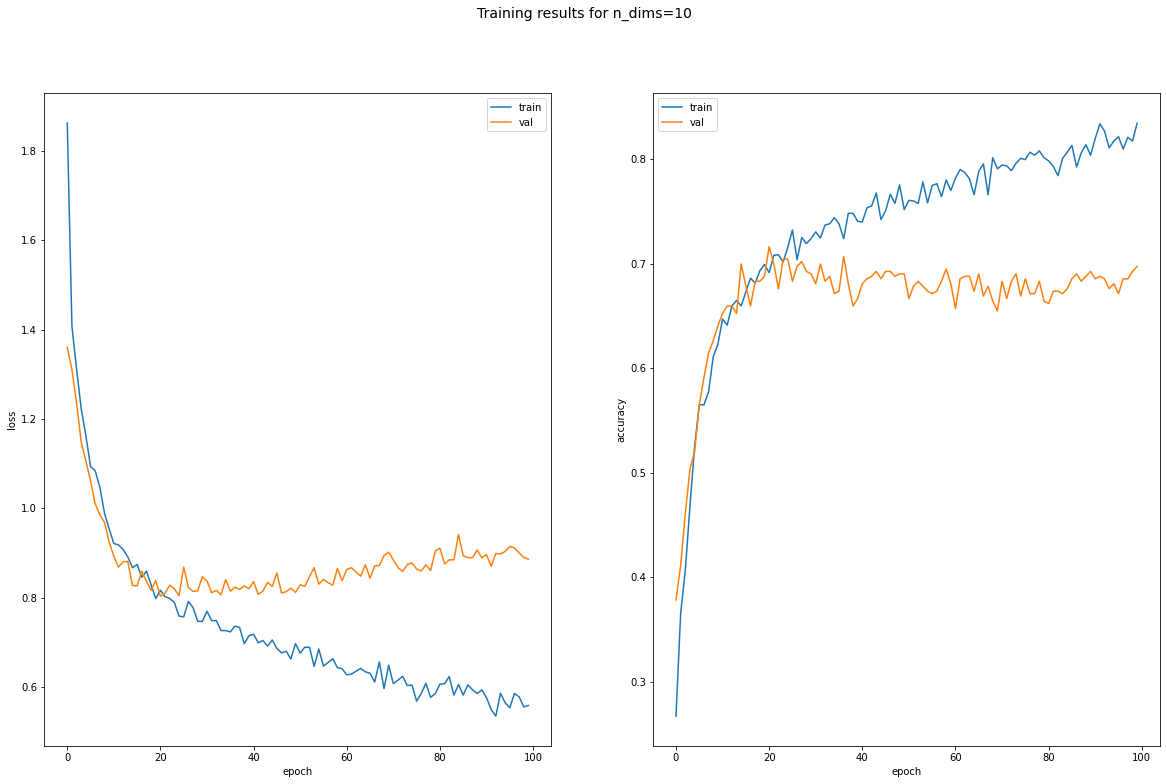

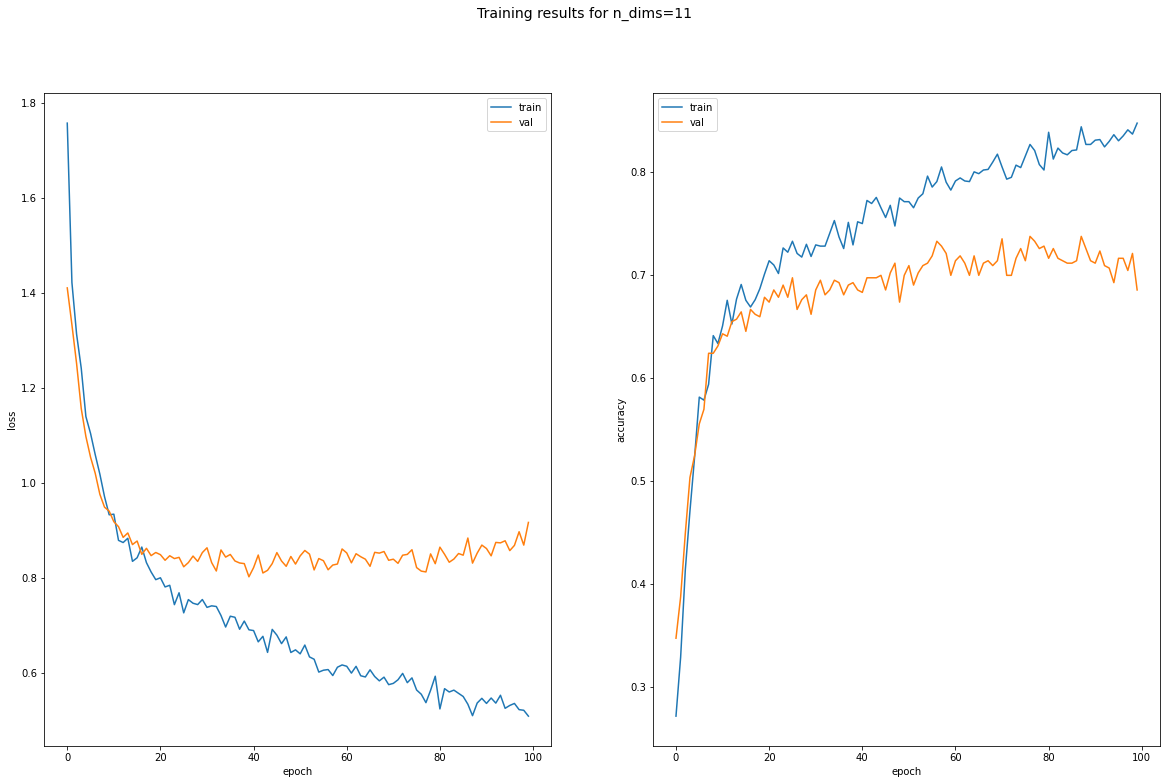

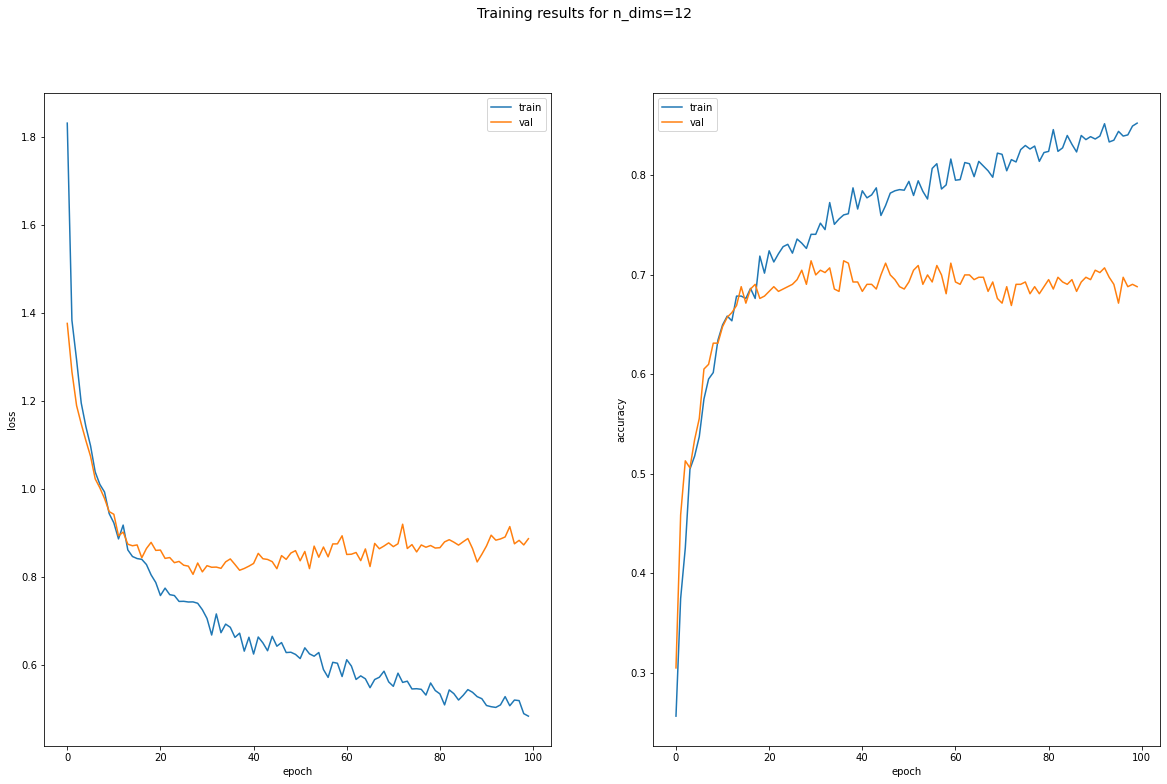

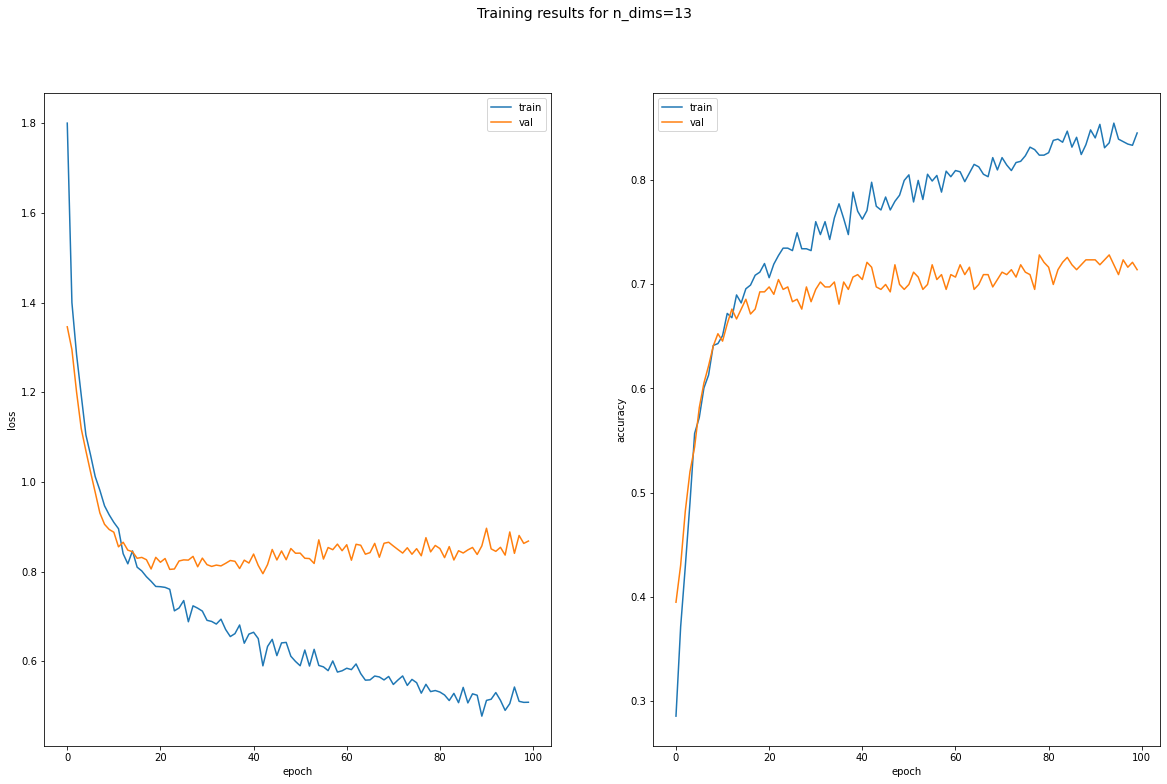

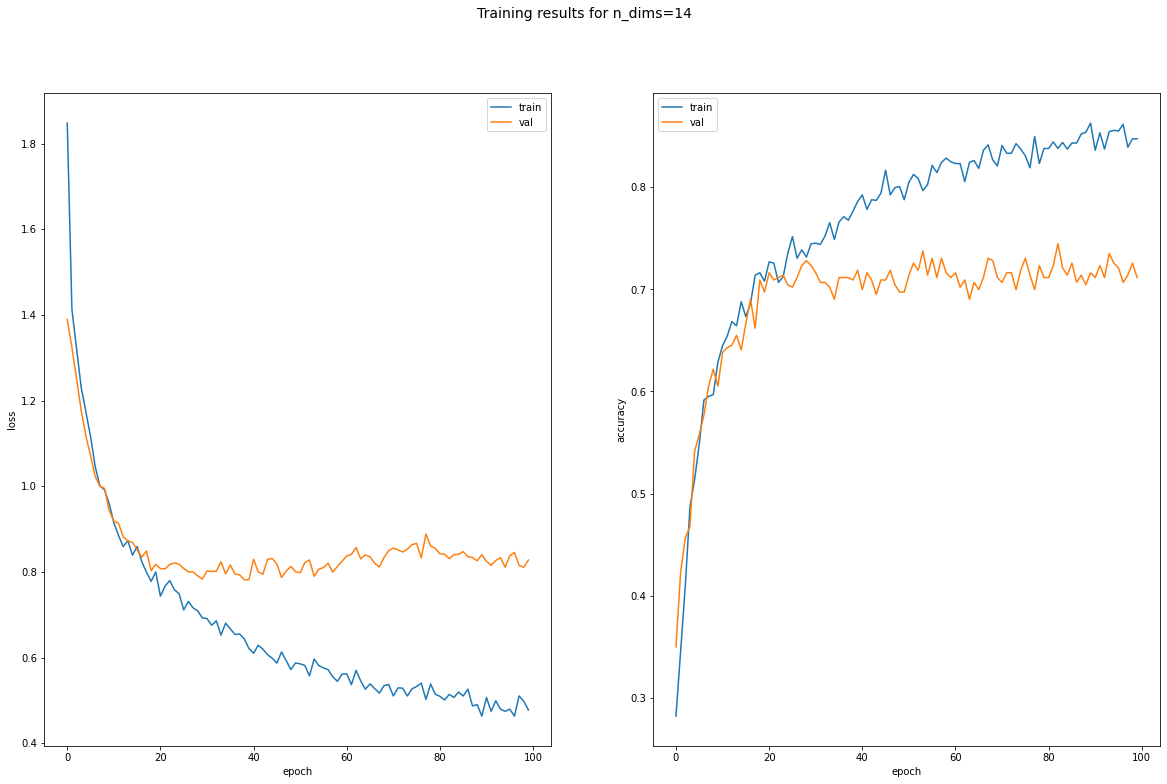

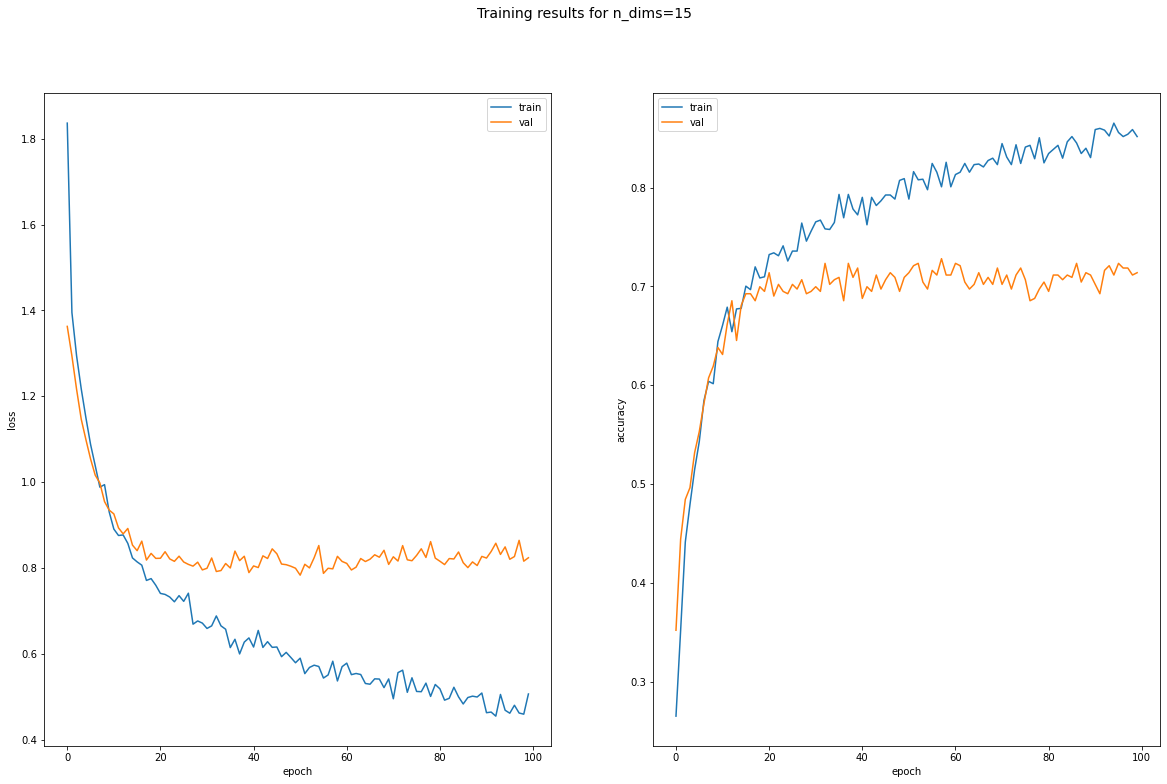

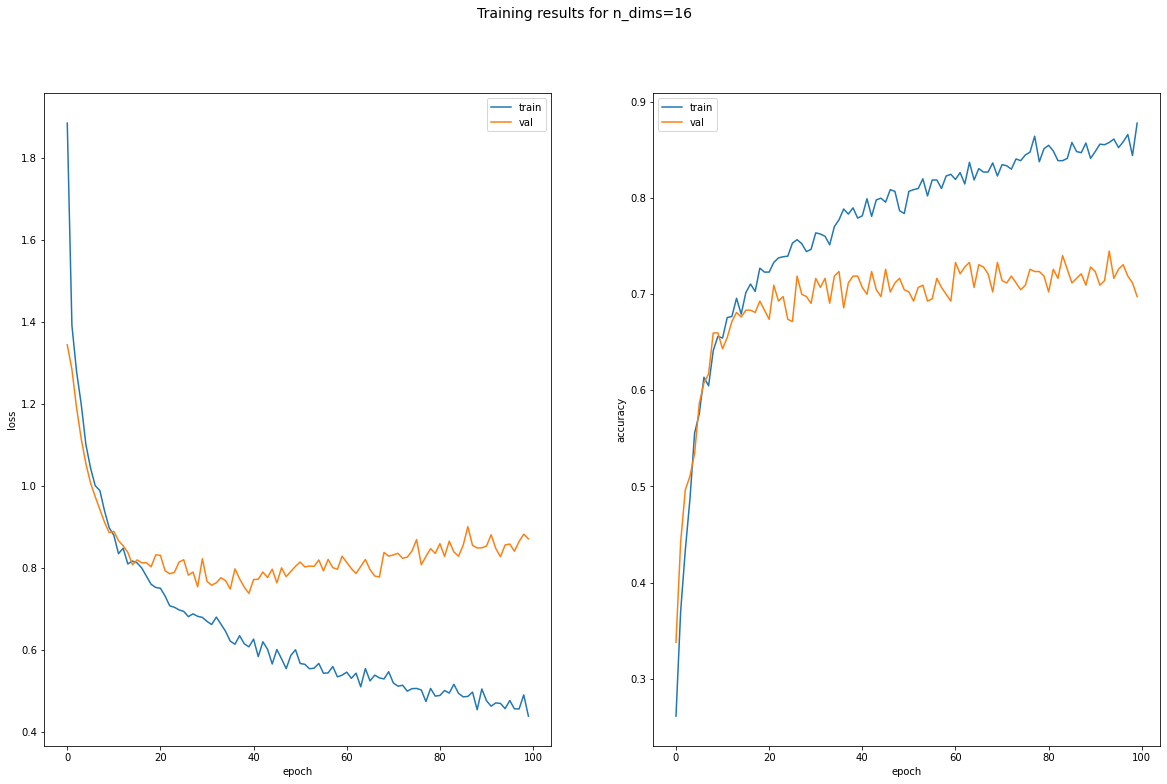

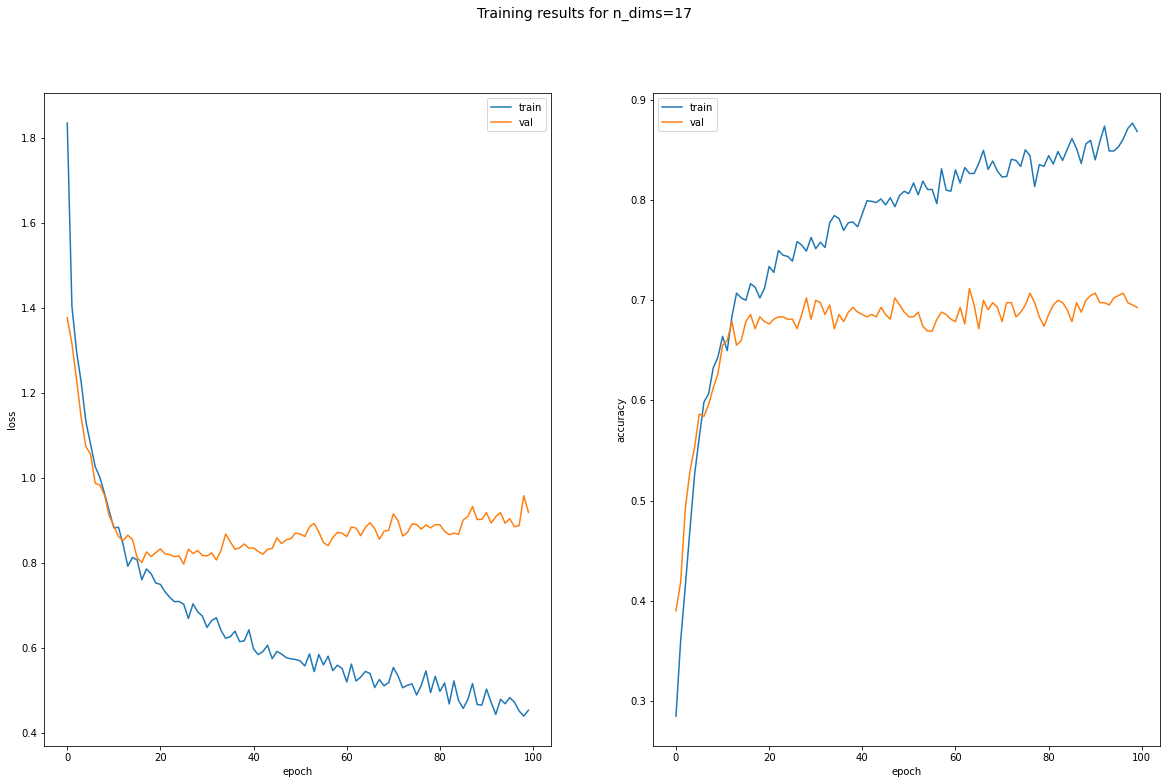

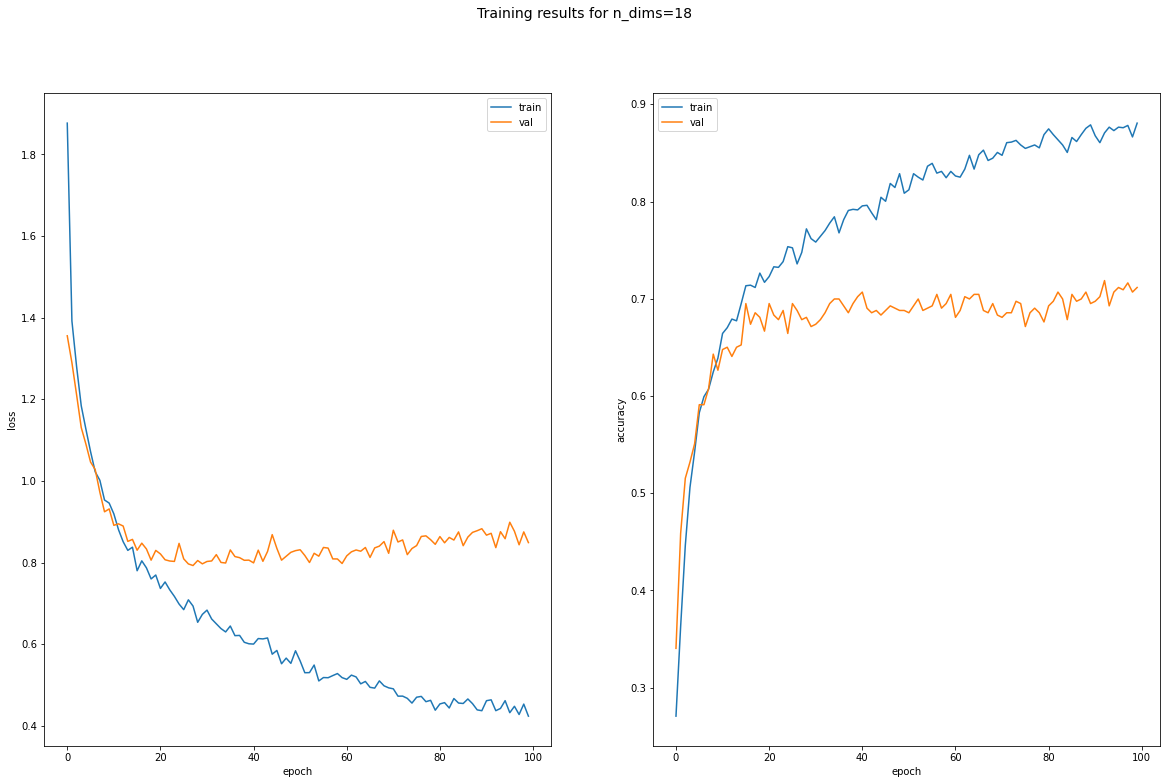

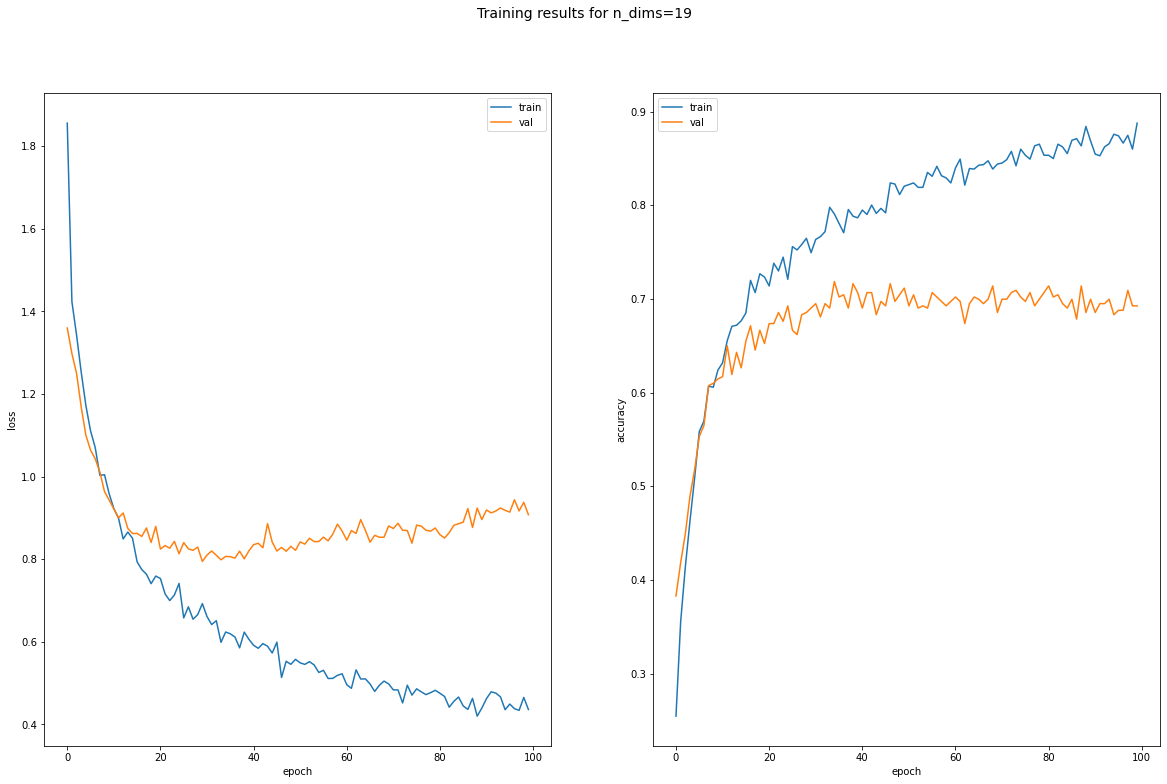

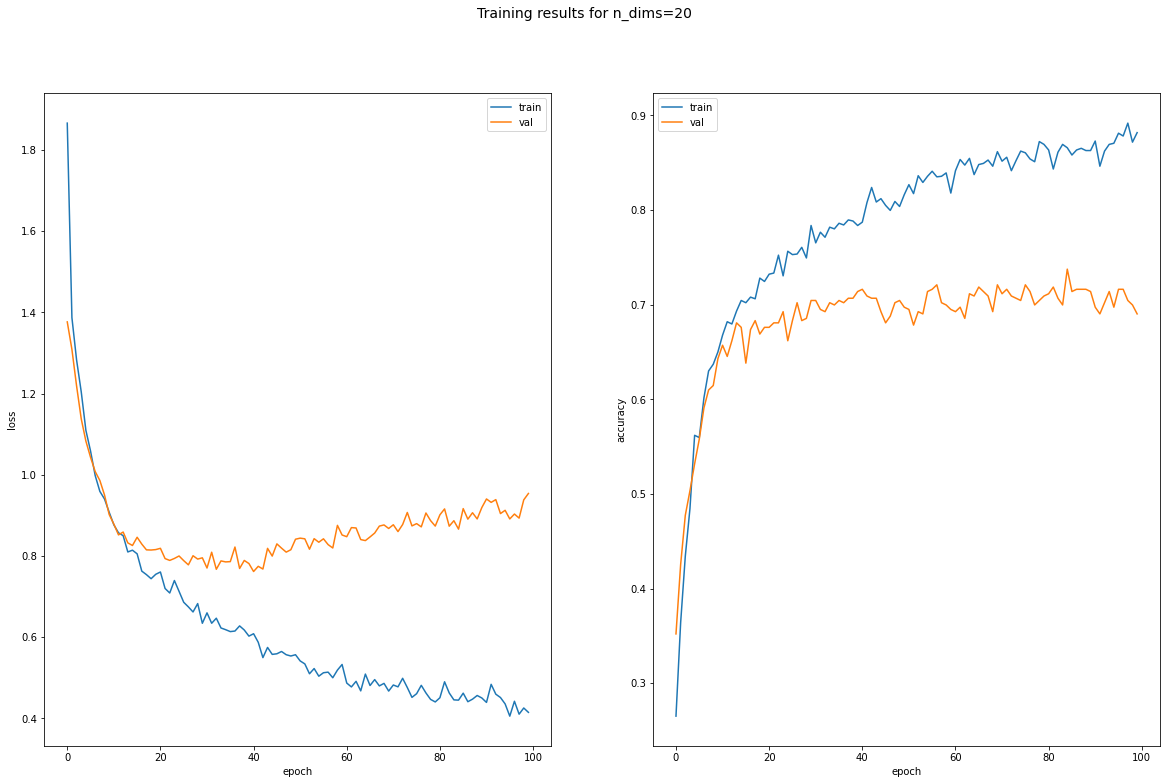

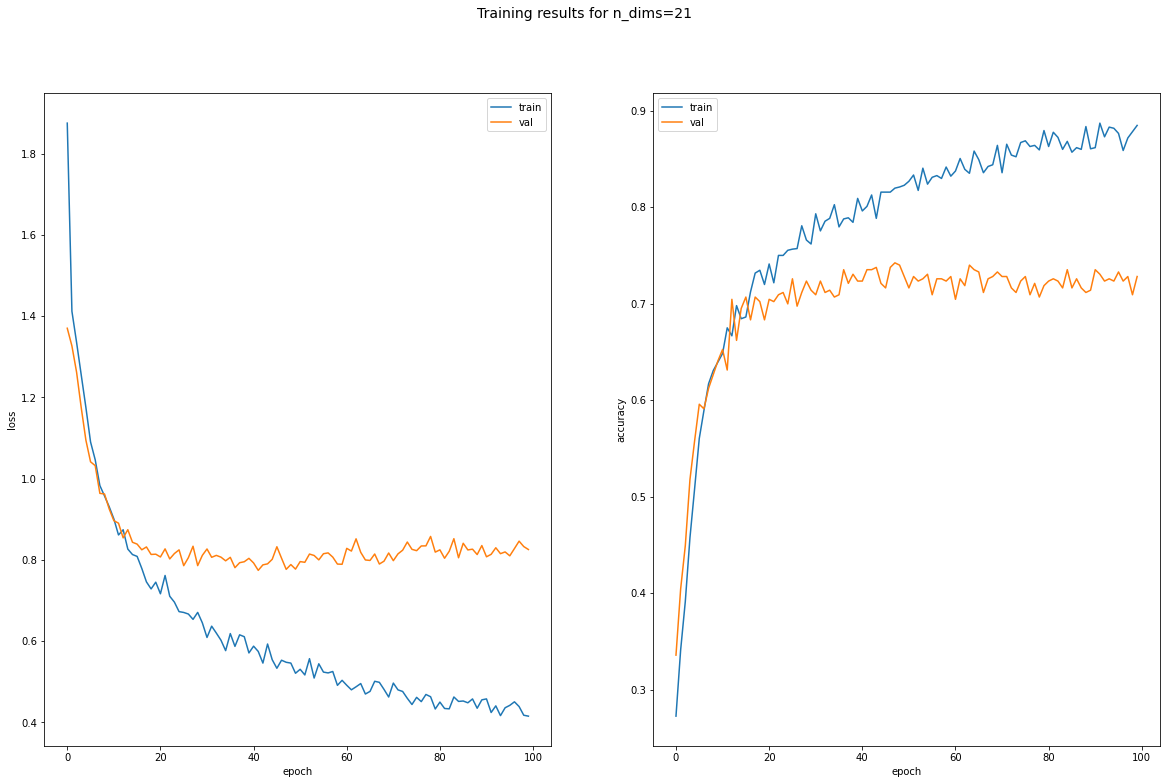

In [17]:
for n_comp in range(8, 22):
    print("Testing PCA Network for n_dims = {}".format(n_comp))
    
    X_train_valid_reshaped = X_train_valid_flipped.reshape((X_train_valid_norm_cropped.shape[0]*X_train_valid_norm_cropped.shape[2], 22)) 
    #print(X_train_valid_reshaped.shape)
    X_test_flipped = np.transpose(X_test_norm_cropped, (0,2,1))
    X_test_reshaped = X_test_flipped.reshape((X_test_norm_cropped.shape[0]*X_test_norm_cropped.shape[2], 22)) 


    #try a PCA on the data
    #reshaped_data = X_train_valid_flipped.reshape((X_train_valid_cropped.shape[1]*X_train_valid_cropped.shape[2], 22))    # create one big data panel with 20 series and 300.000 datapoints
                                          #choose the number of features to have after dimensionality reduction
    pca = PCA(n_components=n_comp)                  #create the pca object       
    pca.fit(X_train_valid_reshaped)                               #fit it to your transformed data
    X_train_valid_transformed=np.empty([X_train_valid_norm_cropped.shape[0],X_train_valid_norm_cropped.shape[2],n_comp])
    for i in range(len(X_train_valid_flipped)):
        #print(X_train_valid_flipped[i].shape)
        X_train_valid_transformed[i]=pca.transform(X_train_valid_flipped[i])           #iteratively apply the transformation to each instance of the original dataset


    #print(X_train_valid_transformed.shape)    #we end up with examples*timesteps*channels
    #now transpose back to examples*channels*timesteps
    X_train_valid_transformed = np.transpose(X_train_valid_transformed, (0,2,1))

    #n_comp=4                                      #choose the number of features to have after dimensionality reduction
    pca = PCA(n_components=n_comp)                  #create the pca object       
    pca.fit(X_test_reshaped)                               #fit it to your transformed data
    X_test_transformed=np.empty([X_test_norm_cropped.shape[0],X_test_norm_cropped.shape[2],n_comp])
    #print(X_test_transformed.shape)
    for i in range(len(X_test_flipped)):
        #print(X_test_flipped[i].shape)
        X_test_transformed[i]=pca.transform(X_test_flipped[i])           #iteratively apply the transformation to each instance of the original dataset

    #print(X_test_transformed.shape)    #we end up with examples*timesteps*channels
    #now transpose back to examples*channels*timesteps
    X_test_transformed = np.transpose(X_test_transformed, (0,2,1))
    
    input_ = layers.Input(shape=(n_comp, 500))
    r1 = layers.Reshape(target_shape=(n_comp, 500, 1))(input_)
    c1 = layers.Conv2D(filters=40, kernel_size=(1,25), data_format='channels_last',
                       activation='elu', kernel_regularizer='l2')(r1)
    p1 = layers.Permute(dims=(2,1,3))(c1)
    r2 = layers.Reshape((476, n_comp*40))(p1)
    d1 = layers.Dense(40, activation='elu')(r2)
    sq1 = layers.Activation(ksquare)(d1)
    ap1 = layers.AveragePooling1D(75, strides=15)(sq1)
    log1 = layers.Activation(klog)(ap1)
    f1 = layers.Flatten()(log1)
    d2 = layers.Dropout(0.80)(f1)
    output_ = layers.Dense(4, activation='softmax', kernel_regularizer='l2', kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01))(d2)
    
    model = models.Model(inputs=input_, outputs=output_, name='shallow_convnet_one_hot')
    #opt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    model.summary()
    
    loss_hist = model.fit(X_train_valid_transformed, y_train_valid_1h, 
                      validation_split=0.2, epochs=100,
                      verbose=True)

    hist = loss_hist.history

    fig, axs = plt.subplots(1,2, figsize=(20, 12))

    fig.suptitle("Training results for n_dims={}".format(n_comp), fontsize=14)

    axs[0].plot(hist['loss'])
    axs[0].plot(hist['val_loss'])
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'])

    axs[1].plot(hist['acc'])
    axs[1].plot(hist['val_acc'])
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'])

Testing PCA Network for n_dims = 8
Model: "shallow_convnet_one_hot"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 8, 500)]          0         
_________________________________________________________________
reshape_64 (Reshape)         (None, 8, 500, 1)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 8, 476, 40)        1040      
_________________________________________________________________
permute_32 (Permute)         (None, 476, 8, 40)        0         
_________________________________________________________________
reshape_65 (Reshape)         (None, 476, 320)          0         
_________________________________________________________________
dense_64 (Dense)             (None, 476, 40)           12840     
_________________________________________________________________
activati

53/53 [==============================] - 3s 47ms/step - loss: 0.7391 - acc: 0.7169 - val_loss: 0.8709 - val_acc: 0.6832
Epoch 49/75
53/53 [==============================] - 3s 48ms/step - loss: 0.7437 - acc: 0.7323 - val_loss: 0.8756 - val_acc: 0.6856
Epoch 50/75
53/53 [==============================] - 3s 48ms/step - loss: 0.7803 - acc: 0.7139 - val_loss: 0.8863 - val_acc: 0.6714
Epoch 51/75
53/53 [==============================] - 3s 47ms/step - loss: 0.7386 - acc: 0.7364 - val_loss: 0.9009 - val_acc: 0.6690
Epoch 52/75
53/53 [==============================] - 3s 47ms/step - loss: 0.7150 - acc: 0.7541 - val_loss: 0.9057 - val_acc: 0.6596
Epoch 53/75
53/53 [==============================] - 3s 47ms/step - loss: 0.7392 - acc: 0.7340 - val_loss: 0.8941 - val_acc: 0.6832
Epoch 54/75
53/53 [==============================] - 3s 48ms/step - loss: 0.7376 - acc: 0.7394 - val_loss: 0.9054 - val_acc: 0.6596
Epoch 55/75
53/53 [==============================] - 2s 47ms/step - loss: 0.7207 - acc: 

53/53 [==============================] - 3s 59ms/step - loss: 1.7524 - acc: 0.2612 - val_loss: 1.3594 - val_acc: 0.3593
Epoch 2/75
53/53 [==============================] - 3s 58ms/step - loss: 1.3904 - acc: 0.3522 - val_loss: 1.2853 - val_acc: 0.4303
Epoch 3/75
53/53 [==============================] - 3s 58ms/step - loss: 1.2594 - acc: 0.4533 - val_loss: 1.1993 - val_acc: 0.4657
Epoch 4/75
53/53 [==============================] - 3s 58ms/step - loss: 1.1890 - acc: 0.4982 - val_loss: 1.1469 - val_acc: 0.5035
Epoch 5/75
53/53 [==============================] - 3s 58ms/step - loss: 1.1402 - acc: 0.5284 - val_loss: 1.0915 - val_acc: 0.5437
Epoch 6/75
53/53 [==============================] - 3s 58ms/step - loss: 1.0973 - acc: 0.5479 - val_loss: 1.0515 - val_acc: 0.5816
Epoch 7/75
53/53 [==============================] - 3s 58ms/step - loss: 1.0524 - acc: 0.5757 - val_loss: 1.0067 - val_acc: 0.5934
Epoch 8/75
53/53 [==============================] - 3s 58ms/step - loss: 1.0237 - acc: 0.5816 

53/53 [==============================] - 3s 63ms/step - loss: 0.7148 - acc: 0.7506 - val_loss: 0.8122 - val_acc: 0.6832
Epoch 36/75
53/53 [==============================] - 3s 63ms/step - loss: 0.6863 - acc: 0.7547 - val_loss: 0.8178 - val_acc: 0.6738
Epoch 37/75
53/53 [==============================] - 3s 63ms/step - loss: 0.7006 - acc: 0.7441 - val_loss: 0.8044 - val_acc: 0.6785
Epoch 38/75
53/53 [==============================] - 3s 63ms/step - loss: 0.6855 - acc: 0.7571 - val_loss: 0.8169 - val_acc: 0.7069
Epoch 39/75
53/53 [==============================] - 3s 63ms/step - loss: 0.6592 - acc: 0.7725 - val_loss: 0.8138 - val_acc: 0.6927
Epoch 40/75
53/53 [==============================] - 3s 63ms/step - loss: 0.6991 - acc: 0.7506 - val_loss: 0.8158 - val_acc: 0.7021
Epoch 41/75
53/53 [==============================] - 3s 64ms/step - loss: 0.6838 - acc: 0.7512 - val_loss: 0.8450 - val_acc: 0.6809
Epoch 42/75
53/53 [==============================] - 3s 63ms/step - loss: 0.7012 - acc: 

53/53 [==============================] - 4s 69ms/step - loss: 0.5908 - acc: 0.7943 - val_loss: 0.8526 - val_acc: 0.7187
Epoch 70/75
53/53 [==============================] - 4s 69ms/step - loss: 0.6050 - acc: 0.8050 - val_loss: 0.8483 - val_acc: 0.7258
Epoch 71/75
53/53 [==============================] - 4s 69ms/step - loss: 0.5957 - acc: 0.8050 - val_loss: 0.8515 - val_acc: 0.7163
Epoch 72/75
53/53 [==============================] - 4s 68ms/step - loss: 0.5566 - acc: 0.8156 - val_loss: 0.8666 - val_acc: 0.7163
Epoch 73/75
53/53 [==============================] - 4s 69ms/step - loss: 0.5751 - acc: 0.8150 - val_loss: 0.8355 - val_acc: 0.7258
Epoch 74/75
53/53 [==============================] - 4s 69ms/step - loss: 0.5489 - acc: 0.8239 - val_loss: 0.8449 - val_acc: 0.7139
Epoch 75/75
53/53 [==============================] - 4s 68ms/step - loss: 0.5670 - acc: 0.8203 - val_loss: 0.8423 - val_acc: 0.7187
Testing PCA Network for n_dims = 13
Model: "shallow_convnet_one_hot"
___________________

53/53 [==============================] - 4s 83ms/step - loss: 0.8627 - acc: 0.6755 - val_loss: 0.8817 - val_acc: 0.6619
Epoch 14/75
53/53 [==============================] - 4s 83ms/step - loss: 0.8549 - acc: 0.6714 - val_loss: 0.8976 - val_acc: 0.6619
Epoch 15/75
53/53 [==============================] - 4s 83ms/step - loss: 0.8670 - acc: 0.6608 - val_loss: 0.8700 - val_acc: 0.6548
Epoch 16/75
53/53 [==============================] - 5s 85ms/step - loss: 0.7986 - acc: 0.6891 - val_loss: 0.8579 - val_acc: 0.6714
Epoch 17/75
53/53 [==============================] - 4s 84ms/step - loss: 0.8021 - acc: 0.6844 - val_loss: 0.8666 - val_acc: 0.6738
Epoch 18/75
53/53 [==============================] - 4s 83ms/step - loss: 0.8184 - acc: 0.6874 - val_loss: 0.8550 - val_acc: 0.6856
Epoch 19/75
53/53 [==============================] - 4s 84ms/step - loss: 0.7779 - acc: 0.7080 - val_loss: 0.8472 - val_acc: 0.6738
Epoch 20/75
53/53 [==============================] - 4s 83ms/step - loss: 0.7947 - acc: 

53/53 [==============================] - 5s 90ms/step - loss: 0.5863 - acc: 0.7979 - val_loss: 0.7699 - val_acc: 0.6974
Epoch 48/75
53/53 [==============================] - 5s 91ms/step - loss: 0.5907 - acc: 0.7943 - val_loss: 0.7809 - val_acc: 0.7163
Epoch 49/75
53/53 [==============================] - 5s 90ms/step - loss: 0.5596 - acc: 0.8097 - val_loss: 0.7903 - val_acc: 0.6998
Epoch 50/75
53/53 [==============================] - 5s 90ms/step - loss: 0.5563 - acc: 0.8067 - val_loss: 0.7992 - val_acc: 0.7045
Epoch 51/75
53/53 [==============================] - 5s 90ms/step - loss: 0.6043 - acc: 0.7973 - val_loss: 0.7839 - val_acc: 0.7069
Epoch 52/75
53/53 [==============================] - 5s 90ms/step - loss: 0.5702 - acc: 0.8056 - val_loss: 0.8045 - val_acc: 0.7139
Epoch 53/75
53/53 [==============================] - 5s 90ms/step - loss: 0.5778 - acc: 0.7931 - val_loss: 0.7940 - val_acc: 0.7234
Epoch 54/75
53/53 [==============================] - 5s 90ms/step - loss: 0.6123 - acc: 

Epoch 1/75
53/53 [==============================] - 5s 103ms/step - loss: 1.8319 - acc: 0.2624 - val_loss: 1.3837 - val_acc: 0.3688
Epoch 2/75
53/53 [==============================] - 5s 101ms/step - loss: 1.4309 - acc: 0.3422 - val_loss: 1.3246 - val_acc: 0.4019
Epoch 3/75
53/53 [==============================] - 5s 103ms/step - loss: 1.3342 - acc: 0.4102 - val_loss: 1.2612 - val_acc: 0.4634
Epoch 4/75
53/53 [==============================] - 6s 104ms/step - loss: 1.2415 - acc: 0.4710 - val_loss: 1.1801 - val_acc: 0.5035
Epoch 5/75
53/53 [==============================] - 5s 103ms/step - loss: 1.1608 - acc: 0.5065 - val_loss: 1.1024 - val_acc: 0.5626
Epoch 6/75
53/53 [==============================] - 5s 102ms/step - loss: 1.1156 - acc: 0.5426 - val_loss: 1.0786 - val_acc: 0.5366
Epoch 7/75
53/53 [==============================] - 5s 103ms/step - loss: 1.0683 - acc: 0.5632 - val_loss: 1.0392 - val_acc: 0.5650
Epoch 8/75
53/53 [==============================] - 6s 105ms/step - loss: 1.

Epoch 34/75
53/53 [==============================] - 6s 108ms/step - loss: 0.6493 - acc: 0.7677 - val_loss: 0.8220 - val_acc: 0.6903
Epoch 35/75
53/53 [==============================] - 6s 108ms/step - loss: 0.6316 - acc: 0.7701 - val_loss: 0.8236 - val_acc: 0.7045
Epoch 36/75
53/53 [==============================] - 6s 108ms/step - loss: 0.6300 - acc: 0.7884 - val_loss: 0.8423 - val_acc: 0.7045
Epoch 37/75
53/53 [==============================] - 6s 109ms/step - loss: 0.6219 - acc: 0.7790 - val_loss: 0.8155 - val_acc: 0.6998
Epoch 38/75
53/53 [==============================] - 6s 109ms/step - loss: 0.6317 - acc: 0.7778 - val_loss: 0.8150 - val_acc: 0.6974
Epoch 39/75
53/53 [==============================] - 6s 109ms/step - loss: 0.6299 - acc: 0.7855 - val_loss: 0.8013 - val_acc: 0.6950
Epoch 40/75
53/53 [==============================] - 6s 108ms/step - loss: 0.6411 - acc: 0.7665 - val_loss: 0.8508 - val_acc: 0.6761
Epoch 41/75
53/53 [==============================] - 6s 109ms/step - 

Epoch 6/75
53/53 [==============================] - 6s 115ms/step - loss: 1.0864 - acc: 0.5449 - val_loss: 1.0430 - val_acc: 0.5650
Epoch 7/75
53/53 [==============================] - 6s 120ms/step - loss: 1.0067 - acc: 0.6034 - val_loss: 0.9706 - val_acc: 0.5934
Epoch 8/75
53/53 [==============================] - 6s 116ms/step - loss: 0.9605 - acc: 0.6312 - val_loss: 0.9412 - val_acc: 0.6076
Epoch 9/75
53/53 [==============================] - 6s 115ms/step - loss: 0.9685 - acc: 0.6129 - val_loss: 0.9077 - val_acc: 0.6407
Epoch 10/75
53/53 [==============================] - 6s 115ms/step - loss: 0.8895 - acc: 0.6625 - val_loss: 0.8822 - val_acc: 0.6525
Epoch 11/75
53/53 [==============================] - 6s 115ms/step - loss: 0.8847 - acc: 0.6631 - val_loss: 0.8660 - val_acc: 0.6738
Epoch 12/75
53/53 [==============================] - 6s 116ms/step - loss: 0.8574 - acc: 0.6791 - val_loss: 0.8722 - val_acc: 0.6478
Epoch 13/75
53/53 [==============================] - 6s 116ms/step - loss

Epoch 39/75
53/53 [==============================] - 7s 123ms/step - loss: 0.6125 - acc: 0.7884 - val_loss: 0.8559 - val_acc: 0.6998
Epoch 40/75
53/53 [==============================] - 7s 124ms/step - loss: 0.5633 - acc: 0.8150 - val_loss: 0.8459 - val_acc: 0.7163
Epoch 41/75
53/53 [==============================] - 7s 125ms/step - loss: 0.6265 - acc: 0.7825 - val_loss: 0.8496 - val_acc: 0.7139
Epoch 42/75
53/53 [==============================] - 7s 124ms/step - loss: 0.5934 - acc: 0.7855 - val_loss: 0.8689 - val_acc: 0.7021
Epoch 43/75
53/53 [==============================] - 7s 124ms/step - loss: 0.5756 - acc: 0.7967 - val_loss: 0.8487 - val_acc: 0.7116
Epoch 44/75
53/53 [==============================] - 7s 124ms/step - loss: 0.5603 - acc: 0.7979 - val_loss: 0.8861 - val_acc: 0.6974
Epoch 45/75
53/53 [==============================] - 7s 124ms/step - loss: 0.6050 - acc: 0.7890 - val_loss: 0.8646 - val_acc: 0.7021
Epoch 46/75
53/53 [==============================] - 7s 123ms/step - 

Epoch 11/75
53/53 [==============================] - 7s 129ms/step - loss: 0.8816 - acc: 0.6608 - val_loss: 0.9506 - val_acc: 0.6099
Epoch 12/75
53/53 [==============================] - 7s 128ms/step - loss: 0.8708 - acc: 0.6696 - val_loss: 0.9208 - val_acc: 0.6288
Epoch 13/75
53/53 [==============================] - 7s 129ms/step - loss: 0.8375 - acc: 0.6702 - val_loss: 0.8927 - val_acc: 0.6336
Epoch 14/75
53/53 [==============================] - 7s 129ms/step - loss: 0.8230 - acc: 0.6844 - val_loss: 0.9074 - val_acc: 0.6454
Epoch 15/75
53/53 [==============================] - 7s 129ms/step - loss: 0.8413 - acc: 0.6903 - val_loss: 0.8746 - val_acc: 0.6572
Epoch 16/75
53/53 [==============================] - 7s 128ms/step - loss: 0.7988 - acc: 0.6974 - val_loss: 0.8881 - val_acc: 0.6643
Epoch 17/75
53/53 [==============================] - 7s 129ms/step - loss: 0.7743 - acc: 0.7009 - val_loss: 0.8343 - val_acc: 0.6809
Epoch 18/75
53/53 [==============================] - 7s 128ms/step - 

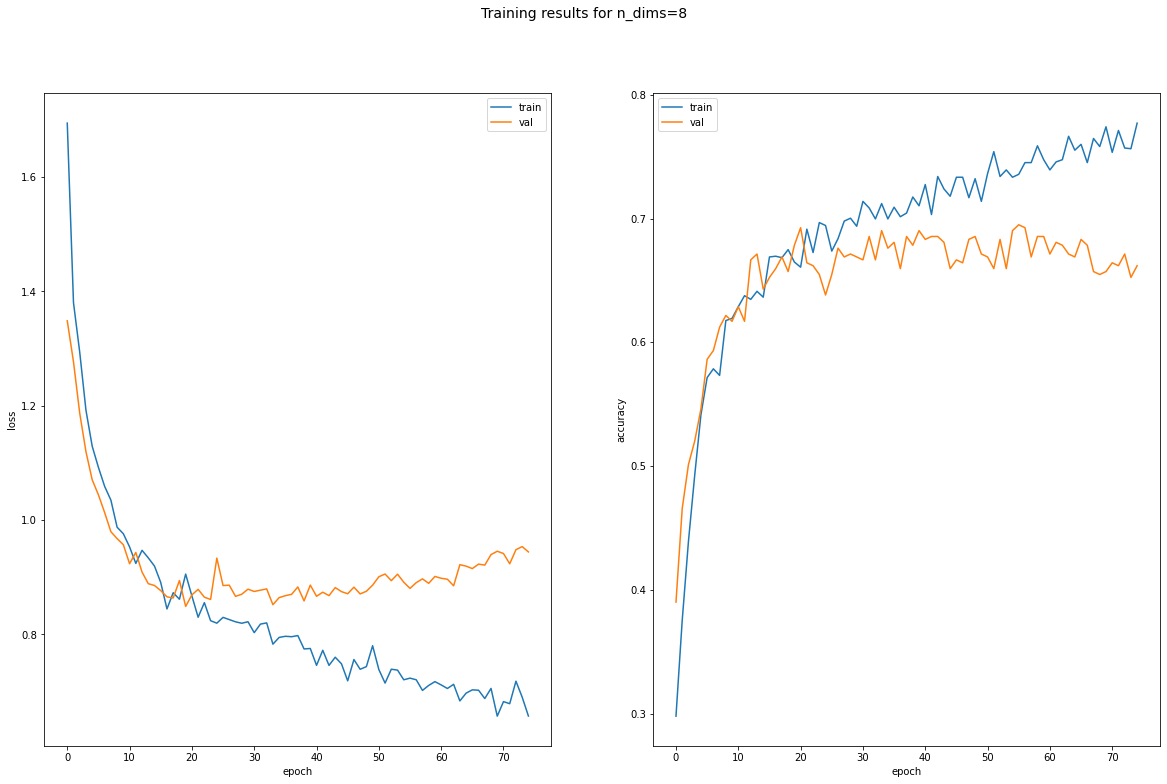

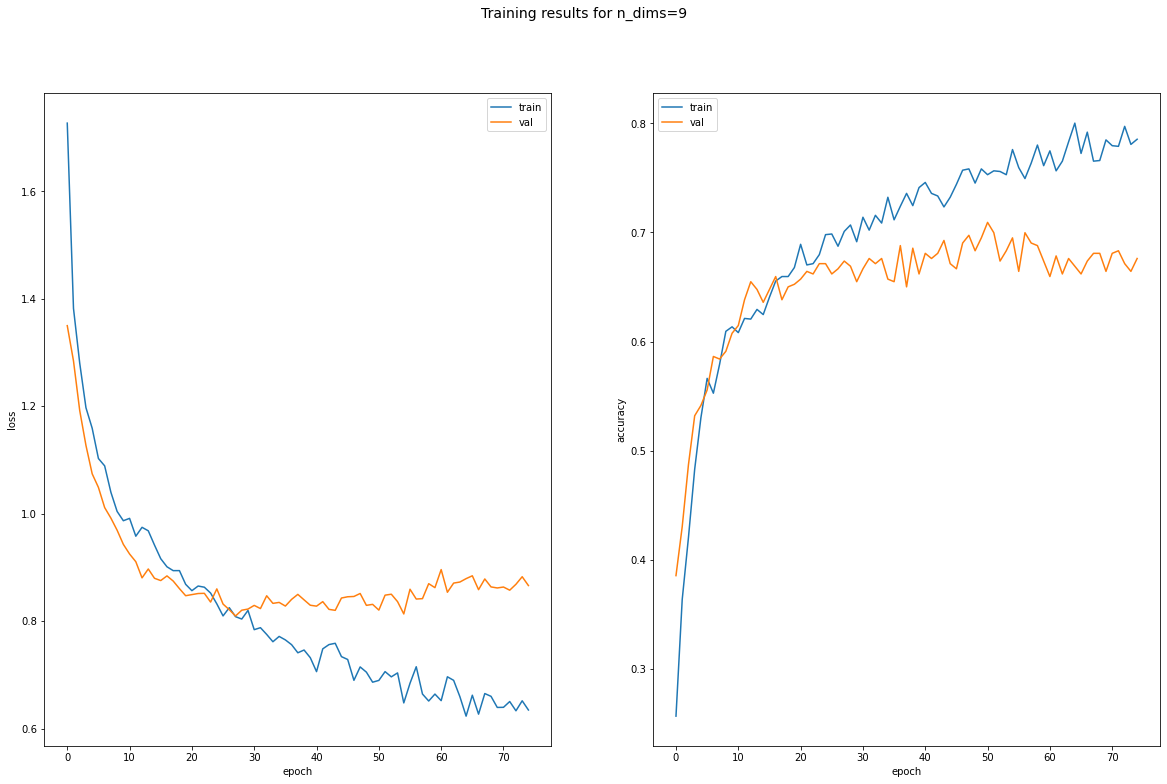

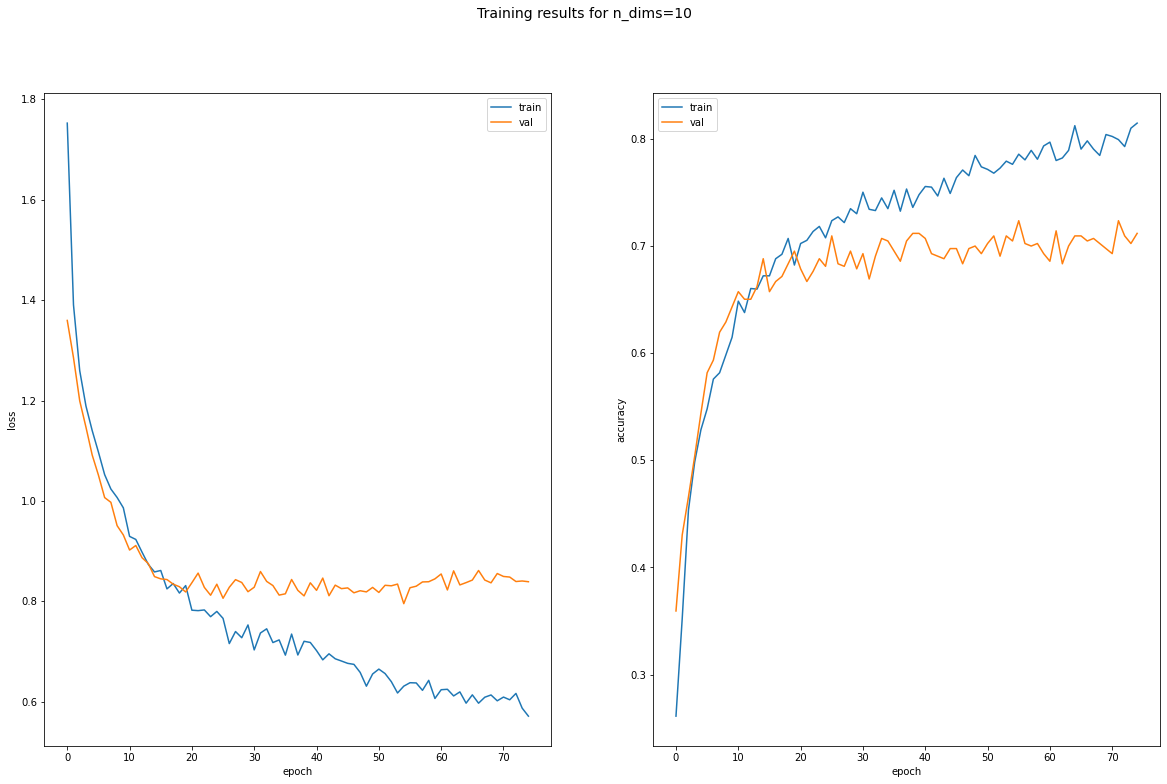

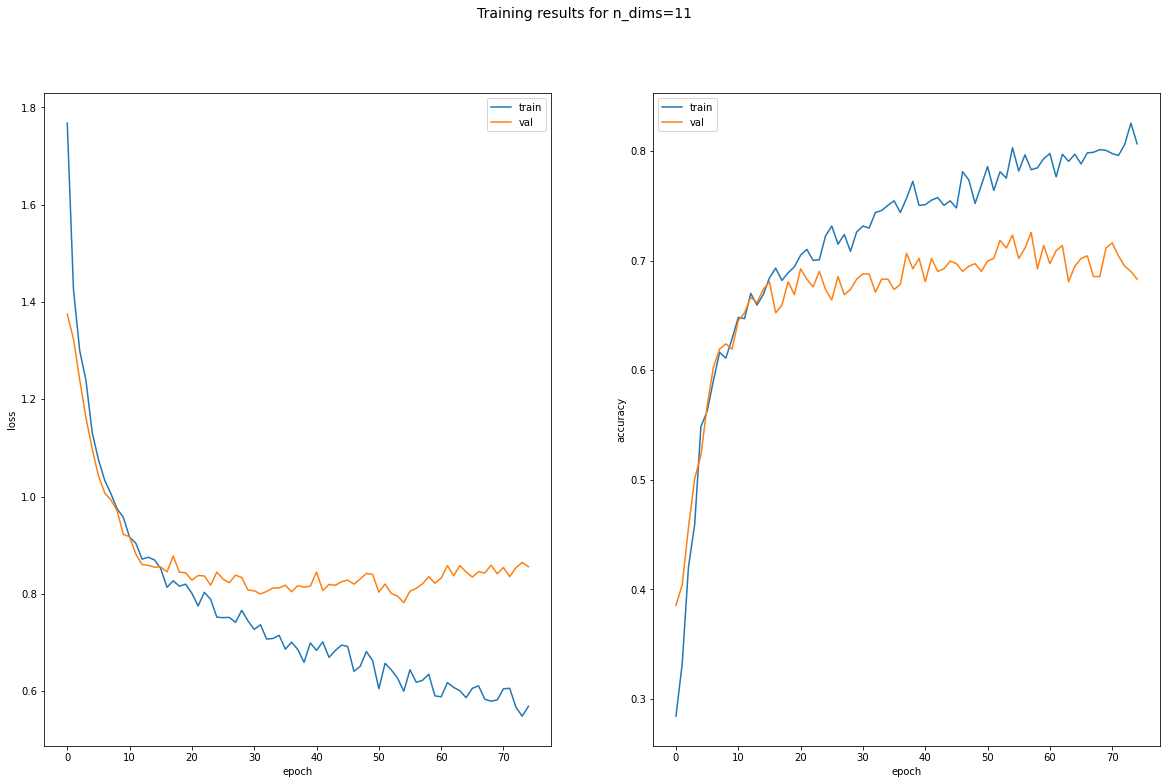

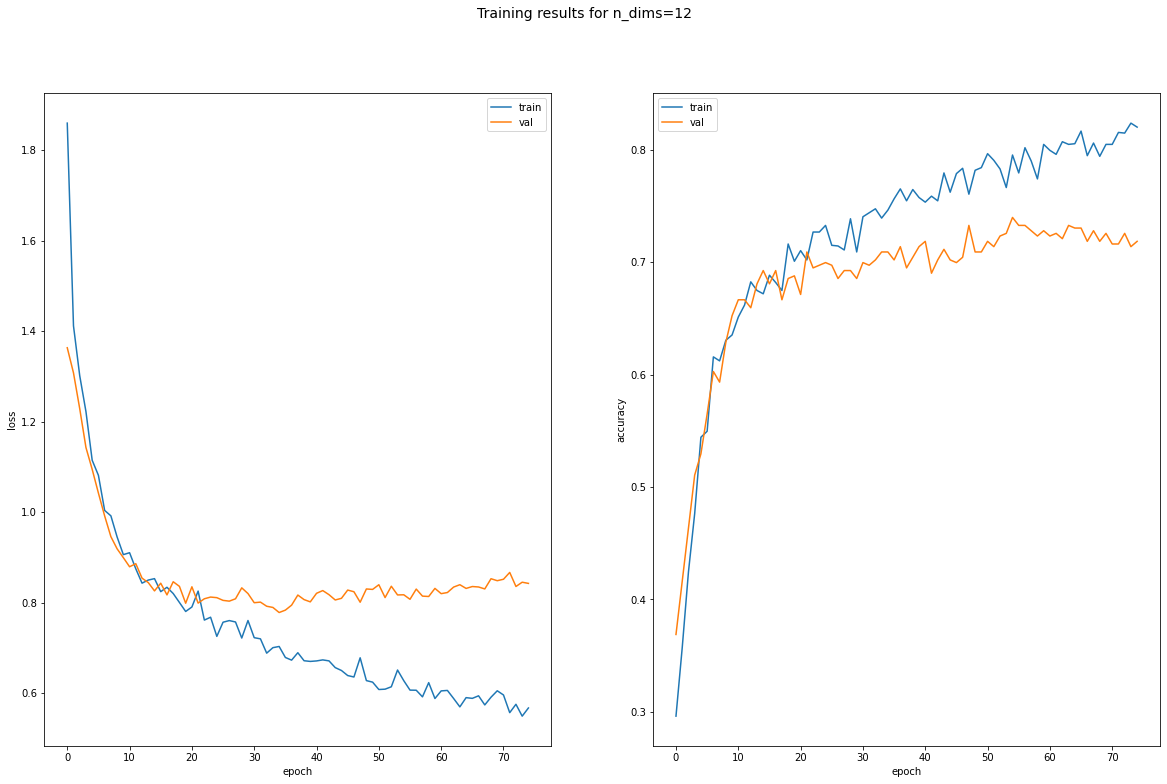

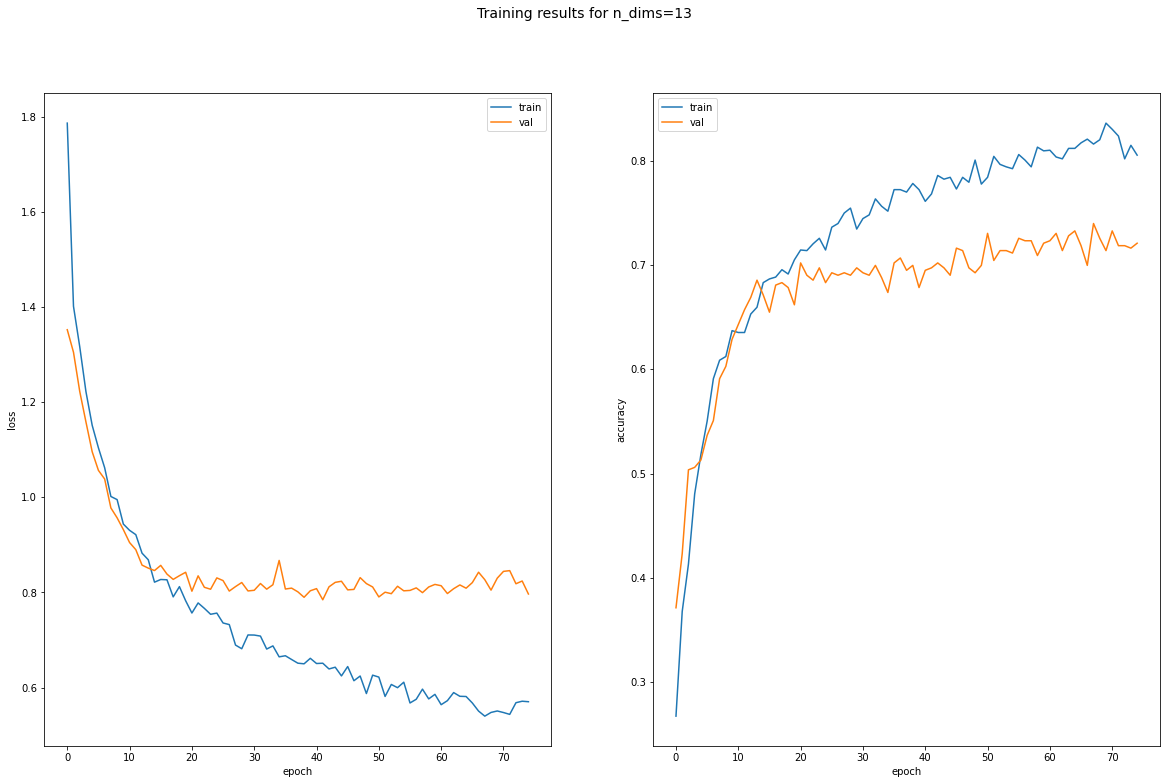

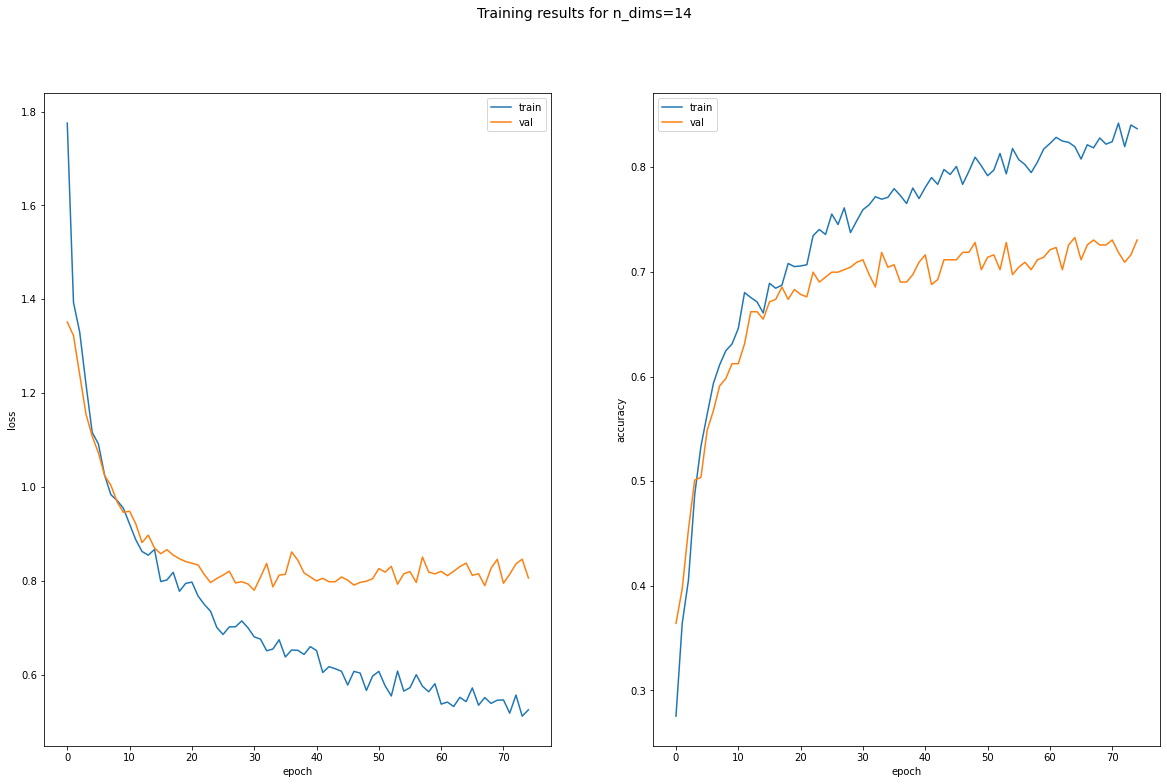

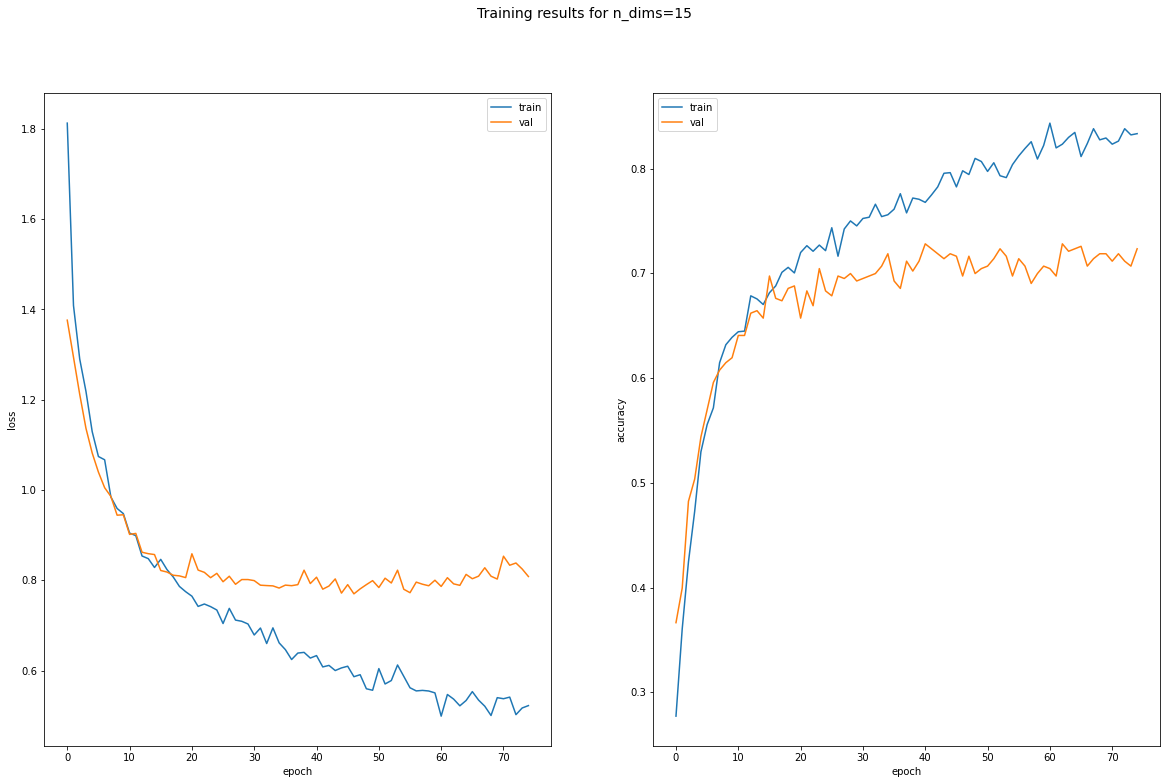

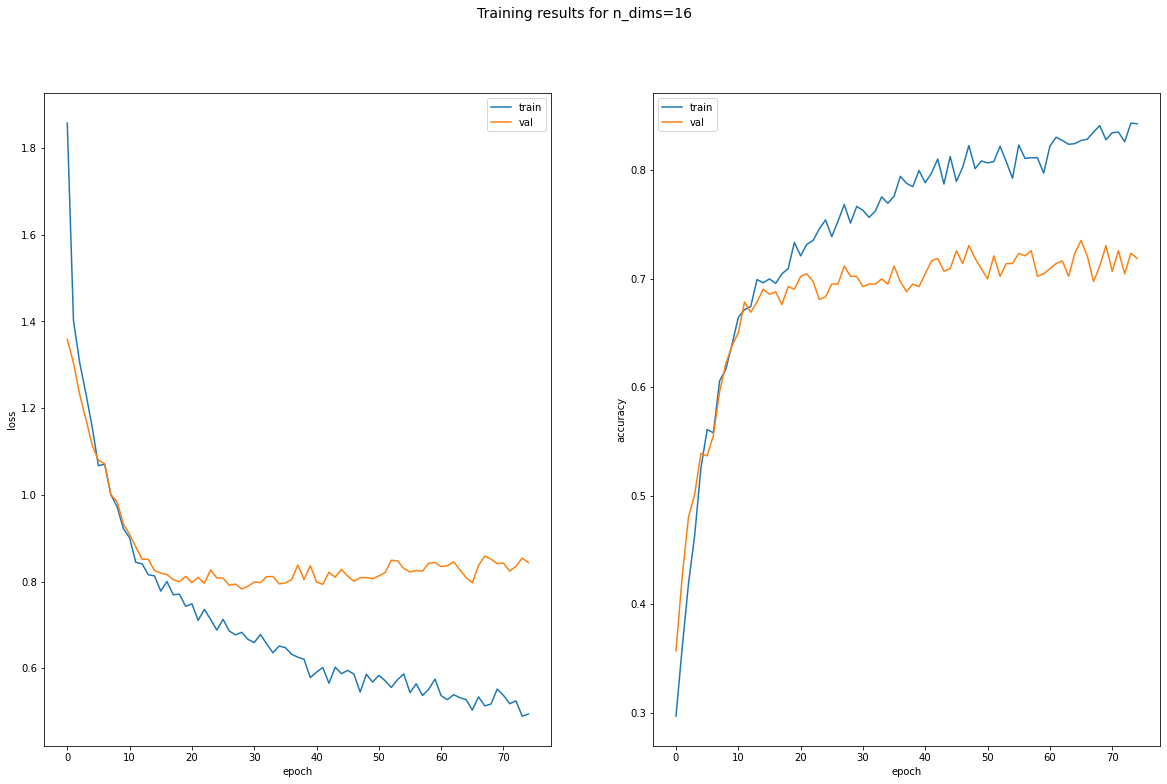

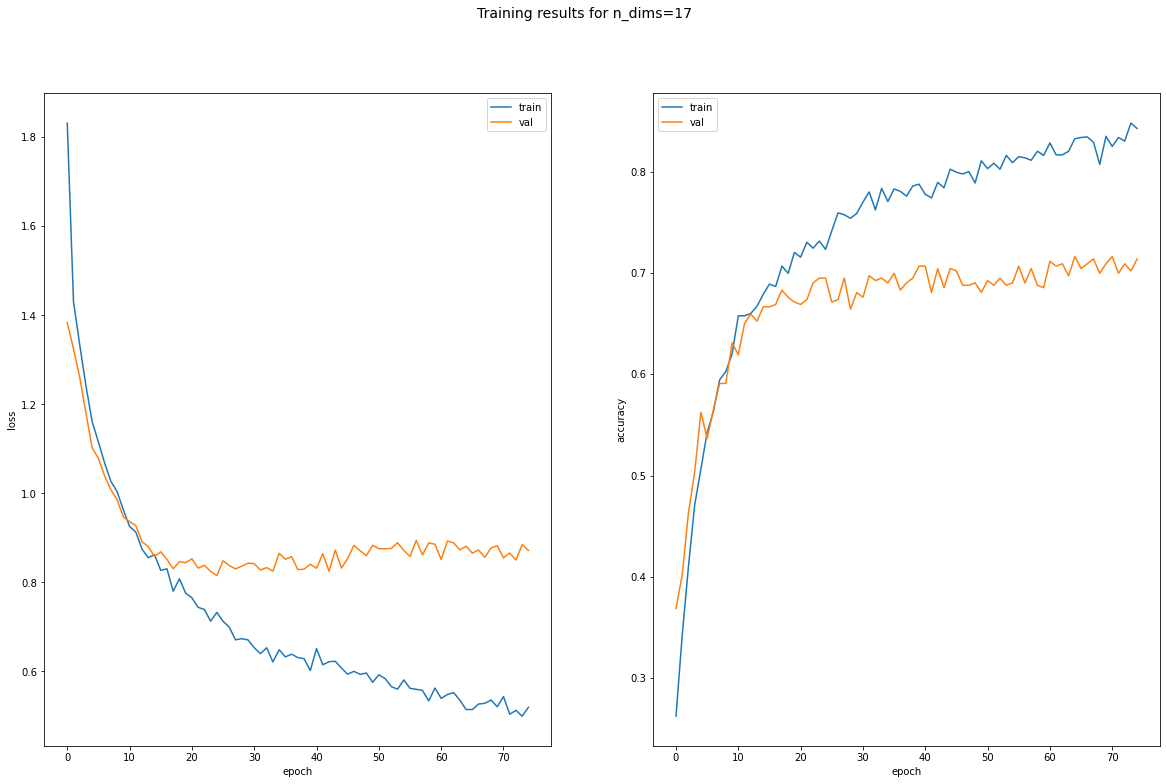

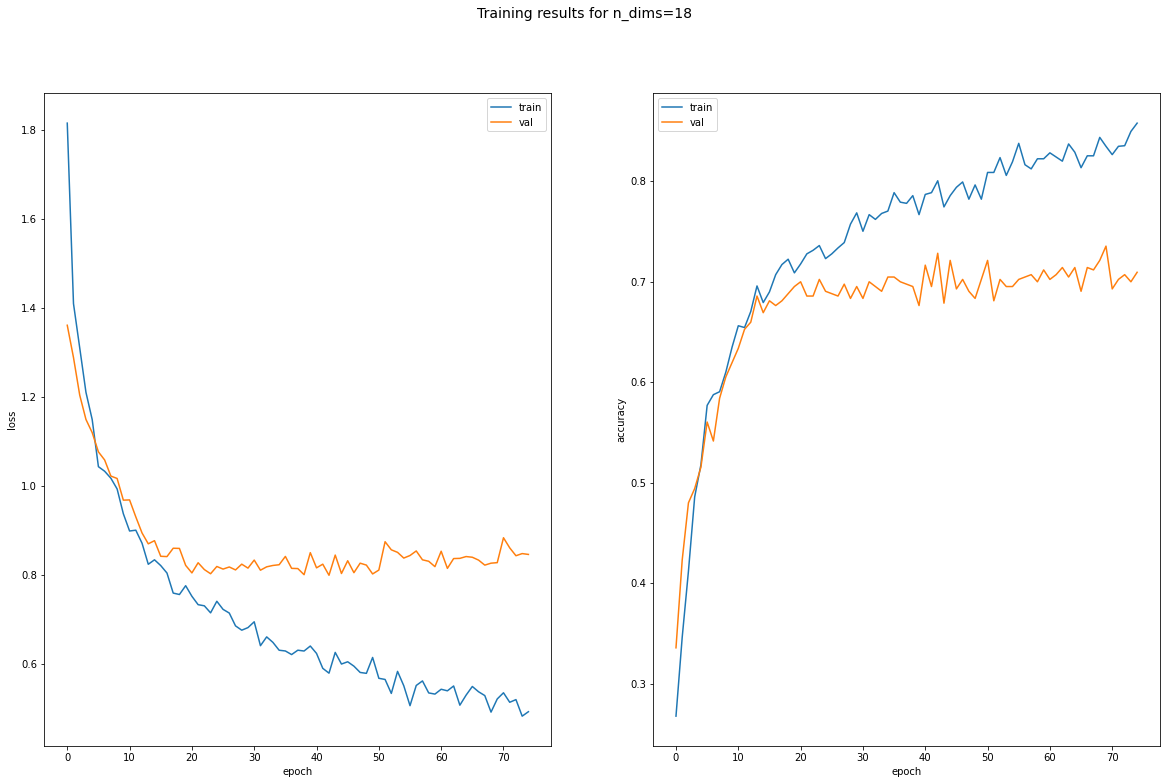

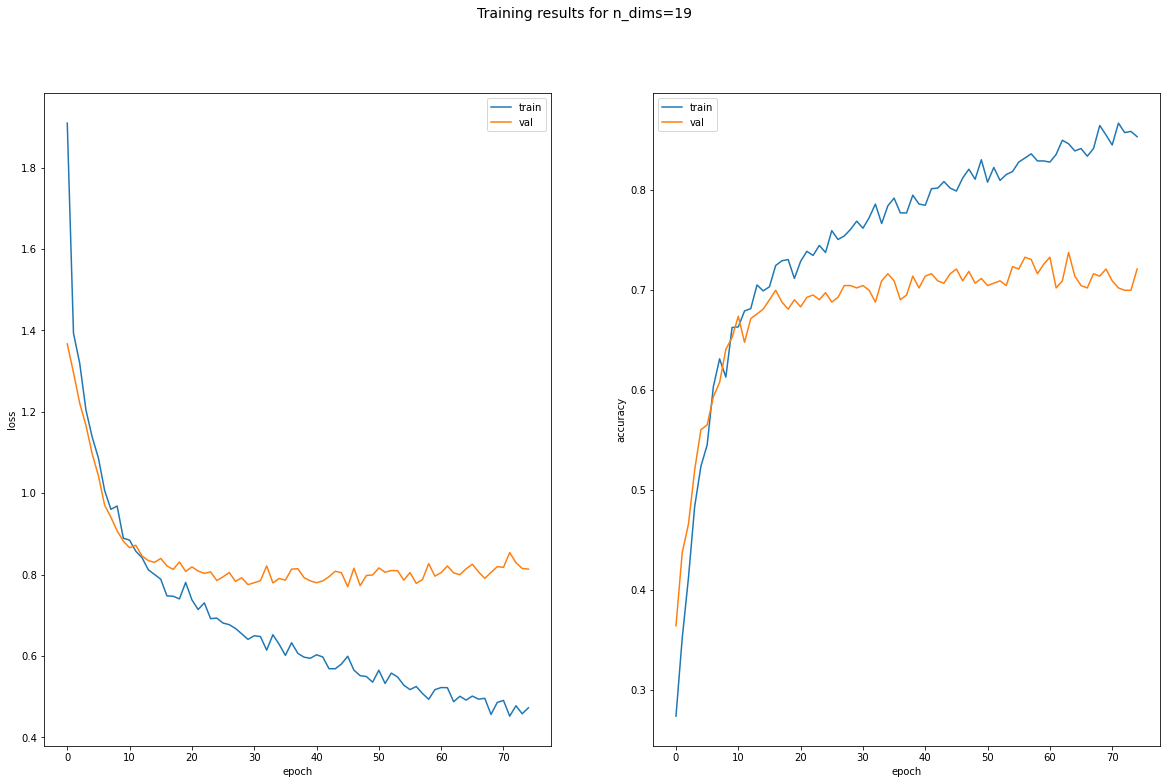

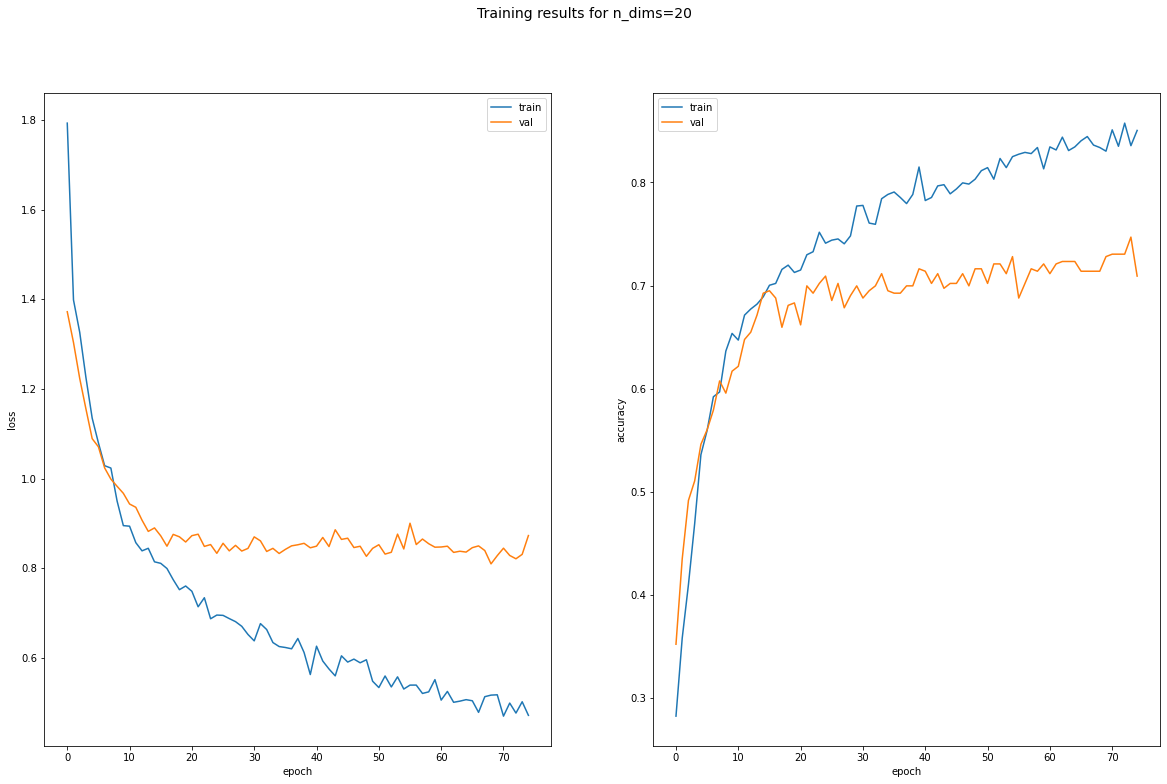

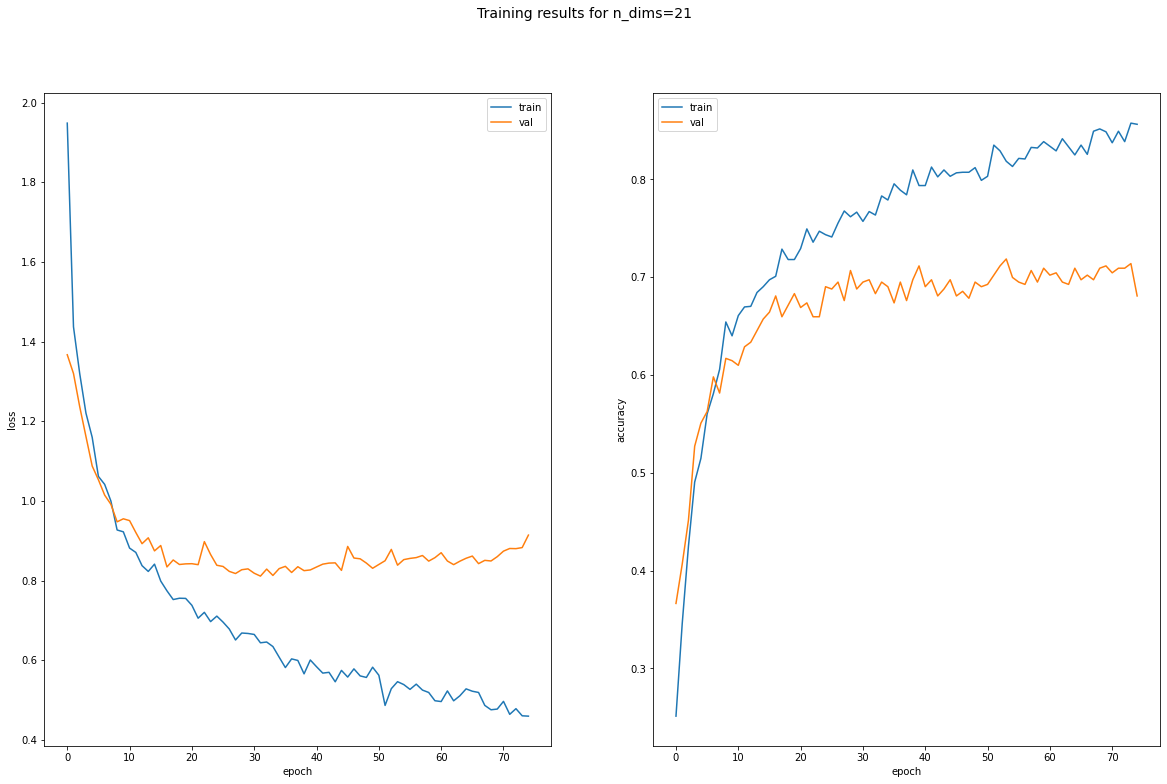

In [44]:
for n_comp in range(8, 22):
    print("Testing PCA Network for n_dims = {}".format(n_comp))
    
    X_train_valid_reshaped = X_train_valid_flipped.reshape((X_train_valid_norm_cropped.shape[0]*X_train_valid_norm_cropped.shape[2], 22)) 
    #print(X_train_valid_reshaped.shape)
    X_test_flipped = np.transpose(X_test_norm_cropped, (0,2,1))
    X_test_reshaped = X_test_flipped.reshape((X_test_norm_cropped.shape[0]*X_test_norm_cropped.shape[2], 22)) 


    #try a PCA on the data
    #reshaped_data = X_train_valid_flipped.reshape((X_train_valid_cropped.shape[1]*X_train_valid_cropped.shape[2], 22))    # create one big data panel with 20 series and 300.000 datapoints
                                          #choose the number of features to have after dimensionality reduction
    pca = PCA(n_components=n_comp)                  #create the pca object       
    pca.fit(X_train_valid_reshaped)                               #fit it to your transformed data
    X_train_valid_transformed=np.empty([X_train_valid_norm_cropped.shape[0],X_train_valid_norm_cropped.shape[2],n_comp])
    for i in range(len(X_train_valid_flipped)):
        #print(X_train_valid_flipped[i].shape)
        X_train_valid_transformed[i]=pca.transform(X_train_valid_flipped[i])           #iteratively apply the transformation to each instance of the original dataset


    #print(X_train_valid_transformed.shape)    #we end up with examples*timesteps*channels
    #now transpose back to examples*channels*timesteps
    X_train_valid_transformed = np.transpose(X_train_valid_transformed, (0,2,1))

    #n_comp=4                                      #choose the number of features to have after dimensionality reduction
    pca = PCA(n_components=n_comp)                  #create the pca object       
    pca.fit(X_test_reshaped)                               #fit it to your transformed data
    X_test_transformed=np.empty([X_test_norm_cropped.shape[0],X_test_norm_cropped.shape[2],n_comp])
    #print(X_test_transformed.shape)
    for i in range(len(X_test_flipped)):
        #print(X_test_flipped[i].shape)
        X_test_transformed[i]=pca.transform(X_test_flipped[i])           #iteratively apply the transformation to each instance of the original dataset

    #print(X_test_transformed.shape)    #we end up with examples*timesteps*channels
    #now transpose back to examples*channels*timesteps
    X_test_transformed = np.transpose(X_test_transformed, (0,2,1))
    
    input_ = layers.Input(shape=(n_comp, 500))
    r1 = layers.Reshape(target_shape=(n_comp, 500, 1))(input_)
    c1 = layers.Conv2D(filters=40, kernel_size=(1,25), data_format='channels_last',
                       activation='elu', kernel_regularizer='l2')(r1)
    p1 = layers.Permute(dims=(2,1,3))(c1)
    r2 = layers.Reshape((476, n_comp*40))(p1)
    d1 = layers.Dense(40, activation='elu')(r2)
    sq1 = layers.Activation(ksquare)(d1)
    ap1 = layers.AveragePooling1D(75, strides=15)(sq1)
    log1 = layers.Activation(klog)(ap1)
    f1 = layers.Flatten()(log1)
    d2 = layers.Dropout(0.80)(f1)
    output_ = layers.Dense(4, activation='softmax', kernel_regularizer='l2', kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01))(d2)
    
    model = models.Model(inputs=input_, outputs=output_, name='shallow_convnet_one_hot')
    #opt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    model.summary()
    
    loss_hist = model.fit(X_train_valid_transformed, y_train_valid_1h, 
                      validation_split=0.2, epochs=75,
                      verbose=True)

    hist = loss_hist.history

    fig, axs = plt.subplots(1,2, figsize=(20, 12))

    fig.suptitle("Training results for n_dims={}".format(n_comp), fontsize=14)

    axs[0].plot(hist['loss'])
    axs[0].plot(hist['val_loss'])
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'])

    axs[1].plot(hist['acc'])
    axs[1].plot(hist['val_acc'])
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'])

In [25]:
input_ = layers.Input(shape=(n_comp, 500))
r1 = layers.Reshape(target_shape=(n_comp, 500, 1))(input_)
c1 = layers.Conv2D(filters=40, kernel_size=(1,25), data_format='channels_last',
                   activation='elu', kernel_regularizer='l2')(r1)
p1 = layers.Permute(dims=(2,1,3))(c1)
r2 = layers.Reshape((476, n_comp*40))(p1)
d1 = layers.Dense(40, activation='elu')(r2)
sq1 = layers.Activation(ksquare)(d1)
ap1 = layers.AveragePooling1D(75, strides=15)(sq1)
log1 = layers.Activation(klog)(ap1)
f1 = layers.Flatten()(log1)
d2 = layers.Dropout(0.80)(f1)
output_ = layers.Dense(4, activation='softmax', kernel_regularizer='l2', kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01))(d2)

In [26]:
model = models.Model(inputs=input_, outputs=output_, name='shallow_convnet_one_hot')
#opt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "shallow_convnet_one_hot"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16, 500)]         0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 16, 500, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 476, 40)       1040      
_________________________________________________________________
permute_1 (Permute)          (None, 476, 16, 40)       0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 476, 640)          0         
_________________________________________________________________
dense_2 (Dense)              (None, 476, 40)           25640     
_________________________________________________________________
activation_2 (Activation)    (None, 476, 40

Epoch 1/75
53/53 [==============================] - 5s 86ms/step - loss: 1.8369 - acc: 0.2801 - val_loss: 1.3619 - val_acc: 0.3853
Epoch 2/75
53/53 [==============================] - 4s 82ms/step - loss: 1.4106 - acc: 0.3493 - val_loss: 1.3095 - val_acc: 0.4279
Epoch 3/75
53/53 [==============================] - 4s 82ms/step - loss: 1.3040 - acc: 0.4125 - val_loss: 1.2292 - val_acc: 0.4752
Epoch 4/75
53/53 [==============================] - 5s 90ms/step - loss: 1.2330 - acc: 0.4557 - val_loss: 1.1723 - val_acc: 0.5106
Epoch 5/75
53/53 [==============================] - 6s 108ms/step - loss: 1.1341 - acc: 0.5372 - val_loss: 1.0984 - val_acc: 0.5603
Epoch 6/75
53/53 [==============================] - 6s 107ms/step - loss: 1.0733 - acc: 0.5715 - val_loss: 1.0684 - val_acc: 0.5839
Epoch 7/75
53/53 [==============================] - 6s 104ms/step - loss: 1.0495 - acc: 0.5887 - val_loss: 1.0360 - val_acc: 0.5792
Epoch 8/75
53/53 [==============================] - 6s 106ms/step - loss: 0.9843

Epoch 63/75
53/53 [==============================] - 6s 105ms/step - loss: 0.5721 - acc: 0.8073 - val_loss: 0.8170 - val_acc: 0.7376
Epoch 64/75
53/53 [==============================] - 6s 106ms/step - loss: 0.5410 - acc: 0.8115 - val_loss: 0.8394 - val_acc: 0.7210
Epoch 65/75
53/53 [==============================] - 6s 105ms/step - loss: 0.5395 - acc: 0.8251 - val_loss: 0.8077 - val_acc: 0.7258
Epoch 66/75
53/53 [==============================] - 5s 104ms/step - loss: 0.5148 - acc: 0.8339 - val_loss: 0.8279 - val_acc: 0.7163
Epoch 67/75
53/53 [==============================] - 6s 105ms/step - loss: 0.5442 - acc: 0.8197 - val_loss: 0.8432 - val_acc: 0.7258
Epoch 68/75
53/53 [==============================] - 6s 110ms/step - loss: 0.5233 - acc: 0.8387 - val_loss: 0.8498 - val_acc: 0.7187
Epoch 69/75
53/53 [==============================] - 7s 126ms/step - loss: 0.5318 - acc: 0.8233 - val_loss: 0.8262 - val_acc: 0.7045
Epoch 70/75
53/53 [==============================] - 6s 118ms/step - 

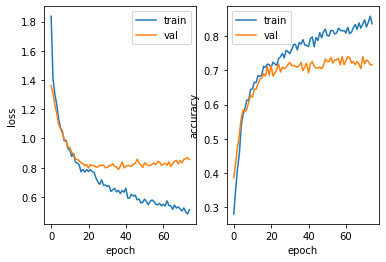

In [27]:
## Training 12

## Wow, best performance now 74%


loss_hist = model.fit(X_train_valid_transformed, y_train_valid_1h, 
                      validation_split=0.2, epochs=75,
                      verbose=True)

hist = loss_hist.history

plt.subplot(1,2,1)
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

plt.subplot(1,2,2)
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

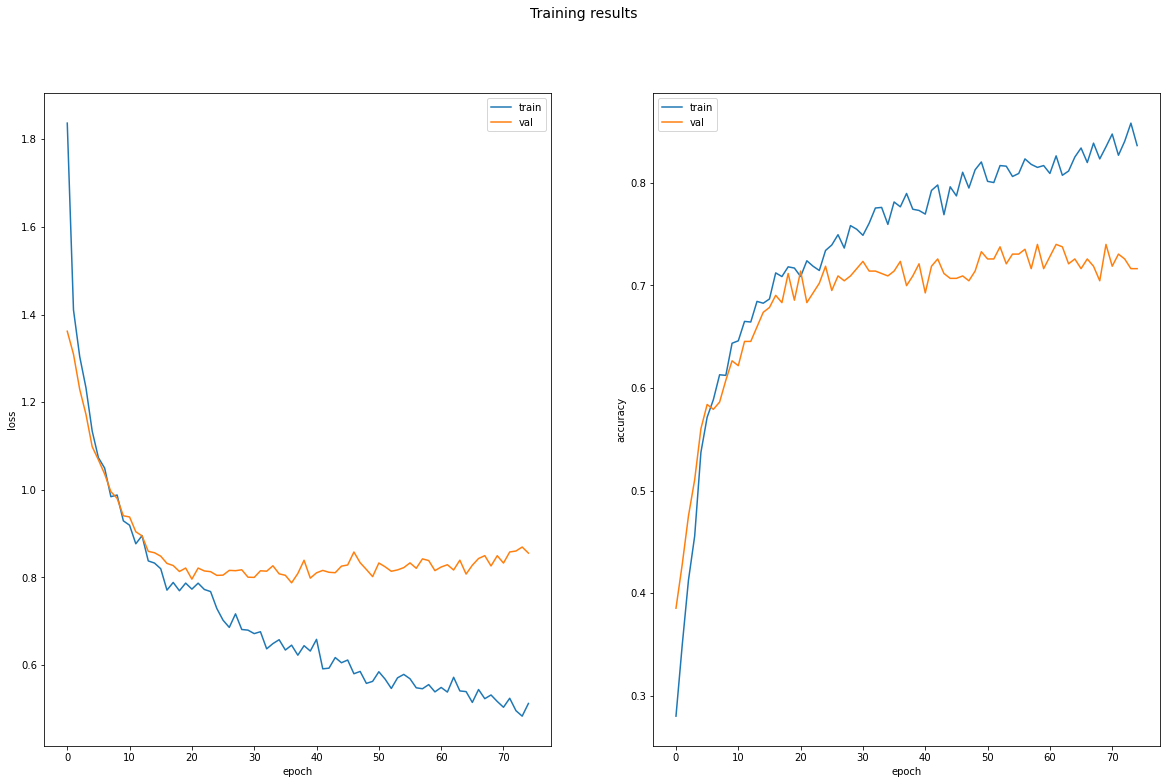

In [41]:
hist = loss_hist.history

fig, axs = plt.subplots(1,2, figsize=(20, 12))

fig.suptitle("Training results", fontsize=14)

axs[0].plot(hist['loss'])
axs[0].plot(hist['val_loss'])
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'val'])

axs[1].plot(hist['acc'])
axs[1].plot(hist['val_acc'])
axs[1].set_ylabel('accuracy')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'val'])